# Visualisation of all TF analysis results (upreg and downreg along invading trophoblast trajectory)

## Alternative version of analysis to notebook M9 - here in addition implementing a logFC cutoff for TFs in DE analysis - and also only looking at donor P13 data

Just plotting top 10% selected limma TFs (by logFC among the significant ones)
1. Differential expression calculted with `limma`

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


In [4]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
anndata2ri==1.0.6
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
astunparse==1.6.3
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_

# Getting to lists of TFs up/down regulated along the trajectory

In [6]:
# reading in results of DoRothEA first - just to get the list of TF names here

In [7]:
TF_activities = {}

# up and down reg separately
TF_activities_upreg = {}
TF_activities_downreg = {}

comparisons = ['GC_vs_iEVT','iEVT_vs_EVT_2','eEVT_vs_EVT_2',
               'EVT_2_vs_EVT_1','EVT_1_vs_VCT_CCC','VCT_CCC_vs_VCT'
              ]

for comparison in comparisons:
    print(comparison)
    TF_activities[comparison] = pd.read_csv('./results/20211129_TF_activities_' + comparison + '.csv',
                                           sep='\t')
    
    # add a score (A, B, .., F) and TF_name
    TF_activities[comparison]['score'] = [elem.split('_')[1] for elem in TF_activities[comparison]['Regulon']]
    TF_activities[comparison]['TF_name'] = [elem.split('_')[0] for elem in TF_activities[comparison]['Regulon']]
    
    # only taking TFs that are active (NES > 0)
    TF_activities_upreg[comparison] = TF_activities[comparison][TF_activities[comparison]['NES'] > 0]
    # also taking only those that have FDR < 0.05, like in DE
    TF_activities_upreg[comparison] = TF_activities_upreg[comparison][TF_activities_upreg[comparison]['FDR'] < 0.05]
    
    
    # only taking TFs that are active (NES < 0)
    TF_activities_downreg[comparison] = TF_activities[comparison][TF_activities[comparison]['NES'] < 0]
    # also taking only those that have FDR < 0.05, like in DE
    TF_activities_downreg[comparison] = TF_activities_downreg[comparison][TF_activities_downreg[comparison]['FDR'] < 0.05]
        
    print('number of TFs overall:', len(TF_activities[comparison]))
    print('number of significant upreg active TFs:', len(TF_activities_upreg[comparison]),'\n')
    print('number of significant downreg active TFs:', len(TF_activities_downreg[comparison]),'\n')
    

GC_vs_iEVT
number of TFs overall: 1385
number of significant upreg active TFs: 198 

number of significant downreg active TFs: 159 

iEVT_vs_EVT_2
number of TFs overall: 1385
number of significant upreg active TFs: 450 

number of significant downreg active TFs: 130 

eEVT_vs_EVT_2
number of TFs overall: 1385
number of significant upreg active TFs: 546 

number of significant downreg active TFs: 89 

EVT_2_vs_EVT_1
number of TFs overall: 1385
number of significant upreg active TFs: 404 

number of significant downreg active TFs: 314 

EVT_1_vs_VCT_CCC
number of TFs overall: 1385
number of significant upreg active TFs: 97 

number of significant downreg active TFs: 557 

VCT_CCC_vs_VCT
number of TFs overall: 1385
number of significant upreg active TFs: 215 

number of significant downreg active TFs: 452 



## Adding another layer of evidence: differential expression

In [8]:
# all TF regulons list, same in all tables
TFs_list = list(TF_activities['GC_vs_iEVT']['TF_name'])

In [9]:
len(TFs_list)

1385

In [12]:
# reading in tables of DE for ct-vs-previous_ct comparisons

DEGs = {}

DEGs_significant_upreg = {}

DEGs_significant_upreg_TFs = {} # intersection of significant upreg DEGs with all TFs list

DEGs_significant_downreg = {}

DEGs_significant_downreg_TFs = {} # intersection of significant downreg DEGs with all TFs list

for comparison in comparisons:
    print(comparison)
    DEGs[comparison] = pd.read_csv('../2-3_DE_analysis_inv_troph/limma_DEGs/20220222/20220222_' + comparison + '_limma_DEGs.csv', 
                                   index_col=0)
    DEGs_significant_upreg[comparison] = DEGs[comparison][DEGs[comparison]['adj.P.Val'] < 0.05]
    DEGs_significant_upreg[comparison] = DEGs_significant_upreg[comparison][DEGs_significant_upreg[comparison]['logFC'] > 0]
    
    DEGs_significant_upreg_TFs[comparison] = DEGs_significant_upreg[comparison].loc[list(set(TFs_list) & set(DEGs_significant_upreg[comparison].index)),:]
    
    
    DEGs_significant_downreg[comparison] = DEGs[comparison][DEGs[comparison]['adj.P.Val'] < 0.05]
    DEGs_significant_downreg[comparison] = DEGs_significant_downreg[comparison][DEGs_significant_downreg[comparison]['logFC'] < 0]
    
    DEGs_significant_downreg_TFs[comparison] = DEGs_significant_downreg[comparison].loc[list(set(TFs_list) & set(DEGs_significant_downreg[comparison].index)),:]
    
    print('number of DEGs overall:', len(DEGs[comparison]))
    print('number of significant upreg DEGs:', len(DEGs_significant_upreg[comparison]))
    print('number of significant upreg DEGs that are TFs:', len(DEGs_significant_upreg_TFs[comparison]))
    print('number of significant upreg DEGs:', len(DEGs_significant_downreg[comparison]))
    print('number of significant upreg DEGs that are TFs:', len(DEGs_significant_downreg_TFs[comparison]),'\n')


GC_vs_iEVT
number of DEGs overall: 25209
number of significant upreg DEGs: 1808
number of significant upreg DEGs that are TFs: 54
number of significant upreg DEGs: 1068
number of significant upreg DEGs that are TFs: 73 

iEVT_vs_EVT_2
number of DEGs overall: 25840
number of significant upreg DEGs: 1763
number of significant upreg DEGs that are TFs: 82
number of significant upreg DEGs: 2970
number of significant upreg DEGs that are TFs: 203 

eEVT_vs_EVT_2
number of DEGs overall: 23624
number of significant upreg DEGs: 1221
number of significant upreg DEGs that are TFs: 61
number of significant upreg DEGs: 248
number of significant upreg DEGs that are TFs: 18 

EVT_2_vs_EVT_1
number of DEGs overall: 24634
number of significant upreg DEGs: 1730
number of significant upreg DEGs that are TFs: 112
number of significant upreg DEGs: 2302
number of significant upreg DEGs that are TFs: 129 

EVT_1_vs_VCT_CCC
number of DEGs overall: 24799
number of significant upreg DEGs: 2128
number of signific

In [13]:
# reading in tables of DE for ct-vs-previous_ct comparisons

DEGs = {}

DEGs_significant_upreg = {}

DEGs_significant_upreg_TFs = {} # intersection of significant upreg DEGs with all TFs list

DEGs_significant_downreg = {}

DEGs_significant_downreg_TFs = {} # intersection of significant downreg DEGs with all TFs list

for comparison in comparisons:
    print(comparison)
    DEGs[comparison] = pd.read_csv('../2-3_DE_analysis_inv_troph/limma_DEGs/20220222/20220222_' + comparison + '_limma_DEGs.csv', 
                                   index_col=0)
    
    # choosing this so that we select only top 20% of TFs for each comparison
    curr_logFC_cutoff_upreg = np.quantile(DEGs[comparison]['logFC'], 0.9)
    
    DEGs_significant_upreg[comparison] = DEGs[comparison][DEGs[comparison]['adj.P.Val'] < 0.05]
    DEGs_significant_upreg[comparison] = DEGs_significant_upreg[comparison][DEGs_significant_upreg[comparison]['logFC'] > curr_logFC_cutoff_upreg]
    
    DEGs_significant_upreg_TFs[comparison] = DEGs_significant_upreg[comparison].loc[list(set(TFs_list) & set(DEGs_significant_upreg[comparison].index)),:]

    # choosing this so that we select only top 20% of TFs for each comparison
    curr_logFC_cutoff_downreg = np.quantile(-DEGs[comparison]['logFC'], 0.9)
    
    DEGs_significant_downreg[comparison] = DEGs[comparison][DEGs[comparison]['adj.P.Val'] < 0.05]
    DEGs_significant_downreg[comparison] = DEGs_significant_downreg[comparison][DEGs_significant_downreg[comparison]['logFC'] < -curr_logFC_cutoff_downreg]
    
    DEGs_significant_downreg_TFs[comparison] = DEGs_significant_downreg[comparison].loc[list(set(TFs_list) & set(DEGs_significant_downreg[comparison].index)),:]
    
    print('number of DEGs overall:', len(DEGs[comparison]))
    print('number of significant upreg DEGs:', len(DEGs_significant_upreg[comparison]))
    print('number of significant upreg DEGs that are TFs:', len(DEGs_significant_upreg_TFs[comparison]))
    print('number of significant upreg DEGs:', len(DEGs_significant_downreg[comparison]))
    print('number of significant upreg DEGs that are TFs:', len(DEGs_significant_downreg_TFs[comparison]),'\n')


GC_vs_iEVT
number of DEGs overall: 25209
number of significant upreg DEGs: 1373
number of significant upreg DEGs that are TFs: 38
number of significant upreg DEGs: 1068
number of significant upreg DEGs that are TFs: 73 

iEVT_vs_EVT_2
number of DEGs overall: 25840
number of significant upreg DEGs: 1623
number of significant upreg DEGs that are TFs: 75
number of significant upreg DEGs: 2171
number of significant upreg DEGs that are TFs: 159 

eEVT_vs_EVT_2
number of DEGs overall: 23624
number of significant upreg DEGs: 695
number of significant upreg DEGs that are TFs: 47
number of significant upreg DEGs: 248
number of significant upreg DEGs that are TFs: 18 

EVT_2_vs_EVT_1
number of DEGs overall: 24634
number of significant upreg DEGs: 1595
number of significant upreg DEGs that are TFs: 103
number of significant upreg DEGs: 1901
number of significant upreg DEGs that are TFs: 108 

EVT_1_vs_VCT_CCC
number of DEGs overall: 24799
number of significant upreg DEGs: 1829
number of significa

In [20]:
DEGs_significant_upreg_TFs['eEVT_vs_EVT_2']

logFC       P.Value     adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                            
DNMT3A    0.266868  1.460926e-08  1.437339e-06         0.417730      0.150861   
ZNF25     0.167574  2.474480e-14  5.965011e-12         0.184188      0.016614   
ZNF211    0.071822  1.696170e-03  3.075236e-02         0.114953      0.043131   
PAX8      0.252823  1.379836e-05  6.963967e-04         0.480791      0.227968   
ZNF121    0.377445  8.759160e-10  1.083384e-07         0.661724      0.284279   
HMGA2     0.139028  4.900651e-21  1.897918e-18         0.146150      0.007122   
ZNF124    0.258484  5.118215e-04  1.192433e-02         0.773118      0.514634   
ESRRA     0.235720  1.274456e-03  2.420238e-02         0.745940      0.510220   
GCM1      0.401823  3.980759e-04  1.131228e-02         2.387006      1.985183   
DMAP1     0.112816  3.507744e-06  2.076866e-04         0.152438      0.039622   
PPP1R13L  0.242759  3.283440e-04  1.038393e-02         0.620401      0.377642   
HES4      0.804835  6.676596e-50  1.051519e-46         0.951552      0.146717   
GATA6     0.098385  2.009241e-03  3.521240e-02         0.152222      0.053837   
NFATC3    0.241899  2.794491e-04  9.080751e-03         0.590421      0.348522   
SMAD3     1.107353  5.509769e-32  4.338759e-29         1.558107      0.450754   
ZSCAN21   0.116549  5.113070e-06  2.875980e-04         0.156233      0.039684   
ZNF780A   0.172006  2.865674e-09  3.134198e-07         0.220887      0.048882   
PLAGL1    0.574164  2.231310e-13  4.836006e-11         0.997026      0.422862   
SOX5      0.174332  5.412545e-04  1.228299e-02         0.321025      0.146694   
ZNF570    0.120840  1.277885e-03  2.423991e-02         0.230124      0.109284   
IRF1      0.104225  1.879873e-03  3.334094e-02         0.176345      0.072120   
ZNF845    0.061402  2.242825e-03  3.857525e-02         0.087841      0.026439   
ID3       0.471010  4.823088e-07  3.605716e-05         1.130965      0.659955   
RORA      0.145374  3.024994e-03  4.886250e-02         0.281275      0.135901   
ZNF420    0.197590  2.480303e-05  1.157998e-03         0.343514      0.145924   
RXRA      0.195762  3.210128e-04  1.021322e-02         0.412860      0.217099   
CREB3L2   0.507166  3.113931e-08  2.873574e-06         2.238819      1.731653   
TFDP2     0.444884  1.574396e-06  1.002521e-04         1.189767      0.744883   
ZNF641    0.057079  2.325895e-03  3.967288e-02         0.083248      0.026168   
NCOA1     0.410962  8.650078e-05  3.344650e-03         2.544183      2.133221   
PBX3      0.398784  4.180337e-14  9.875628e-12         0.542926      0.144142   
ZNF491    0.068324  6.805298e-05  2.715682e-03         0.086160      0.017835   
NCOR2     0.446555  3.645641e-07  2.796254e-05         1.162379      0.715824   
ZNF280C   0.174419  1.102593e-04  4.134550e-03         0.326447      0.152027   
DLX3      0.157540  6.672873e-08  5.774357e-06         0.216530      0.058989   
MTA3      0.270035  2.033166e-03  3.552626e-02         1.166976      0.896941   
IRF8      0.205203  1.832961e-15  4.977225e-13         0.234341      0.029138   
KLF9      0.121638  3.508573e-21  1.381442e-18         0.127176      0.005539   
MYCN      0.539449  2.094392e-08  1.979117e-06         1.554168      1.014719   
ZNF611    0.245671  4.287042e-04  1.131228e-02         0.623777      0.378106   
NFAT5     0.632899  5.406485e-11  8.293689e-09         1.842350      1.209451   
ZNF423    0.466465  1.561073e-14  3.873744e-12         0.675464      0.209000   
ZNF561    0.149800  2.312486e-08  2.159295e-06         0.197078      0.047278   
ZNF674    0.098935  2.748055e-05  1.267970e-03         0.136559      0.037624   
ZNF562    0.477941  1.475388e-08  1.437339e-06         1.101156      0.623215   
SREBF2    0.323832  3.944164e-05  1.703417e-03         0.817794      0.493962   
TCF7L1    0.449837  1.381330e-12  2.631656e-10         0.639437      0.189600   

          percentExpr_cluster  percentExpr_

In [21]:
DEGs_significant_upreg_TFs['GC_vs_iEVT']

logFC       P.Value     adj.P.Val  AveExpr_cluster  AveExpr_rest  \
Gene                                                                           
CEBPA    0.168960  4.785759e-04  6.293385e-03         0.311916      0.142956   
CEBPD    0.363356  6.192209e-07  1.711616e-05         0.704269      0.340913   
NR2F6    0.266616  1.732727e-05  3.404545e-04         0.516953      0.250337   
XBP1     0.335831  4.234484e-06  9.775376e-05         0.691006      0.355174   
NFE2L3   0.131849  1.324024e-03  1.505518e-02         0.229179      0.097330   
GATA6    0.063549  4.933221e-03  4.441484e-02         0.092670      0.029121   
SREBF1   0.172926  2.156792e-03  2.243010e-02         0.362673      0.189748   
ZNF655   0.173768  1.396899e-07  4.407311e-06         0.255956      0.082188   
THAP3    0.059467  1.060532e-03  1.243486e-02         0.080686      0.021219   
THAP7    0.072237  3.386303e-03  3.259462e-02         0.104243      0.032006   
CEBPB    0.510343  1.177996e-09  6.060431e-08         0.965165      0.454822   
ZNF263   0.091439  5.444504e-04  7.023138e-03         0.137406      0.045967   
KLF16    0.078996  9.011485e-04  1.082796e-02         0.113384      0.034388   
YBX1     0.383464  3.320462e-07  9.801585e-06         0.768069      0.384605   
FOS      0.387285  1.733402e-03  1.881074e-02         1.824099      1.436814   
NFKBIL1  0.058728  5.656649e-03  4.966857e-02         0.080698      0.021970   
SRF      0.176404  5.064165e-08  1.718204e-06         0.244415      0.068011   
ZBED1    0.051216  2.457803e-04  3.522386e-03         0.069878      0.018662   
ZNF514   0.074276  2.812215e-04  3.967159e-03         0.102886      0.028610   
GATA2    0.405316  1.770191e-06  4.453568e-05         0.882637      0.477321   
SNAI1    0.147049  2.228959e-07  6.769859e-06         0.195471      0.048422   
ID3      0.410111  1.088878e-07  3.496771e-06         0.736733      0.326621   
ZNF664   0.095880  8.690635e-08  2.848924e-06         0.116629      0.020749   
TCF21    0.056959  2.845344e-03  2.828647e-02         0.075816      0.018857   
IRF7     0.099925  1.926605e-03  2.045656e-02         0.151976      0.052052   
MYCL     0.159064  6.651770e-06  1.463215e-04         0.242197      0.083133   
E2F6     0.081396  1.538941e-03  1.697077e-02         0.125856      0.044461   
DLX3     0.175976  5.098370e-07  1.436032e-05         0.250733      0.074757   
ELK4     0.225754  2.588593e-06  6.249487e-05         0.374268      0.148513   
PEG3     0.194915  3.818772e-09  1.796034e-07         0.261754      0.066838   
FOXJ2    0.079358  2.934395e-03  2.897500e-02         0.121322      0.041964   
ZNF668   0.086255  5.770339e-04  7.372756e-03         0.124260      0.038006   
MAZ      0.314279  1.876975e-10  1.077828e-08         0.467996      0.153717   
ZFP42    0.078103  8.122266e-04  9.890690e-03         0.112486      0.034383   
BCL11A   0.049588  9.318974e-04  1.114960e-02         0.058470      0.008882   
SOX4     0.569952  9.106328e-08  2.969463e-06         1.352411      0.782460   
KLF10    0.143574  2.458997e-03  2.500559e-02         0.280237      0.136663   
ASCL2    0.579856  2.351860e-09  1.153464e-07         1.306586      0.726730   

         percentExpr_cluster  percentExpr_rest  
Gene                                            
CEBPA               0.362069          0.185316  
CEBPD               0.534483          0.349367  
NR2F6               0.448276          0.286076  
XBP1                0.568966          0.352911  
NFE2L3              0.224138          0.130127  
GATA6               0.103448          0.043544  
SREBF1              0.362069          0.226329  
ZNF655              0.293103          0.133165  
THAP3               0.103448          0.041013  
THAP7               0.155172          0.045570  
CEBPB               0.655172          0.414684  
ZNF263              0.172414          0.081013  
KLF16               0.172414          0.060253  
YBX1                0.586207          0.386835  
FOS                 0.86206

In [28]:
TFs_union = []

for comparison in comparisons:
    TFs_union.append(list(DEGs_significant_upreg_TFs[comparison].index))
    TFs_union.append(list(DEGs_significant_downreg_TFs[comparison].index))

# flatten list 
TFs_union = [item for sublist in TFs_union for item in sublist]


In [30]:
len(TFs_union)

1193

# 08.02.2022 change here: now not scaling values, just taking norm + log transformed, will take a z-score later for visualisation purposes

In [72]:
# visualising scaled gene expression - donor P13 data only
# raw values in .X, all filtered genes
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202007_snRNA-seq_MFI/snRNA_seq_MFI_202007_adatas/202012_FINAL_reanalysis_with_souporcell_deconvolution_common_variants/donor_P13_all_samples_analysis_202110/'
adata_in_vivo_raw = sc.read(save_path + 'adata_raw_filtered.h5ad')

In [73]:
# reading the fully analysed and annotated file (annotations in 'final_annot_all_troph_corrected')
adata_annot = sc.read(save_path + 'adata_P13_scVI_analysed_corr_by_sample_SN_and_multiome_trophoblast_v5_final.h5ad')

In [74]:
adata_in_vivo_raw = adata_in_vivo_raw[adata_annot.obs_names,:]
adata_in_vivo_raw.obs['cell_type'] = adata_annot.obs.loc[adata_in_vivo_raw.obs_names,'final_annot_all_troph_corrected']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [75]:
adata_in_vivo_raw.obs['cell_type'].value_counts()

SCT           22869
VCT            7560
VCT_p          2000
iEVT           1975
VCT_CCC        1016
EVT_2           883
EVT_1           720
VCT_fusing      523
eEVT             71
GC               58
Name: cell_type, dtype: int64

In [76]:
# unite VCT and VCT_p
adata_in_vivo_raw.obs['cell_type'] = ['VCT' if ct in ['VCT','VCT_p'] else ct for ct in adata_in_vivo_raw.obs['cell_type']]
adata_in_vivo_raw.obs['cell_type'].value_counts()

SCT           22869
VCT            9560
iEVT           1975
VCT_CCC        1016
EVT_2           883
EVT_1           720
VCT_fusing      523
eEVT             71
GC               58
Name: cell_type, dtype: int64

In [77]:
# subset to only populations of interest
# NEW: also preseving VCT here (which are VCT and VCT_p united as is in all comparisons)
adata_in_vivo_raw = adata_in_vivo_raw[adata_in_vivo_raw.obs['cell_type'].isin([ 'VCT', # now including this population for plotting
                                                                                'VCT_CCC','EVT_1','EVT_2',
                                                                                'eEVT','iEVT','GC'])]
adata_in_vivo_raw

View of AnnData object with n_obs × n_vars = 14283 × 29058
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'

In [78]:
# normalise and log transform the data
adata_in_vivo_normlog = adata_in_vivo_raw.copy()
sc.pp.normalize_per_cell(adata_in_vivo_normlog, counts_per_cell_after=1e4)
sc.pp.log1p(adata_in_vivo_normlog)

# saving normalised and log transformed values into the raw attribute to later be able to plot
adata_in_vivo_normlog.raw = adata_in_vivo_normlog.copy()

adata_in_vivo_normlog.var_names_make_unique()
adata_in_vivo_normlog.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [79]:
TFs_union = list(set(TFs_union))

In [81]:
len(TFs_union)

539

In [82]:
# subset only to genes of interest (TFs here)
adata_in_vivo_normlog = adata_in_vivo_normlog[:,TFs_union]
adata_in_vivo_normlog

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 14283 × 539
    obs: 'n_genes', 'donor', 'tissue_block', 'age', 'sample', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7'
    uns: 'log1p'

In [83]:
np.unique(adata_in_vivo_normlog.obs['cell_type'])

array(['EVT_1', 'EVT_2', 'GC', 'VCT', 'VCT_CCC', 'eEVT', 'iEVT'],
      dtype=object)

In [84]:
adata_in_vivo_normlog.X.shape

(14283, 539)

In [85]:
adata_in_vivo_normlog.var_names.shape

(539,)

In [86]:
adata_in_vivo_normlog.obs_names.shape

(14283,)

In [87]:
adata_in_vivo_normlog.X

<14283x539 sparse matrix of type '<class 'numpy.float32'>'
	with 2262002 stored elements in Compressed Sparse Row format>

In [88]:
df_expr = pd.DataFrame(adata_in_vivo_normlog.X.todense(),
                      columns = adata_in_vivo_normlog.var_names,
                      index = adata_in_vivo_normlog.obs_names
                      )

In [89]:
# producing table of avr expression
df_avg_expr = pd.DataFrame(index = adata_in_vivo_normlog.var_names,
                           columns=list(np.unique(adata_in_vivo_normlog.obs['cell_type'])))

In [90]:
df_avg_expr

EVT_1 EVT_2   GC  VCT VCT_CCC eEVT iEVT
E2F4      NaN   NaN  NaN  NaN     NaN  NaN  NaN
SOX6      NaN   NaN  NaN  NaN     NaN  NaN  NaN
HES4      NaN   NaN  NaN  NaN     NaN  NaN  NaN
ZBTB4     NaN   NaN  NaN  NaN     NaN  NaN  NaN
KLF13     NaN   NaN  NaN  NaN     NaN  NaN  NaN
...       ...   ...  ...  ...     ...  ...  ...
BBX       NaN   NaN  NaN  NaN     NaN  NaN  NaN
ZNF354B   NaN   NaN  NaN  NaN     NaN  NaN  NaN
ZNF345    NaN   NaN  NaN  NaN     NaN  NaN  NaN
SOX4      NaN   NaN  NaN  NaN     NaN  NaN  NaN
ZBTB46    NaN   NaN  NaN  NaN     NaN  NaN  NaN

[539 rows x 7 columns]

In [91]:
%%time
# takes a few minutes

i = 0
for gene in df_avg_expr.index:
    if i%100 == 0:
        print(i)
    for ct in df_avg_expr.columns:
        curr_obs_names = list(adata_in_vivo_normlog[adata_in_vivo_normlog.obs['cell_type'] == ct].obs_names)
        df_avg_expr.loc[gene,ct] = np.mean(df_expr.loc[curr_obs_names,gene])
    i += 1

0


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


100
200
300
400
500
CPU times: user 1min 22s, sys: 20 s, total: 1min 42s
Wall time: 1min 42s


In [92]:
# save to read in later
# already done
df_avg_expr.to_csv('./intermediate_files/20220222_df_avg_normlog_expr_TFs_union_top_10%_in_limma_donor_P13_only.csv')


In [93]:
# reading from file
df_avg_expr = pd.read_csv('./intermediate_files/20220222_df_avg_normlog_expr_TFs_union_top_10%_in_limma_donor_P13_only.csv',
                         index_col=0)


In [94]:
df_avg_expr

EVT_1     EVT_2        GC       VCT   VCT_CCC      eEVT      iEVT
E2F4     0.242927  0.179673  0.165738  0.243792  0.299242  0.267825  0.145790
SOX6     0.091064  0.055885  0.049169  0.146529  0.092593  0.054526  0.070683
HES4     0.158274  0.146717  0.316205  0.027693  0.067336  0.951552  0.322459
ZBTB4    0.020573  0.014308  0.018396  0.192418  0.104847  0.000000  0.029140
KLF13    0.503862  0.400924  0.170487  0.208237  0.278129  0.313440  0.170903
...           ...       ...       ...       ...       ...       ...       ...
BBX      1.184163  1.170192  0.749879  1.808764  1.632657  1.125525  1.243027
ZNF354B  0.131196  0.101453  0.018722  0.552785  0.242883  0.165314  0.098336
ZNF345   0.134911  0.210817  0.027310  0.210679  0.134778  0.302491  0.212129
SOX4     0.632310  1.089202  1.352412  0.140898  0.250746  1.250262  0.782460
ZBTB46   0.240796  0.197107  0.075901  0.392958  0.190628  0.307137  0.096041

[539 rows x 7 columns]

In [95]:
'HAND2' in TFs_list

True

In [96]:
'HAND2' in TFs_union

False

In [101]:
#df_avg_expr.loc['HAND2']

In [10]:
# this was for all donors
df_avg_expr.loc['HAND2']

EVT_1      0.011084
EVT_2      0.039951
GC         0.114077
VCT        0.012661
VCT_CCC    0.016673
eEVT       0.000000
iEVT       0.036388
Name: HAND2, dtype: float64

In [98]:
# need to make a subset of this table to then take z-scores separately (from table for visualisation with VCT) and use it to do clustering on
df_avg_expr_for_clustering_genes = df_avg_expr.loc[:,['EVT_1','EVT_2','GC','VCT_CCC','eEVT','iEVT']]
df_avg_expr_for_clustering_genes

EVT_1     EVT_2        GC   VCT_CCC      eEVT      iEVT
E2F4     0.242927  0.179673  0.165738  0.299242  0.267825  0.145790
SOX6     0.091064  0.055885  0.049169  0.092593  0.054526  0.070683
HES4     0.158274  0.146717  0.316205  0.067336  0.951552  0.322459
ZBTB4    0.020573  0.014308  0.018396  0.104847  0.000000  0.029140
KLF13    0.503862  0.400924  0.170487  0.278129  0.313440  0.170903
...           ...       ...       ...       ...       ...       ...
BBX      1.184163  1.170192  0.749879  1.632657  1.125525  1.243027
ZNF354B  0.131196  0.101453  0.018722  0.242883  0.165314  0.098336
ZNF345   0.134911  0.210817  0.027310  0.134778  0.302491  0.212129
SOX4     0.632310  1.089202  1.352412  0.250746  1.250262  0.782460
ZBTB46   0.240796  0.197107  0.075901  0.190628  0.307137  0.096041

[539 rows x 6 columns]

In [99]:
# need to take per TF z-score for visualisation purposes
df_avg_expr = df_avg_expr.astype(float)
df_avg_expr_zscores = df_avg_expr.copy()

for TF in df_avg_expr_zscores.index:
    print(TF)
    df_avg_expr_zscores.loc[TF,:] = scipy.stats.zscore(list(df_avg_expr.loc[TF,:]))

E2F4
SOX6
HES4
ZBTB4
KLF13
THAP3
ZNF780B
IRF1
CTCF
ZNF146
MGA
PSPC1
ZFX
ZKSCAN1
ZNF138
ZNF565
NFIB
DNAJC2
MSX2
CSRNP1
GATAD2B
KLF2
RREB1
LHX2
SMAD1
LRRFIP1
ELF2
IRX2
ZNF614
TFEB
ZNF562
ZNF117
TEAD2
THRB
PAX8
SOX30
OSR2
GCM1
NFE2L3
TFAP2C
ZNF736
KDM5B
NFX1
YBX1
ZNF514
GATA2
ZNF761
ZNF32
IRF7
NR2F2
RUNX1
FOXM1
ZNF860
MXD1
ZNF257
ELF5
ARID3A
ZNF280C
ZNF14
KDM2A
ZNF462
ZNF248
ARNTL
ZNF701
SP100
MAZ
ID2
ZNF267
MECOM
ZNF846
TP63
HIC2
CEBPD
ZFAT
NFIL3
MYBL1
ELK3
ATF1
TRERF1
GABPA
REST
BARX2
FOXO1
ZNF664
CREM
CSRNP2
NR4A1
POGZ
ZNF641
RFX3
ZNF577
ARID1B
NFKBIZ
JARID2
TSC22D3
ZNF529
ZHX3
PRDM10
ZNF83
MYCN
RFX7
ZNF496
ZC3H6
TCF7L1
ARNTL2
ADNP2
ZBTB40
ZNF302
SP110
GLIS3
ARID1A
TET1
ZNF600
TCF7
USF2
KDM5A
SRF
ZFP14
ZBED1
ZNF789
FOSL1
ZNF613
SP4
SP1
DNMT1
ZNF341
MTA3
ZKSCAN8
PRDM15
ZNF813
GTF3A
NFKBIA
NR3C2
ZNF480
IRF6
ZNF438
ZNF441
RFX2
STAT3
ZNF25
ZNF292
ZBTB1
MEF2A
FOXO3
PURB
ZNF217
ZNF654
ZNF836
RERE
MAX
ADNP
ZNF100
SOX5
ZC3H4
GRHL3
BACH1
NFYB
RXRA
GATAD2A
USF1
NCOA1
MXD4
ZBTB7A
HIF3A
TSHZ1
NR2C

In [100]:
# need to take per TF z-score for visualisation purposes

# this matrix will be used in clustering the TFs + L/Rs

df_avg_expr_zscores_no_VCT = df_avg_expr_for_clustering_genes.copy()

for TF in df_avg_expr_zscores_no_VCT.index:
    df_avg_expr_zscores_no_VCT.loc[TF,:] = scipy.stats.zscore(list(df_avg_expr_for_clustering_genes.loc[TF,:]))


# In this part, instead of defining patterns manually, let's cluster genes (TFs in this case) based on their z-score(normlog expression) in the 6 cell types of interest here

In [102]:
df_avg_expr_zscores_no_VCT

EVT_1     EVT_2        GC   VCT_CCC      eEVT      iEVT
E2F4     0.461764 -0.659020 -0.905919  1.459610  0.902938 -1.259373
SOX6     1.267221 -0.752034 -1.137535  1.355036 -0.830064  0.097377
HES4    -0.574217 -0.613526 -0.037027 -0.883534  2.124055 -0.015752
ZBTB4   -0.312262 -0.496140 -0.376141  2.161451 -0.916127 -0.060781
KLF13    1.654038  0.792256 -1.136932 -0.235764  0.059852 -1.133450
...           ...       ...       ...       ...       ...       ...
BBX     -0.000300 -0.054625 -1.688942  1.743594 -0.228306  0.228580
ZNF354B  0.071272 -0.363268 -1.571948  1.703004  0.569737 -0.408795
ZNF345  -0.415308  0.472838 -1.674315 -0.416875  1.545479  0.488182
SOX4    -0.684393  0.515560  1.206838 -1.686513  0.938558 -0.290050
ZBTB46   0.705895  0.157082 -1.365452  0.075697  1.539243 -1.112466

[539 rows x 6 columns]

In [103]:
ct_in_order = ['VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']
df_avg_expr_zscores_no_VCT = df_avg_expr_zscores_no_VCT[ct_in_order] # TFs
df_avg_expr_zscores_no_VCT

VCT_CCC     EVT_1     EVT_2      iEVT        GC      eEVT
E2F4     1.459610  0.461764 -0.659020 -1.259373 -0.905919  0.902938
SOX6     1.355036  1.267221 -0.752034  0.097377 -1.137535 -0.830064
HES4    -0.883534 -0.574217 -0.613526 -0.015752 -0.037027  2.124055
ZBTB4    2.161451 -0.312262 -0.496140 -0.060781 -0.376141 -0.916127
KLF13   -0.235764  1.654038  0.792256 -1.133450 -1.136932  0.059852
...           ...       ...       ...       ...       ...       ...
BBX      1.743594 -0.000300 -0.054625  0.228580 -1.688942 -0.228306
ZNF354B  1.703004  0.071272 -0.363268 -0.408795 -1.571948  0.569737
ZNF345  -0.416875 -0.415308  0.472838  0.488182 -1.674315  1.545479
SOX4    -1.686513 -0.684393  0.515560 -0.290050  1.206838  0.938558
ZBTB46   0.075697  0.705895  0.157082 -1.112466 -1.365452  1.539243

[539 rows x 6 columns]

In [104]:
# out of curiosity - doing the same for all L/Rs 

df_LR_fetus_simple = pd.read_csv('../../4_cell-cell_communication/4-2_prioritising_results_and_visualisation/interm_files/20220211_LR_fetus_simple_df_avg_expr_for_pattern_selection.csv',
                         index_col=0)
df_LR_fetus_complex = pd.read_csv('../../4_cell-cell_communication/4-2_prioritising_results_and_visualisation/interm_files/20220211_LR_fetus_complex_df_avg_expr_for_pattern_selection.csv',
                         index_col=0)


In [105]:
df_LR_fetus_simple

SEMA4A      DLL4      XCL1     TGFB3     WNT5B      VASN    PTGER3  \
VCT_CCC  0.007080  0.004031  0.013881  0.006319  0.016526  0.080618  0.009742   
EVT_1    0.003030  0.002353  0.009313  0.003636  0.013420  0.028642  0.044153   
EVT_2    0.004539  0.002590  0.014577  0.006157  0.026536  0.038029  0.097395   
eEVT     0.000000  0.000000  0.048809  0.050545  0.042114  0.105045  0.778033   
iEVT     0.007207  0.003908  0.012189  0.010906  0.022068  0.071830  0.356003   
GC       0.000000  0.000000  0.000000  0.000000  0.057874  0.063885  0.684442   

            NTRK2      POMC     EFNB1  ...     S1PR2    CLEC4M     DSCAM  \
VCT_CCC  0.005715  0.003865  0.127440  ...  0.181413  0.000944  0.041803   
EVT_1    0.002445  0.021216  0.301914  ...  0.046627  0.000989  0.022624   
EVT_2    0.005420  0.041358  0.371058  ...  0.051504  0.002293  0.036561   
eEVT     0.000000  0.063498  0.155254  ...  0.000000  0.000000  0.520678   
iEVT     0.006637  0.117697  0.540273  ...  0.082986  0.001923  0.053515   
GC       0.000000  0.092182  0.680914  ...  0.000000  0.000000  0.157037   

             FRZB     EFNA5     PTGES      FGF2      EPOR   KIR2DL3      NTN4  
VCT_CCC  0.028765  0.202185  0.737331  0.022429  0.027605  0.003598  0.035489  
EVT_1    0.017559  0.070949  0.810284  0.003671  0.077668  0.001796  0.059319  
EVT_2    0.039816  0.143571  0.581261  0.011031  0.128597  0.002286  0.170363  
eEVT     0.013063  0.175232  0.035521  0.000000  0.292352  0.000000  0.926812  
iEVT     0.036015  0.125094  0.837888  0.010810  0.259144  0.001312  0.620948  
GC       0.000000  0.434634  0.894891  0.000000  0.147391  0.000000  0.549769  

[6 rows x 331 columns]

In [106]:
df_LR_fetus_complex

ITGA5     RAMP2   COL27A1      WNT6      LRP5      NRP1     ITGB2  \
VCT_CCC  0.353980  0.010056  0.164259  0.090338  0.234399  0.617197  0.016418   
EVT_1    1.200004  0.010044  0.805337  0.003632  0.019873  0.083166  0.010619   
EVT_2    1.713490  0.009377  1.692027  0.003739  0.025958  0.145223  0.020412   
eEVT     1.302134  0.000000  1.448324  0.000000  0.049713  0.042119  0.000000   
iEVT     1.827544  0.011360  1.806485  0.004794  0.027692  0.140429  0.024790   
GC       2.188430  0.000000  1.209462  0.000000  0.071027  0.414164  0.063885   

           SEMA6D      FZD6      JAM2  ...    ITGA11      CD47   COL11A1  \
VCT_CCC  0.506556  0.139578  0.015504  ...  0.004212  0.543816  0.015790   
EVT_1    0.160409  0.049452  0.041256  ...  0.002384  0.329133  0.033307   
EVT_2    0.350891  0.066785  0.102457  ...  0.004547  0.235068  0.041160   
eEVT     2.774941  0.059044  0.000000  ...  0.000000  0.240616  0.000000   
iEVT     0.854799  0.089705  0.399135  ...  0.006221  0.263946  0.186866   
GC       1.456230  0.000000  0.437881  ...  0.000000  0.246838  0.099163   

          COL26A1   COL17A1   CYSLTR2      FZD7     WNT7A      IL7R    TYROBP  
VCT_CCC  0.008304  0.304794  0.011487  0.011485  0.280082  0.001183  0.070191  
EVT_1    0.014348  0.068460  0.038790  0.004891  0.458609  0.000695  0.049702  
EVT_2    0.050053  0.168078  0.053957  0.008979  0.287918  0.002673  0.050780  
eEVT     0.279212  0.000000  0.572736  0.000000  0.147024  0.000000  0.044125  
iEVT     0.073588  0.219918  0.018362  0.005036  0.140864  0.002569  0.066138  
GC       0.093011  0.077556  0.064122  0.000000  0.215745  0.000000  0.167125  

[6 rows x 114 columns]

In [107]:
# uniting the simple and complex expression tables
df_LR_fetus = pd.concat([df_LR_fetus_simple, df_LR_fetus_complex], axis=1, copy=False)
# making columns unique
#df_LR_fetus = df_LR_fetus.loc[:,list(set(df_LR_fetus.columns))]

In [108]:
df_LR_fetus.shape

(6, 445)

In [109]:
len(set(df_LR_fetus.columns))

414

In [110]:
df_LR_fetus

SEMA4A      DLL4      XCL1     TGFB3     WNT5B      VASN    PTGER3  \
VCT_CCC  0.007080  0.004031  0.013881  0.006319  0.016526  0.080618  0.009742   
EVT_1    0.003030  0.002353  0.009313  0.003636  0.013420  0.028642  0.044153   
EVT_2    0.004539  0.002590  0.014577  0.006157  0.026536  0.038029  0.097395   
eEVT     0.000000  0.000000  0.048809  0.050545  0.042114  0.105045  0.778033   
iEVT     0.007207  0.003908  0.012189  0.010906  0.022068  0.071830  0.356003   
GC       0.000000  0.000000  0.000000  0.000000  0.057874  0.063885  0.684442   

            NTRK2      POMC     EFNB1  ...    ITGA11      CD47   COL11A1  \
VCT_CCC  0.005715  0.003865  0.127440  ...  0.004212  0.543816  0.015790   
EVT_1    0.002445  0.021216  0.301914  ...  0.002384  0.329133  0.033307   
EVT_2    0.005420  0.041358  0.371058  ...  0.004547  0.235068  0.041160   
eEVT     0.000000  0.063498  0.155254  ...  0.000000  0.240616  0.000000   
iEVT     0.006637  0.117697  0.540273  ...  0.006221  0.263946  0.186866   
GC       0.000000  0.092182  0.680914  ...  0.000000  0.246838  0.099163   

          COL26A1   COL17A1   CYSLTR2      FZD7     WNT7A      IL7R    TYROBP  
VCT_CCC  0.008304  0.304794  0.011487  0.011485  0.280082  0.001183  0.070191  
EVT_1    0.014348  0.068460  0.038790  0.004891  0.458609  0.000695  0.049702  
EVT_2    0.050053  0.168078  0.053957  0.008979  0.287918  0.002673  0.050780  
eEVT     0.279212  0.000000  0.572736  0.000000  0.147024  0.000000  0.044125  
iEVT     0.073588  0.219918  0.018362  0.005036  0.140864  0.002569  0.066138  
GC       0.093011  0.077556  0.064122  0.000000  0.215745  0.000000  0.167125  

[6 rows x 445 columns]

In [111]:
df_LR_fetus = df_LR_fetus.loc[:,~df_LR_fetus.columns.duplicated()]

In [112]:
df_LR_fetus

SEMA4A      DLL4      XCL1     TGFB3     WNT5B      VASN    PTGER3  \
VCT_CCC  0.007080  0.004031  0.013881  0.006319  0.016526  0.080618  0.009742   
EVT_1    0.003030  0.002353  0.009313  0.003636  0.013420  0.028642  0.044153   
EVT_2    0.004539  0.002590  0.014577  0.006157  0.026536  0.038029  0.097395   
eEVT     0.000000  0.000000  0.048809  0.050545  0.042114  0.105045  0.778033   
iEVT     0.007207  0.003908  0.012189  0.010906  0.022068  0.071830  0.356003   
GC       0.000000  0.000000  0.000000  0.000000  0.057874  0.063885  0.684442   

            NTRK2      POMC     EFNB1  ...   ALOX5AP     GDF11       FN1  \
VCT_CCC  0.005715  0.003865  0.127440  ...  0.010962  0.029863  2.088778   
EVT_1    0.002445  0.021216  0.301914  ...  0.014247  0.028990  2.561947   
EVT_2    0.005420  0.041358  0.371058  ...  0.011408  0.032606  4.148648   
eEVT     0.000000  0.063498  0.155254  ...  0.000000  0.127533  2.528535   
iEVT     0.006637  0.117697  0.540273  ...  0.011496  0.024256  4.787817   
GC       0.000000  0.092182  0.680914  ...  0.036521  0.000000  5.390869   

           ITGA11   COL11A1   COL26A1   COL17A1   CYSLTR2      FZD7    TYROBP  
VCT_CCC  0.004212  0.015790  0.008304  0.304794  0.011487  0.011485  0.070191  
EVT_1    0.002384  0.033307  0.014348  0.068460  0.038790  0.004891  0.049702  
EVT_2    0.004547  0.041160  0.050053  0.168078  0.053957  0.008979  0.050780  
eEVT     0.000000  0.000000  0.279212  0.000000  0.572736  0.000000  0.044125  
iEVT     0.006221  0.186866  0.073588  0.219918  0.018362  0.005036  0.066138  
GC       0.000000  0.099163  0.093011  0.077556  0.064122  0.000000  0.167125  

[6 rows x 414 columns]

In [113]:
# assign z-scores

for gene in df_LR_fetus.columns:
    df_LR_fetus.loc[:,gene] = scipy.stats.zscore(df_LR_fetus.loc[:, gene])


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [114]:
df_LR_fetus = df_LR_fetus.T
df_LR_fetus

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC
SEMA4A   1.165016 -0.207710  0.303852 -1.234541  1.207925 -1.234541
DLL4     1.149927  0.125704  0.270147 -1.310287  1.074795 -1.310287
XCL1    -0.169101 -0.468486 -0.123487  2.119979 -0.280046 -1.078860
TGFB3   -0.385592 -0.542178 -0.395036  2.195083 -0.117953 -0.754324
WNT5B   -0.849703 -1.049138 -0.206797  0.793643 -0.493789  1.805783
...           ...       ...       ...       ...       ...       ...
COL26A1 -0.855745 -0.789537 -0.398389  2.112024 -0.140568  0.072216
COL17A1  1.610814 -0.696496  0.276067 -1.364866  0.782179 -0.607697
CYSLTR2 -0.574376 -0.438113 -0.362416  2.226654 -0.540062 -0.311686
FZD7     1.514009 -0.041057  0.923098 -1.194558 -0.006934 -1.194558
TYROBP  -0.105883 -0.589532 -0.564101 -0.721186 -0.201566  2.182268

[414 rows x 6 columns]

In [115]:
TFs_and_LR = pd.concat([df_LR_fetus, df_avg_expr_zscores_no_VCT], axis=0)

In [116]:
TFs_and_LR

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC
SEMA4A   1.165016 -0.207710  0.303852 -1.234541  1.207925 -1.234541
DLL4     1.149927  0.125704  0.270147 -1.310287  1.074795 -1.310287
XCL1    -0.169101 -0.468486 -0.123487  2.119979 -0.280046 -1.078860
TGFB3   -0.385592 -0.542178 -0.395036  2.195083 -0.117953 -0.754324
WNT5B   -0.849703 -1.049138 -0.206797  0.793643 -0.493789  1.805783
...           ...       ...       ...       ...       ...       ...
BBX      1.743594 -0.000300 -0.054625 -0.228306  0.228580 -1.688942
ZNF354B  1.703004  0.071272 -0.363268  0.569737 -0.408795 -1.571948
ZNF345  -0.416875 -0.415308  0.472838  1.545479  0.488182 -1.674315
SOX4    -1.686513 -0.684393  0.515560  0.938558 -0.290050  1.206838
ZBTB46   0.075697  0.705895  0.157082  1.539243 -1.112466 -1.365452

[953 rows x 6 columns]

In [117]:
len(set(TFs_and_LR.index))

951

In [118]:
from sklearn.cluster import KMeans


df_all2cluster = TFs_and_LR.copy()

kmeans = KMeans(n_clusters=8)

y = kmeans.fit_predict(df_all2cluster)

df_all2cluster['Cluster'] = y

print(df_all2cluster.head())

         VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC  Cluster
SEMA4A  1.165016 -0.207710  0.303852 -1.234541  1.207925 -1.234541        4
DLL4    1.149927  0.125704  0.270147 -1.310287  1.074795 -1.310287        4
XCL1   -0.169101 -0.468486 -0.123487  2.119979 -0.280046 -1.078860        6
TGFB3  -0.385592 -0.542178 -0.395036  2.195083 -0.117953 -0.754324        6
WNT5B  -0.849703 -1.049138 -0.206797  0.793643 -0.493789  1.805783        2


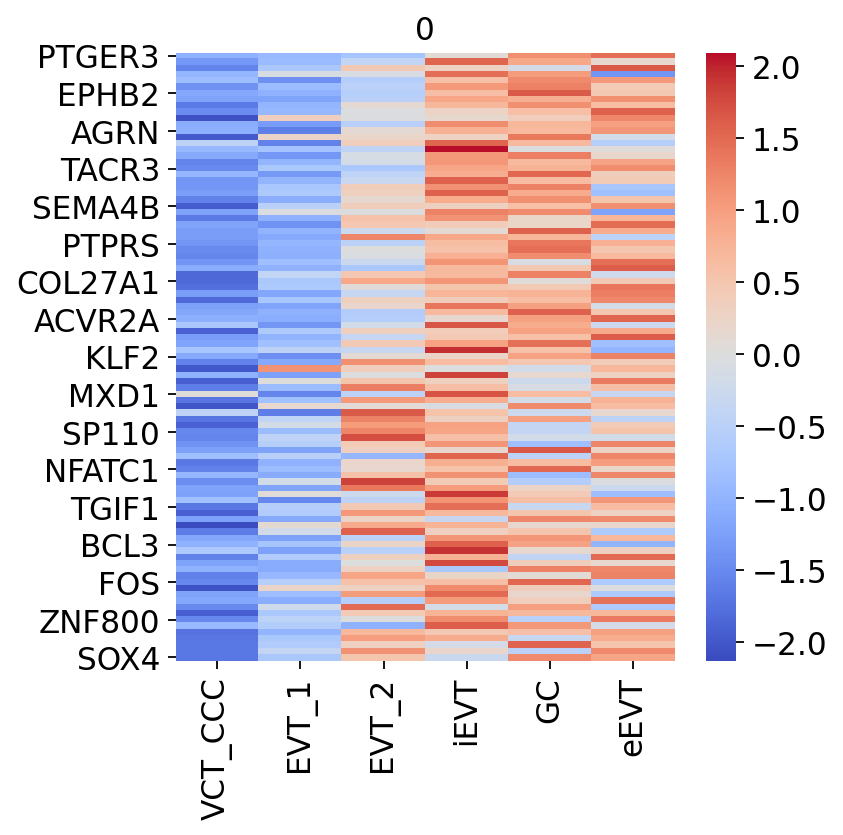

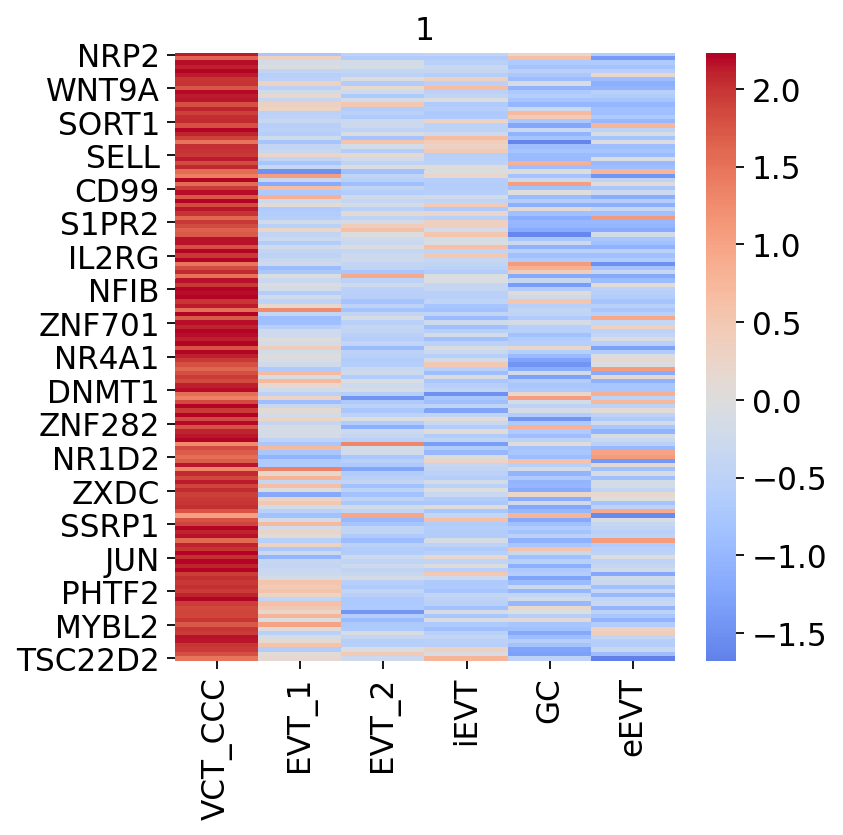

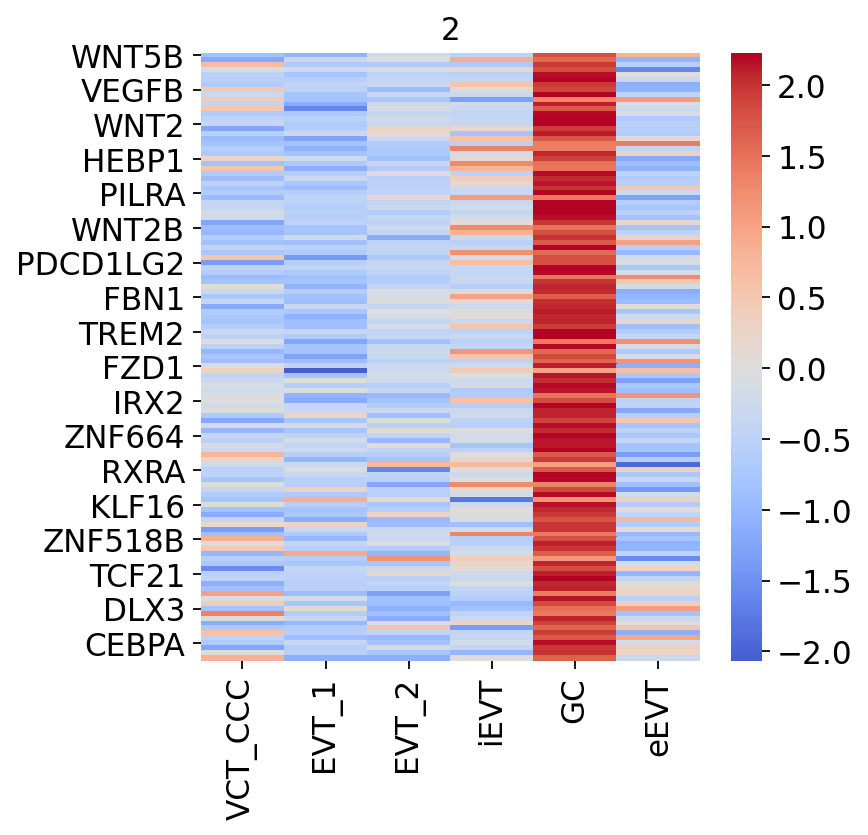

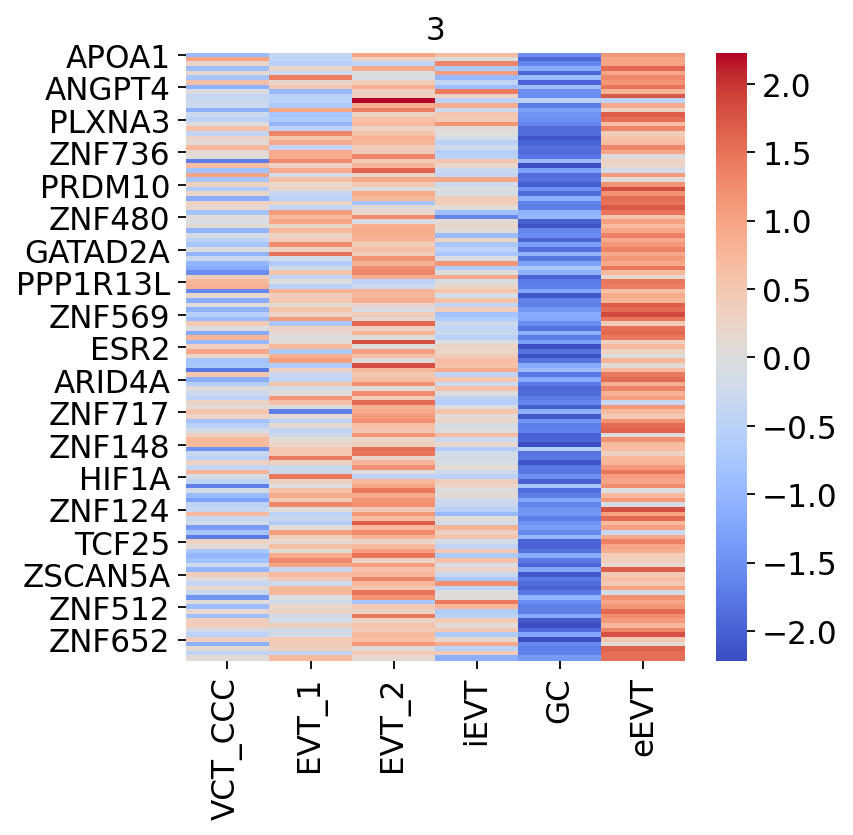

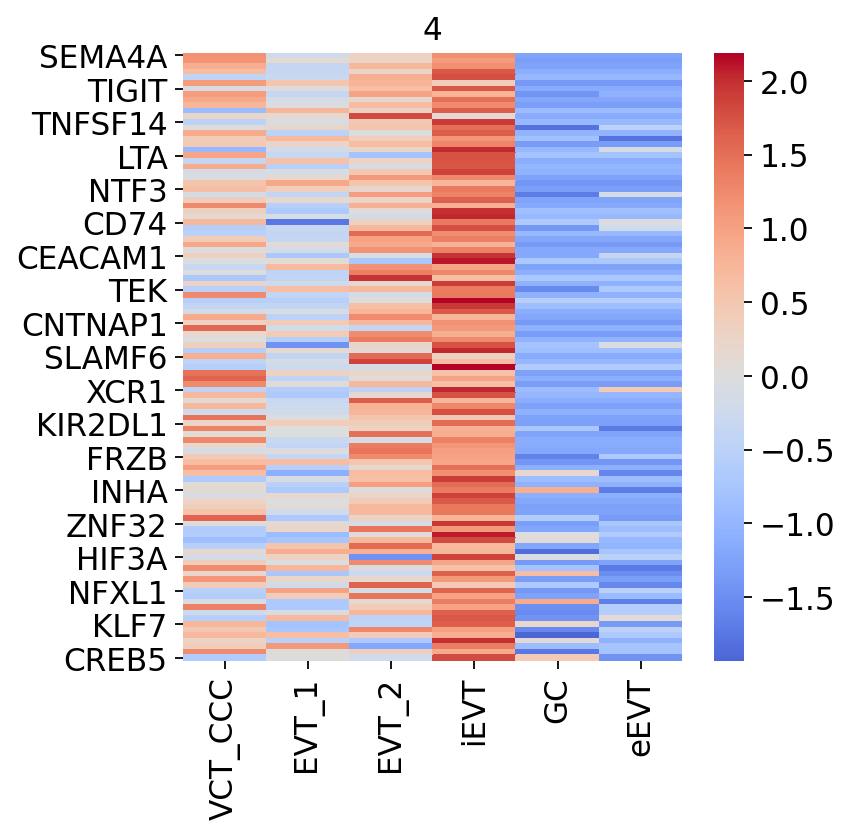

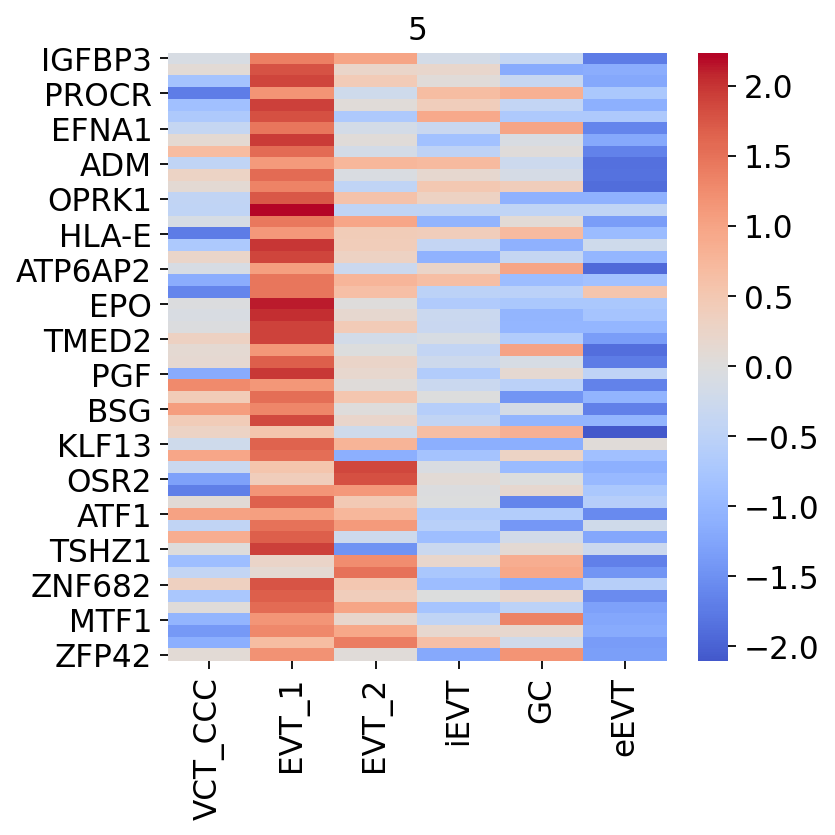

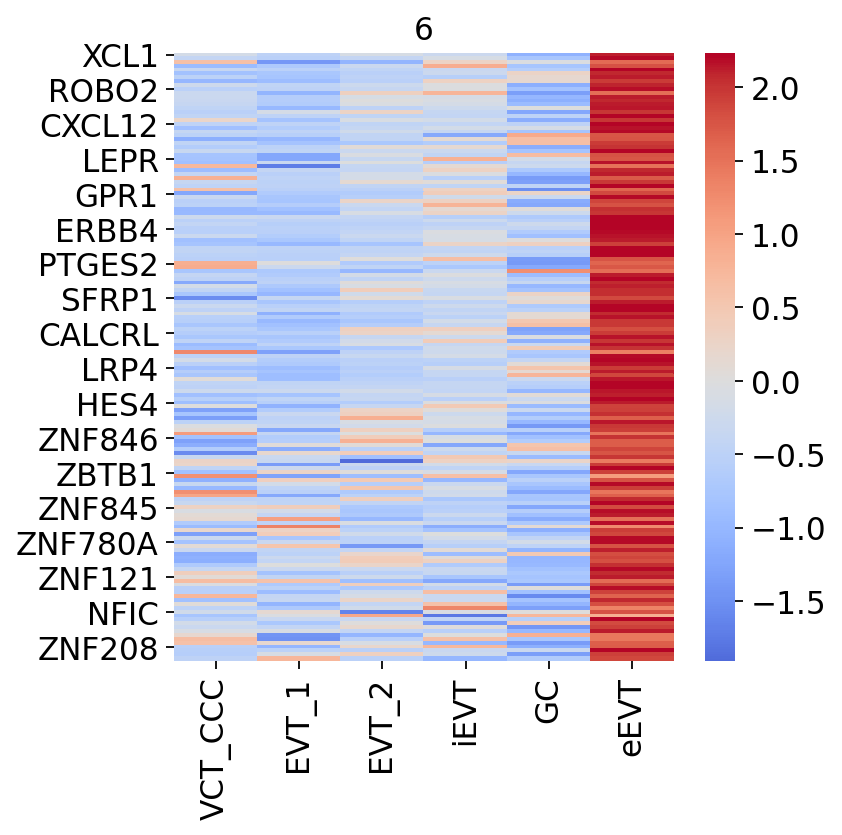

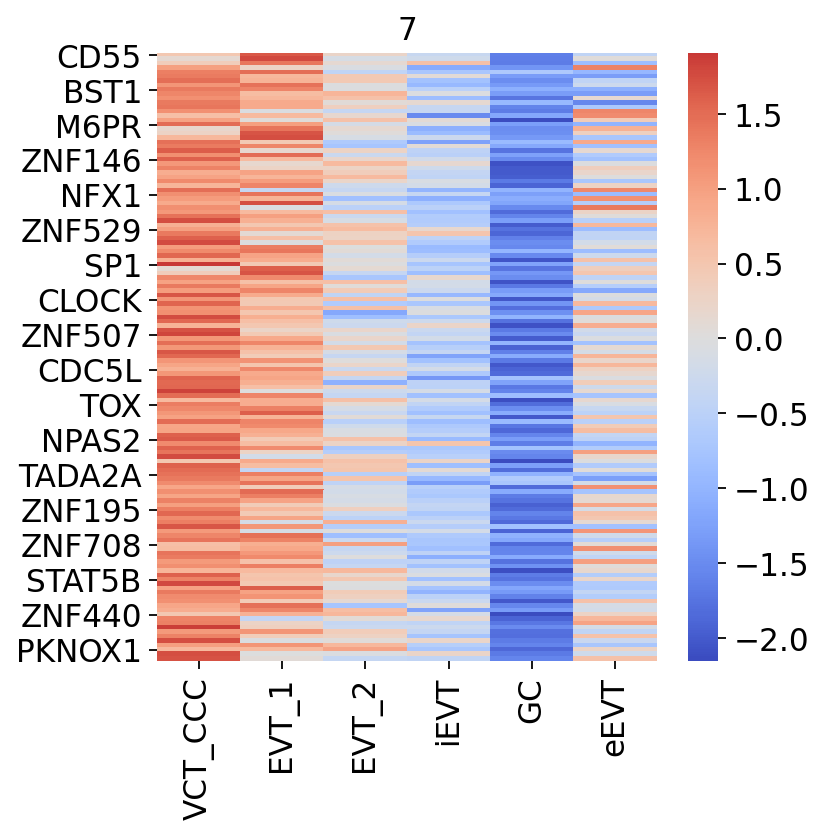

In [119]:
# with 8 clusters - looks better than with k=4
for cluster in np.unique(df_all2cluster['Cluster']):
    plt.figure(figsize=(5,5))
    plt.title(cluster)
    sns.heatmap(df_all2cluster[df_all2cluster['Cluster'] == cluster].loc[:,ct_in_order], 
                center=0, cmap='coolwarm')

In [120]:
# save for late
df_all2cluster.to_csv('./20220222_df_DE_TFs_and_LRs_clusters_logFC_top_10%_in_limma_for_TFs_donor_P13_only_TFs_but_LR_from_all_donors_analysis.csv')

# continue with the best clustering of TFs and produce heatmaps per ME

In [121]:
df_avg_expr_zscores

EVT_1     EVT_2        GC       VCT   VCT_CCC      eEVT      iEVT
E2F4     0.418397 -0.772973 -1.035422  0.434691  1.479087  0.887356 -1.411136
SOX6     0.348461 -0.765985 -0.978746  2.105580  0.396927 -0.809050 -0.297187
HES4    -0.432177 -0.471801  0.109326 -0.879903 -0.743977  2.287759  0.130772
ZBTB4   -0.520933 -0.617860 -0.554606  2.137986  0.783030 -0.839247 -0.388370
KLF13    1.827298  0.938276 -1.051893 -0.725863 -0.122239  0.182721 -1.048301
...           ...       ...       ...       ...       ...       ...       ...
BBX     -0.276293 -0.319522 -1.620039  1.656323  1.111421 -0.457730 -0.094160
ZNF354B -0.345684 -0.529135 -1.039409  2.254636  0.343192 -0.135244 -0.548355
ZNF345  -0.513219  0.431226 -1.852033  0.429509 -0.514885  1.571861  0.447542
SOX4    -0.348170  0.690459  1.288800 -1.465273 -1.215561  1.056588 -0.006843
ZBTB46   0.254936 -0.166489 -1.335617  1.722656 -0.228982  0.894849 -1.141353

[539 rows x 7 columns]

In [122]:
df_TF_clusters = pd.read_csv('./20220222_df_DE_TFs_and_LRs_clusters_logFC_top_10%_in_limma_for_TFs_donor_P13_only_TFs_but_LR_from_all_donors_analysis.csv',
                            index_col=0)

In [123]:
len(df_TF_clusters.index)

953

In [124]:
len(set(df_TF_clusters.index))

951

In [125]:
# ESR2 is duplicated = need to drop one of the rows
df_TF_clusters.loc['ESR2']

VCT_CCC     EVT_1     EVT_2      eEVT     iEVT        GC  Cluster
ESR2 -0.797078 -0.951390 -0.774190  1.916777  0.26706  0.338820        6
ESR2  0.354310  0.750569  0.054371  0.725944  0.28300 -2.168195        3

In [126]:
df_TF_clusters['gene'] = df_TF_clusters.index

In [127]:
df_TF_clusters = df_TF_clusters.drop_duplicates(subset = 'gene')
df_TF_clusters = df_TF_clusters.drop('gene',axis=1)
df_TF_clusters

VCT_CCC     EVT_1     EVT_2      eEVT      iEVT        GC  Cluster
SEMA4A   1.165016 -0.207710  0.303852 -1.234541  1.207925 -1.234541        4
DLL4     1.149927  0.125704  0.270147 -1.310287  1.074795 -1.310287        4
XCL1    -0.169101 -0.468486 -0.123487  2.119979 -0.280046 -1.078860        6
TGFB3   -0.385592 -0.542178 -0.395036  2.195083 -0.117953 -0.754324        6
WNT5B   -0.849703 -1.049138 -0.206797  0.793643 -0.493789  1.805783        2
...           ...       ...       ...       ...       ...       ...      ...
BBX      1.743594 -0.000300 -0.054625 -0.228306  0.228580 -1.688942        7
ZNF354B  1.703004  0.071272 -0.363268  0.569737 -0.408795 -1.571948        7
ZNF345  -0.416875 -0.415308  0.472838  1.545479  0.488182 -1.674315        3
SOX4    -1.686513 -0.684393  0.515560  0.938558 -0.290050  1.206838        0
ZBTB46   0.075697  0.705895  0.157082  1.539243 -1.112466 -1.365452        3

[951 rows x 7 columns]

In [128]:
len(set(df_TF_clusters.index))

951

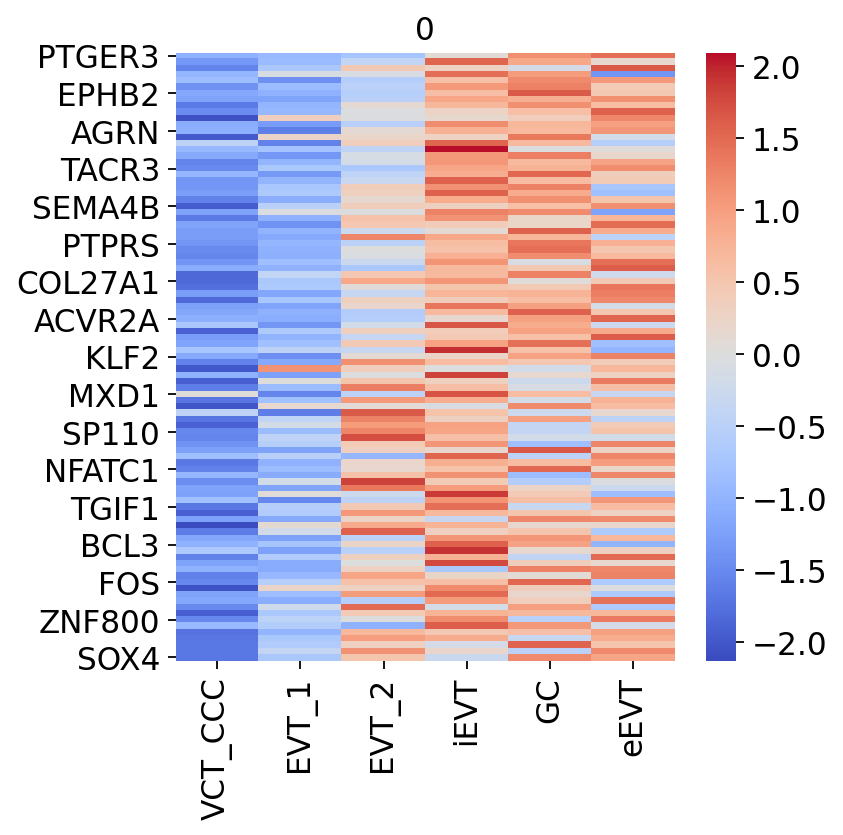

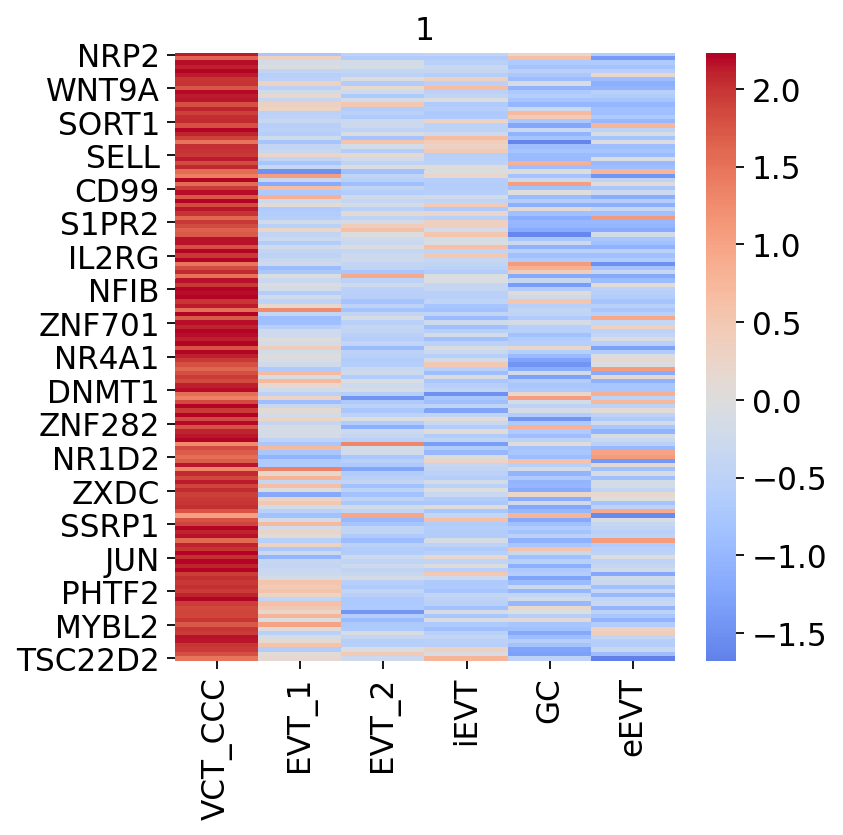

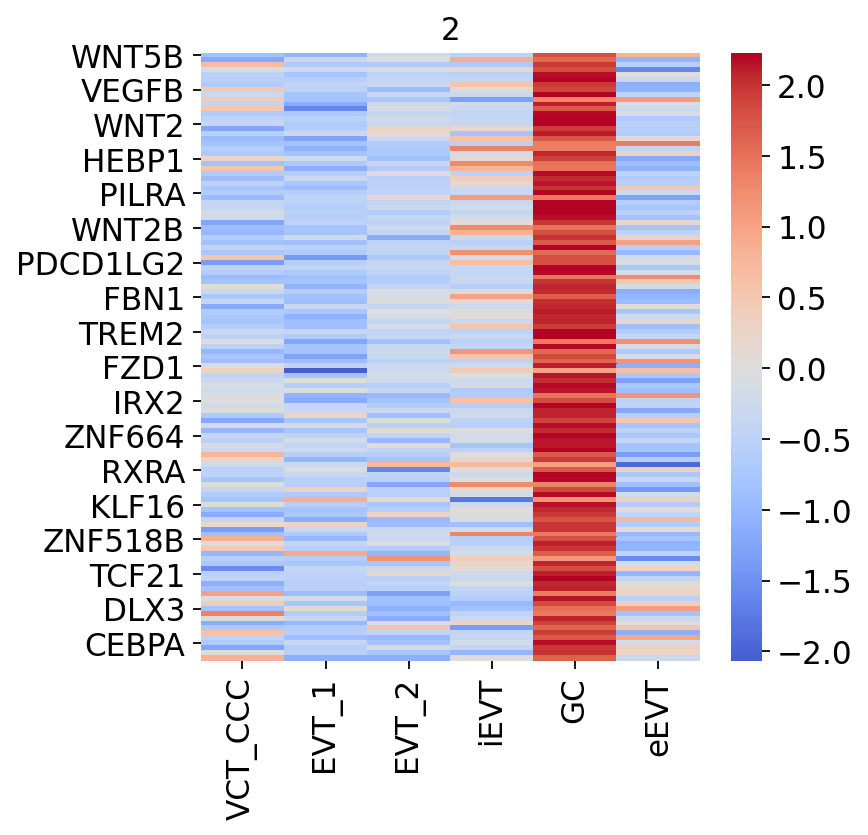

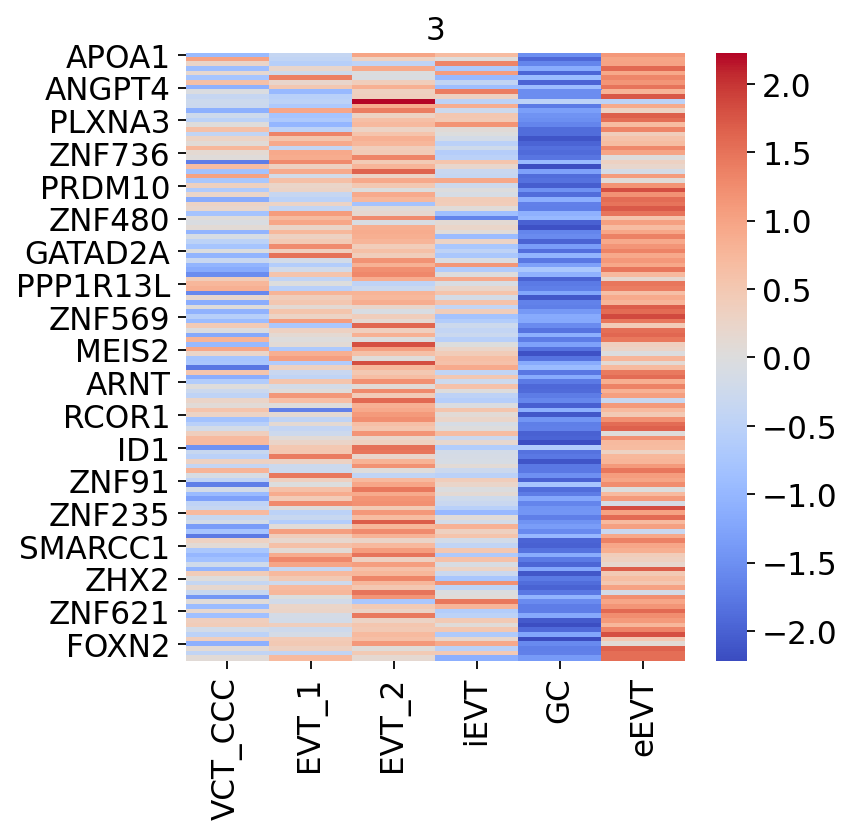

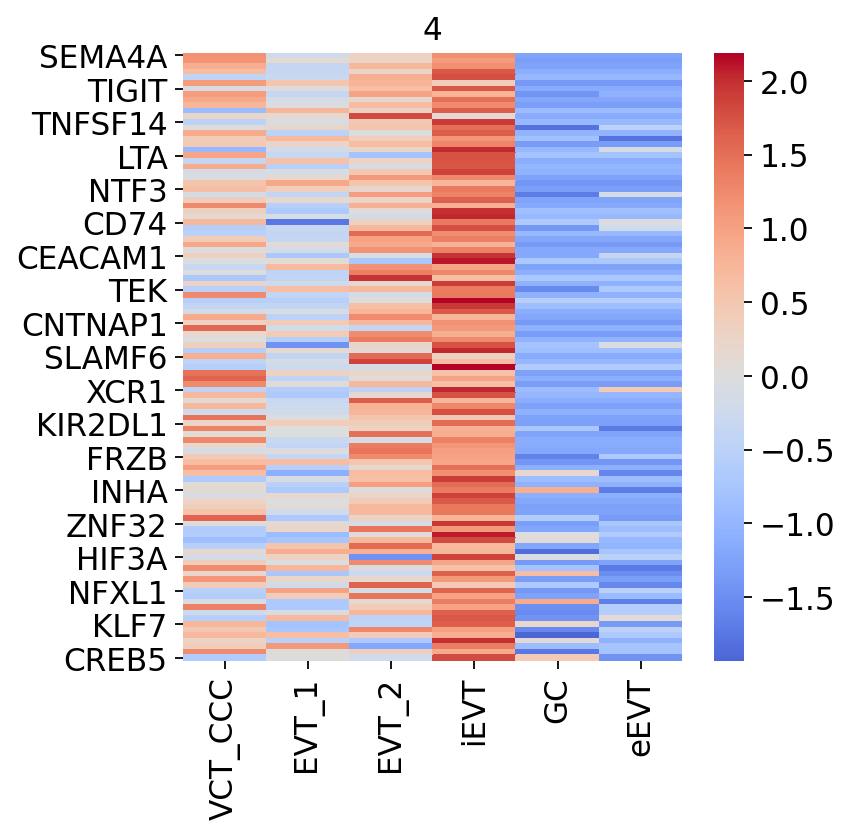

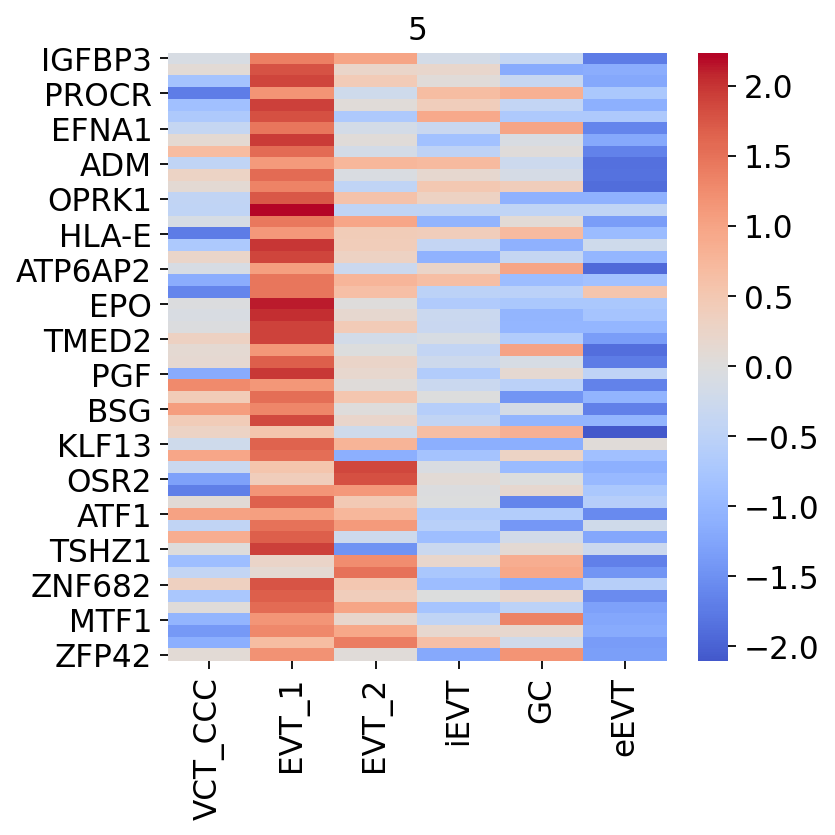

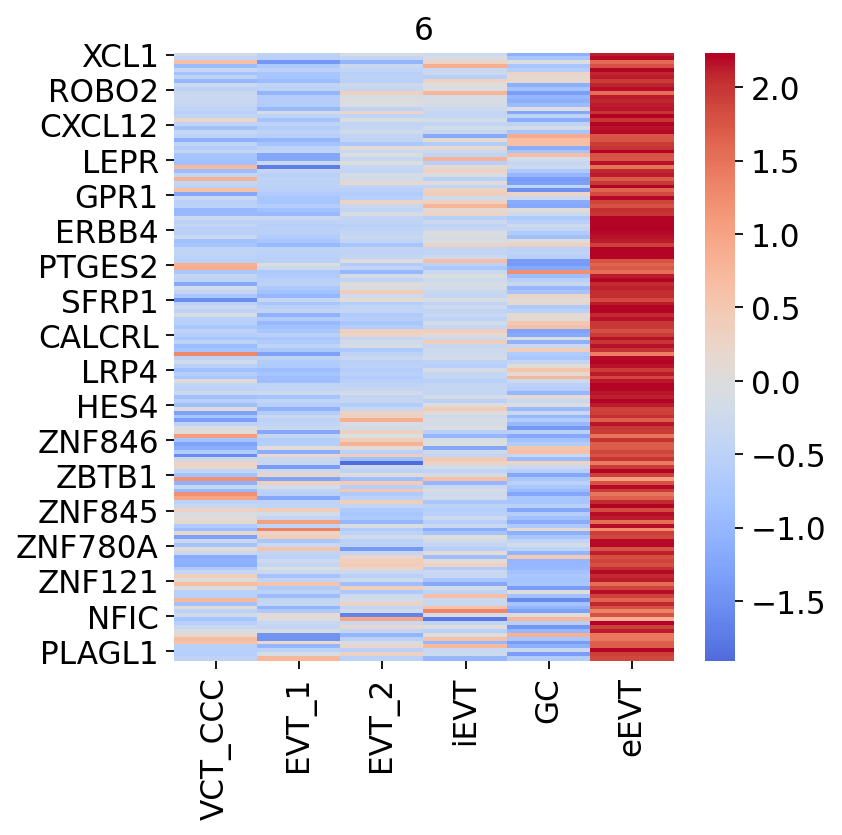

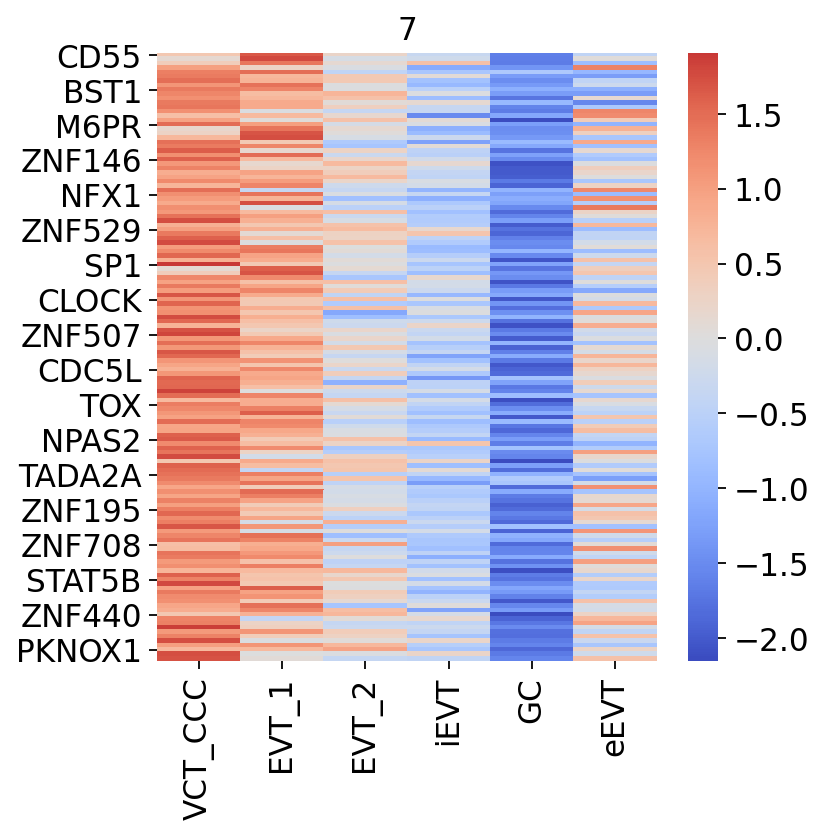

In [129]:
# with 8 clusters - looks better than with k=4
for cluster in np.unique(df_TF_clusters['Cluster']):
    plt.figure(figsize=(5,5))
    plt.title(cluster)
    sns.heatmap(df_TF_clusters[df_TF_clusters['Cluster'] == cluster].loc[:,ct_in_order], 
                center=0, cmap='coolwarm')

# cluster 0 here is ambiguous - going to disregard those genes since they are not specific to either eEVT or GC branches of the trajectory

In [130]:
# assignment of clusters to MEs upon visual inspection
cluster2ME = {}

# MEs: ME_1_early_inv_column, ME_2_inv_front, ME_3_fusion and ME_4_artery_remodelling

cluster2ME[0.0] = 'ambiguous' 
cluster2ME[1.0] = 'ME_1_early_inv_column'
cluster2ME[2.0] = 'ME_3_fusion' # pattern looks pretty similar to ME3 pattern from all-donors analysis
cluster2ME[3.0] = 'ME_2_inv_front'
cluster2ME[4.0] = 'ME_2_inv_front'
cluster2ME[5.0] = 'ME_2_inv_front'
cluster2ME[6.0] = 'ME_4_artery_remodelling'
cluster2ME[7.0] = 'ME_1_early_inv_column'

In [131]:
MEs = ['ME_1_early_inv_column','ME_2_inv_front','ME_3_fusion','ME_4_artery_remodelling']

In [132]:
df_avg_expr_zscores

EVT_1     EVT_2        GC       VCT   VCT_CCC      eEVT      iEVT
E2F4     0.418397 -0.772973 -1.035422  0.434691  1.479087  0.887356 -1.411136
SOX6     0.348461 -0.765985 -0.978746  2.105580  0.396927 -0.809050 -0.297187
HES4    -0.432177 -0.471801  0.109326 -0.879903 -0.743977  2.287759  0.130772
ZBTB4   -0.520933 -0.617860 -0.554606  2.137986  0.783030 -0.839247 -0.388370
KLF13    1.827298  0.938276 -1.051893 -0.725863 -0.122239  0.182721 -1.048301
...           ...       ...       ...       ...       ...       ...       ...
BBX     -0.276293 -0.319522 -1.620039  1.656323  1.111421 -0.457730 -0.094160
ZNF354B -0.345684 -0.529135 -1.039409  2.254636  0.343192 -0.135244 -0.548355
ZNF345  -0.513219  0.431226 -1.852033  0.429509 -0.514885  1.571861  0.447542
SOX4    -0.348170  0.690459  1.288800 -1.465273 -1.215561  1.056588 -0.006843
ZBTB46   0.254936 -0.166489 -1.335617  1.722656 -0.228982  0.894849 -1.141353

[539 rows x 7 columns]

In [133]:
df_avg_expr_zscores_no_VCT

VCT_CCC     EVT_1     EVT_2      iEVT        GC      eEVT
E2F4     1.459610  0.461764 -0.659020 -1.259373 -0.905919  0.902938
SOX6     1.355036  1.267221 -0.752034  0.097377 -1.137535 -0.830064
HES4    -0.883534 -0.574217 -0.613526 -0.015752 -0.037027  2.124055
ZBTB4    2.161451 -0.312262 -0.496140 -0.060781 -0.376141 -0.916127
KLF13   -0.235764  1.654038  0.792256 -1.133450 -1.136932  0.059852
...           ...       ...       ...       ...       ...       ...
BBX      1.743594 -0.000300 -0.054625  0.228580 -1.688942 -0.228306
ZNF354B  1.703004  0.071272 -0.363268 -0.408795 -1.571948  0.569737
ZNF345  -0.416875 -0.415308  0.472838  0.488182 -1.674315  1.545479
SOX4    -1.686513 -0.684393  0.515560 -0.290050  1.206838  0.938558
ZBTB46   0.075697  0.705895  0.157082 -1.112466 -1.365452  1.539243

[539 rows x 6 columns]

In [135]:
# lists of TFs corresponding to patterns of expression in MEs
MEs_TFs = {}

# through EVT_1?
alt_eEVT_route = []

# through EVT_2
main_eEVT_route = []

patterns = []

for ME in MEs:
    print(ME)
    MEs_TFs[ME] = []
    
    for TF in list(df_avg_expr_zscores_no_VCT.index):
        curr_pattern = str(list(df_avg_expr_zscores_no_VCT.loc[TF][df_avg_expr_zscores_no_VCT.loc[TF] > 0].index))
        
        patterns.append(curr_pattern)
        #print('curr_pattern', curr_pattern)
        
        if curr_pattern in ["['EVT_1', 'eEVT']","['VCT_CCC', 'EVT_1', 'eEVT']"]:
            alt_eEVT_route.append(TF)
        elif curr_pattern in [
            # 2-ct chunks of eEVT streak
            "['EVT_2', 'eEVT']",
            # 3-ct chunks of eEVT streak
            "['EVT_1', 'EVT_2', 'eEVT']",
            # 4-ct chunks of eEVT streak
            "['VCT_CCC', 'EVT_1', 'EVT_2', 'eEVT']",]:
            main_eEVT_route.append(TF)
        
        curr_TF_cluster = df_TF_clusters.loc[TF,'Cluster']
        
        print(type(curr_TF_cluster))
        
        ME_from_curr_TF_cluster = cluster2ME[curr_TF_cluster]
        
        if ME_from_curr_TF_cluster == ME:
            print(TF)
            # which comparison is this TF coming from?
            #for comparison in comparisons:
                #print(comparison)
                #curr_comparison_TFs = [elem.split('-')[-1] for elem in list(TFs_to_visualise_dfs_scaled[comparison].index)]
                #if TF in curr_comparison_TFs:
                    #curr_comparison = comparison

            #print('this TF is coming from comparison:', curr_comparison)

            print('appending current TF to ME', )
            MEs_TFs[ME].append(TF)
            
    print('here picking up', len(MEs_TFs[ME]), 'TFs')
    print('\n')

ME_1_early_inv_column
<class 'numpy.int64'>
E2F4
appending current TF to ME
<class 'numpy.int64'>
SOX6
appending current TF to ME
<class 'numpy.int64'>
<class 'numpy.int64'>
ZBTB4
appending current TF to ME
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
ZNF780B
appending current TF to ME
<class 'numpy.int64'>
<class 'numpy.int64'>
CTCF
appending current TF to ME
<class 'numpy.int64'>
ZNF146
appending current TF to ME
<class 'numpy.int64'>
MGA
appending current TF to ME
<class 'numpy.int64'>
<class 'numpy.int64'>
ZFX
appending current TF to ME
<class 'numpy.int64'>
<class 'numpy.int64'>
ZNF138
appending current TF to ME
<class 'numpy.int64'>
ZNF565
appending current TF to ME
<class 'numpy.int64'>
NFIB
appending current TF to ME
<class 'numpy.int64'>
DNAJC2
appending current TF to ME
<class 'numpy.int64'>
MSX2
appending current TF to ME
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<c

In [136]:
alt_eEVT_route = list(set(alt_eEVT_route))
len(alt_eEVT_route)

38

In [137]:
alt_eEVT_route

['HIC2',
 'THRB',
 'ZNF347',
 'JDP2',
 'E2F4',
 'PPP1R13L',
 'PPARD',
 'ZNF766',
 'NFATC3',
 'DMTF1',
 'ZNF398',
 'HMGXB4',
 'ZBTB44',
 'NFIA',
 'HSF1',
 'ZNF429',
 'ZNF761',
 'ZNF845',
 'RORA',
 'CREBZF',
 'TP53',
 'TFDP2',
 'CDC5L',
 'PBX3',
 'AEBP2',
 'ZNF644',
 'HIF1A',
 'GMEB1',
 'NR2C1',
 'ZNF823',
 'MIER1',
 'SP3',
 'KLF3',
 'NFE2L2',
 'ZNF354B',
 'NR3C2',
 'SREBF2',
 'ZC3H8']

In [138]:
main_eEVT_route = list(set(main_eEVT_route))
len(main_eEVT_route)

82

In [139]:
main_eEVT_route

['ZBTB1',
 'ARNT',
 'ZNF654',
 'ZNF836',
 'KLF13',
 'RERE',
 'ZNF780B',
 'TCF25',
 'SMARCC1',
 'NFYB',
 'ZNF43',
 'ZNF138',
 'GATAD2A',
 'ZNF565',
 'USF1',
 'NR6A1',
 'DNAJC2',
 'GATAD2B',
 'ZNF26',
 'ELF1',
 'TFAP2A',
 'PRDM5',
 'RREB1',
 'ARID4B',
 'ZNF254',
 'LRRFIP1',
 'ZNF528',
 'ZSCAN5A',
 'ZNF562',
 'STAT5B',
 'ZHX2',
 'ZNF140',
 'TEAD2',
 'ZNF790',
 'ZNF736',
 'ZNF570',
 'ZNF431',
 'ZNF518A',
 'ZNF33A',
 'RUNX1',
 'ZNF621',
 'HOXB3',
 'ZNF578',
 'ZNF267',
 'ID1',
 'ZNF846',
 'ZNF487',
 'ESRRA',
 'SMARCC2',
 'ELK3',
 'NCOA2',
 'ZBED4',
 'ZNF274',
 'ZNF569',
 'ZNF714',
 'ZNF440',
 'ATRX',
 'ARID2',
 'ZNF577',
 'ATF6',
 'PRDM10',
 'TEAD3',
 'MYCN',
 'ZNF675',
 'AHRR',
 'ZNF215',
 'ZNF552',
 'ZNF124',
 'TFCP2',
 'ARID1A',
 'RFX1',
 'ZNF277',
 'ZNF613',
 'ZNF341',
 'ZNF451',
 'PKNOX1',
 'ZNF407',
 'ZNF611',
 'ZNF708',
 'ZNF813',
 'ZNF480',
 'ZBTB46']

In [140]:
MEs_TFs['ME_1_early_inv_column']

['E2F4',
 'SOX6',
 'ZBTB4',
 'ZNF780B',
 'CTCF',
 'ZNF146',
 'MGA',
 'ZFX',
 'ZNF138',
 'ZNF565',
 'NFIB',
 'DNAJC2',
 'MSX2',
 'ELF2',
 'TFEB',
 'THRB',
 'NFE2L3',
 'TFAP2C',
 'NFX1',
 'ZNF761',
 'NR2F2',
 'FOXM1',
 'ZNF257',
 'ELF5',
 'ZNF14',
 'ARNTL',
 'ZNF701',
 'ZNF267',
 'MECOM',
 'TP63',
 'HIC2',
 'ZFAT',
 'MYBL1',
 'TRERF1',
 'GABPA',
 'BARX2',
 'CREM',
 'NR4A1',
 'POGZ',
 'ZNF577',
 'ZNF529',
 'ZNF83',
 'RFX7',
 'ZNF496',
 'ZC3H6',
 'ARNTL2',
 'ADNP2',
 'ZNF302',
 'ARID1A',
 'TET1',
 'ZFP14',
 'ZNF789',
 'FOSL1',
 'ZNF613',
 'SP1',
 'DNMT1',
 'ZNF341',
 'PRDM15',
 'GTF3A',
 'NR3C2',
 'IRF6',
 'ZNF292',
 'RERE',
 'ADNP',
 'GRHL3',
 'NR2C2',
 'ZNF331',
 'CLOCK',
 'ZNF823',
 'ZNF75A',
 'SREBF2',
 'NFIA',
 'TFDP1',
 'CREBZF',
 'ZNF75D',
 'TEAD4',
 'HMG20A',
 'NCOA3',
 'ZNF507',
 'MEIS1',
 'ZNF282',
 'ZNF90',
 'TBX3',
 'NCOA2',
 'ZNF721',
 'HSF1',
 'NFATC2',
 'E2F5',
 'ZNF714',
 'ATRX',
 'CDC5L',
 'ARID2',
 'TFCP2L1',
 'ZBTB37',
 'ZNF595',
 'ARID5B',
 'HMGXB4',
 'SNAPC4',
 'NR1D2'

In [141]:
for i in range(len(np.unique(patterns, return_counts=True)[0])):
    print(np.unique(patterns, return_counts=True)[0][i], np.unique(patterns, return_counts=True)[1][i])

['EVT_1', 'EVT_2', 'GC', 'eEVT'] 12
['EVT_1', 'EVT_2', 'GC'] 16
['EVT_1', 'EVT_2', 'eEVT'] 96
['EVT_1', 'EVT_2', 'iEVT', 'GC', 'eEVT'] 4
['EVT_1', 'EVT_2', 'iEVT', 'GC'] 12
['EVT_1', 'EVT_2', 'iEVT', 'eEVT'] 92
['EVT_1', 'EVT_2', 'iEVT'] 24
['EVT_1', 'EVT_2'] 24
['EVT_1', 'GC', 'eEVT'] 12
['EVT_1', 'GC'] 8
['EVT_1', 'eEVT'] 8
['EVT_1', 'iEVT', 'GC'] 12
['EVT_1', 'iEVT', 'eEVT'] 16
['EVT_1', 'iEVT'] 8
['EVT_2', 'GC', 'eEVT'] 36
['EVT_2', 'GC'] 12
['EVT_2', 'eEVT'] 60
['EVT_2', 'iEVT', 'GC', 'eEVT'] 36
['EVT_2', 'iEVT', 'GC'] 52
['EVT_2', 'iEVT', 'eEVT'] 116
['EVT_2', 'iEVT'] 12
['GC', 'eEVT'] 32
['GC'] 52
['VCT_CCC', 'EVT_1', 'EVT_2', 'GC'] 4
['VCT_CCC', 'EVT_1', 'EVT_2', 'eEVT'] 172
['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT', 'eEVT'] 28
['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT'] 40
['VCT_CCC', 'EVT_1', 'EVT_2'] 116
['VCT_CCC', 'EVT_1', 'GC'] 24
['VCT_CCC', 'EVT_1', 'eEVT'] 144
['VCT_CCC', 'EVT_1', 'iEVT', 'eEVT'] 8
['VCT_CCC', 'EVT_1', 'iEVT'] 32
['VCT_CCC', 'EVT_1'] 228
['VCT_CCC', 'EVT_2', 'GC'

In [142]:
df_avg_expr_zscores = df_avg_expr_zscores.astype(float)

In [143]:
df_avg_expr_zscores = df_avg_expr_zscores.loc[:,['VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']]

In [144]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [145]:
# sorted by alphabet for ease of eye inspection
all_TFs_final = list(sorted(MEs_TFs['ME_1_early_inv_column']) + sorted(MEs_TFs['ME_2_inv_front']) + sorted(MEs_TFs['ME_3_fusion']) + sorted(MEs_TFs['ME_4_artery_remodelling']))
len(all_TFs_final)

490

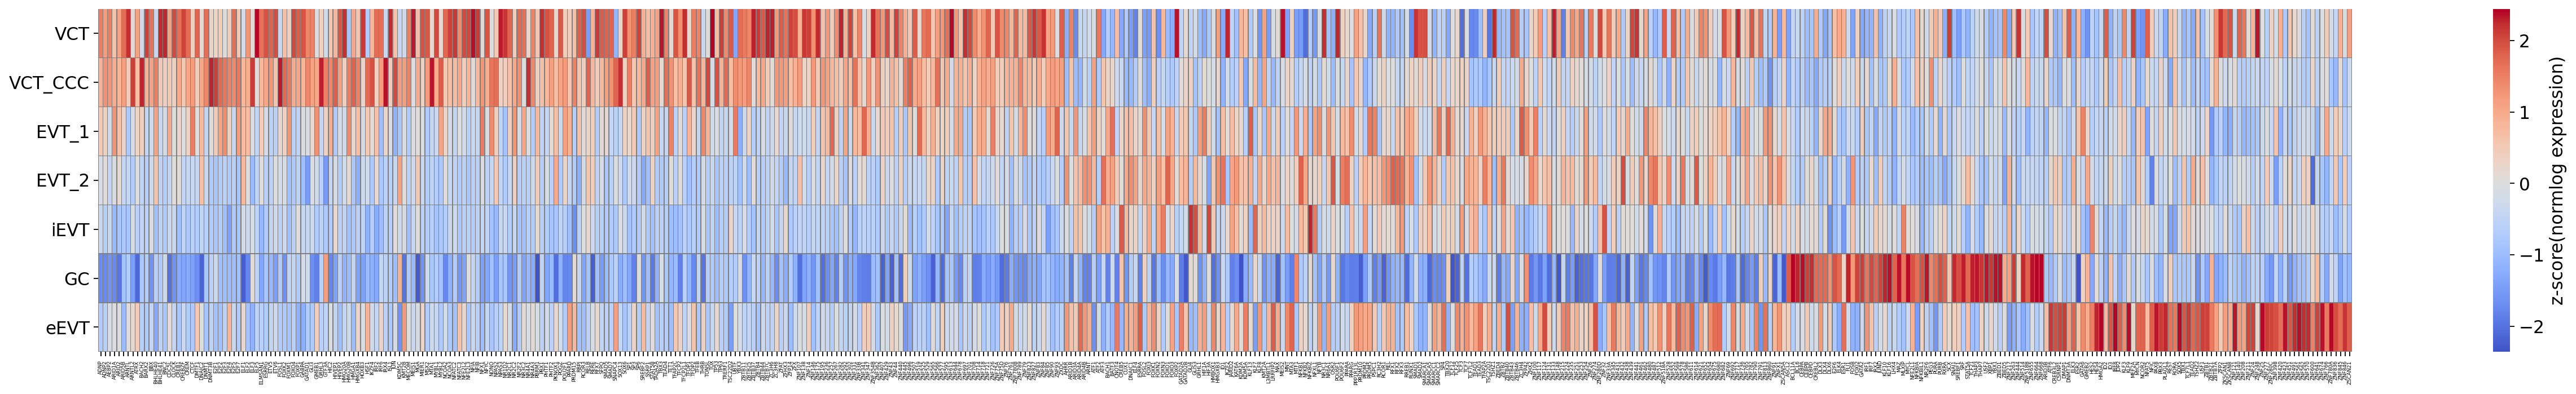

In [147]:
# all 4 MEs plotted together

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final,['VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
x = np.arange(0.5, len(all_TFs_final) + 0.5, 1)
plt.xticks(x, fontsize=4, labels = all_TFs_final)

# already saved
#plt.savefig('./figures/20220216_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL_logFC_cutoff_top_10%_in_limma.pdf', bbox_inches='tight')

plt.show()

In [152]:
MEs

['ME_1_early_inv_column',
 'ME_2_inv_front',
 'ME_3_fusion',
 'ME_4_artery_remodelling']

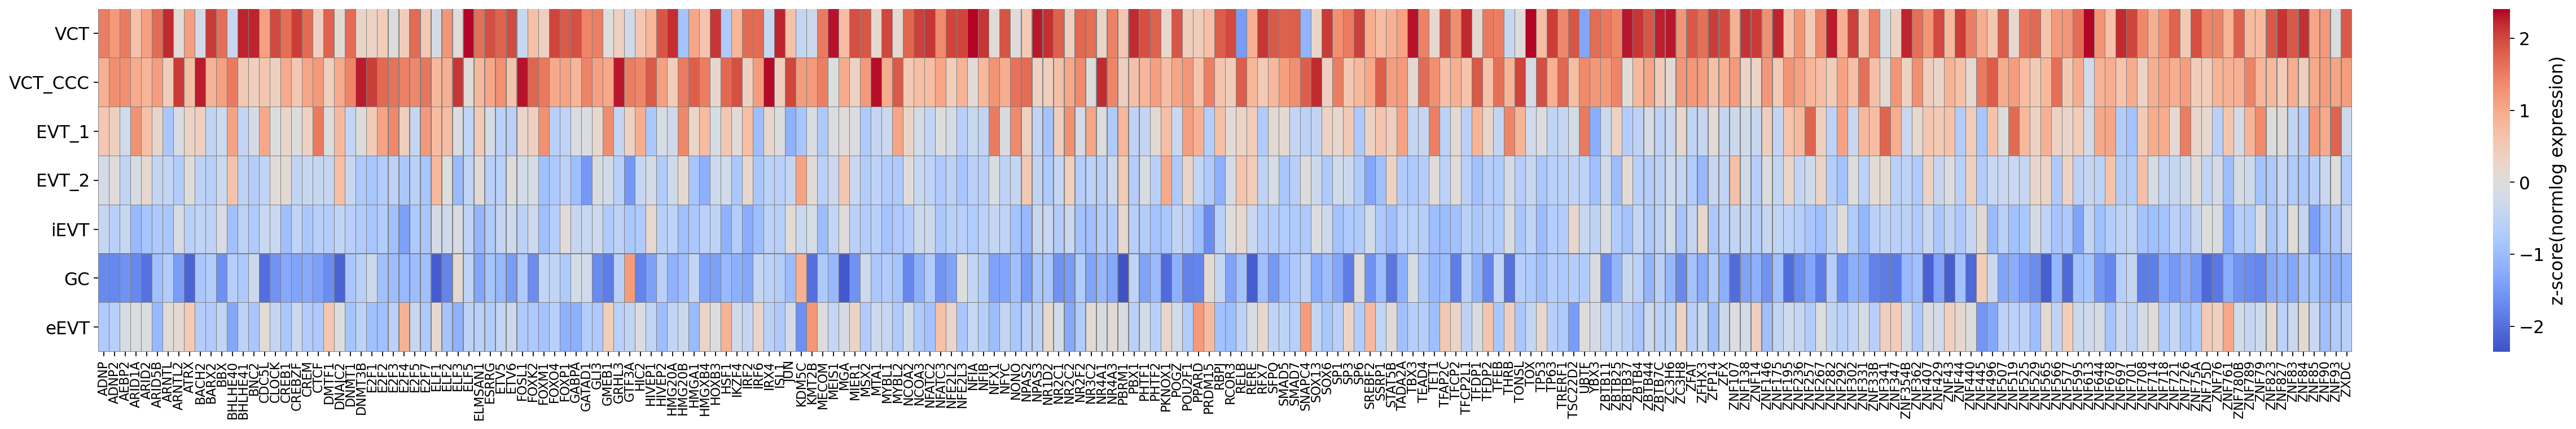

In [155]:
# per ME plots

curr_ME = 'ME_1_early_inv_column'

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[sorted(MEs_TFs[curr_ME]),['VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
x = np.arange(0.5, len(sorted(MEs_TFs[curr_ME])) + 0.5, 1)
plt.xticks(x, fontsize=10, labels = sorted(MEs_TFs[curr_ME]))

# already saved
plt.savefig('./figures/20220222_TF_expression_heatmap_zscores_in_vivo_ME_' + curr_ME + '_donor_P13_only_DE_TFs_logFC_cutoff_top_10%_in_limma.pdf', bbox_inches='tight')

plt.show()

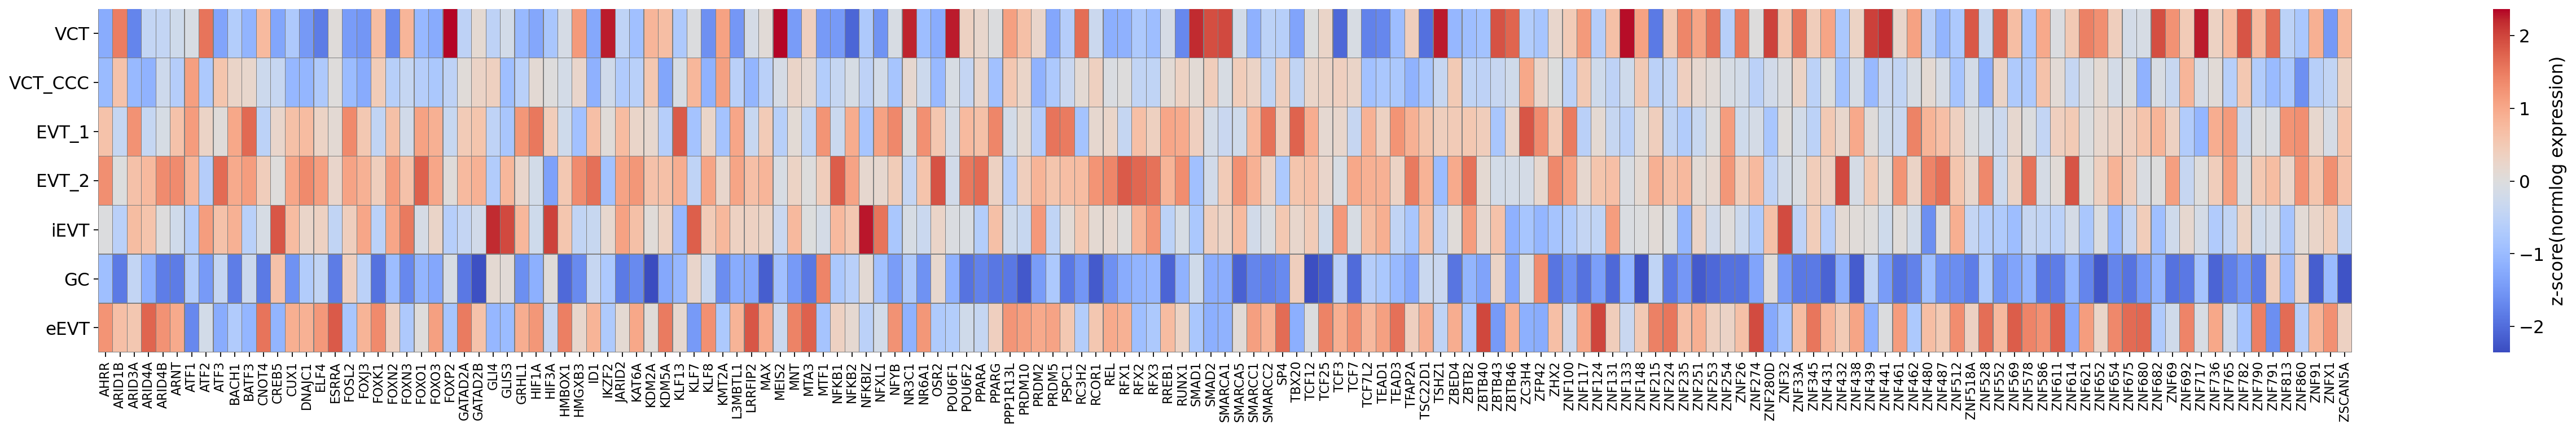

In [156]:
# per ME plots

curr_ME = 'ME_2_inv_front'

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[sorted(MEs_TFs[curr_ME]),['VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
x = np.arange(0.5, len(sorted(MEs_TFs[curr_ME])) + 0.5, 1)
plt.xticks(x, fontsize=10, labels = sorted(MEs_TFs[curr_ME]))

# already saved
plt.savefig('./figures/20220222_TF_expression_heatmap_zscores_in_vivo_ME_' + curr_ME + '_donor_P13_only_DE_TFs_logFC_cutoff_top_10%_in_limma.pdf', bbox_inches='tight')

plt.show()

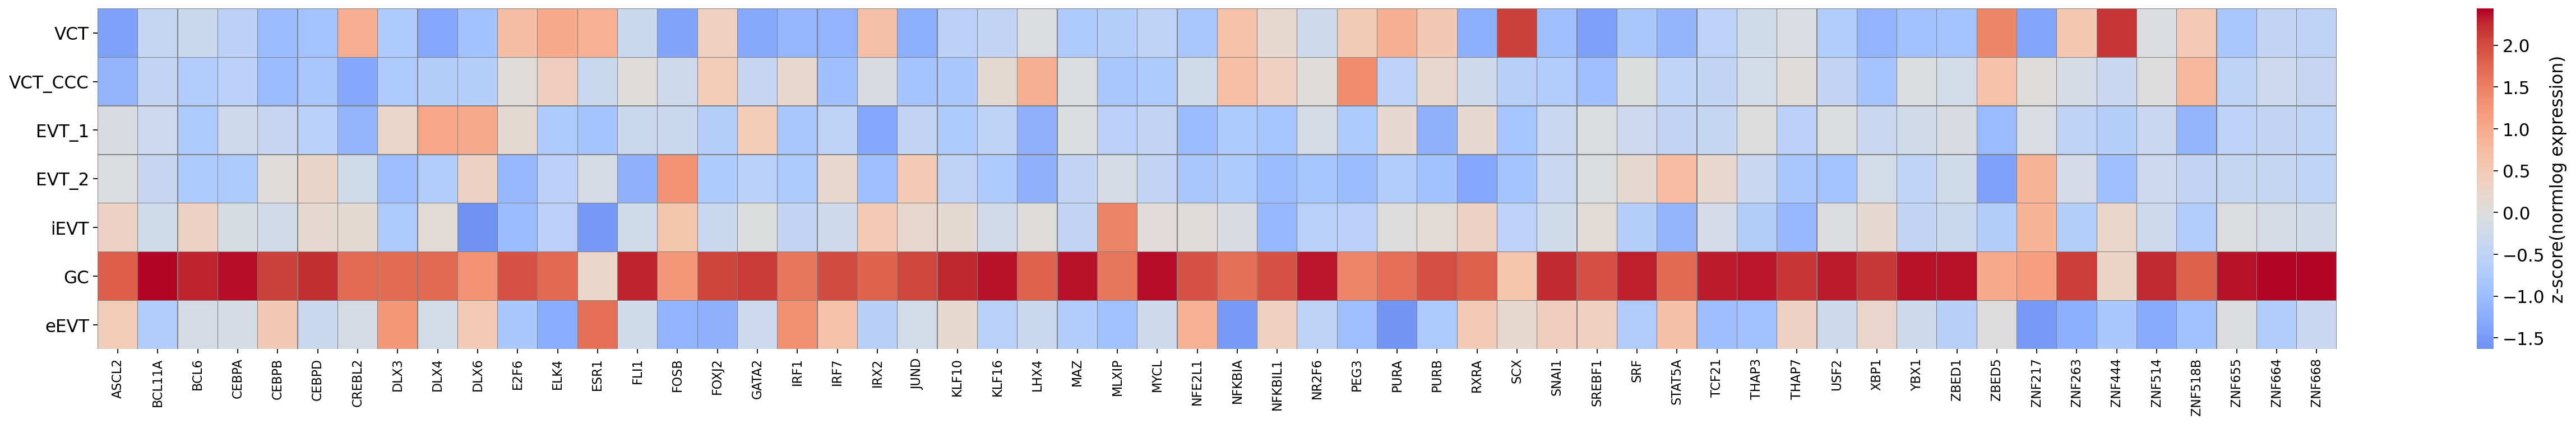

In [157]:
# per ME plots

curr_ME = 'ME_3_fusion'

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[sorted(MEs_TFs[curr_ME]),['VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
x = np.arange(0.5, len(sorted(MEs_TFs[curr_ME])) + 0.5, 1)
plt.xticks(x, fontsize=10, labels = sorted(MEs_TFs[curr_ME]))

# already saved
plt.savefig('./figures/20220222_TF_expression_heatmap_zscores_in_vivo_ME_' + curr_ME + '_donor_P13_only_DE_TFs_logFC_cutoff_top_10%_in_limma.pdf', bbox_inches='tight')

plt.show()

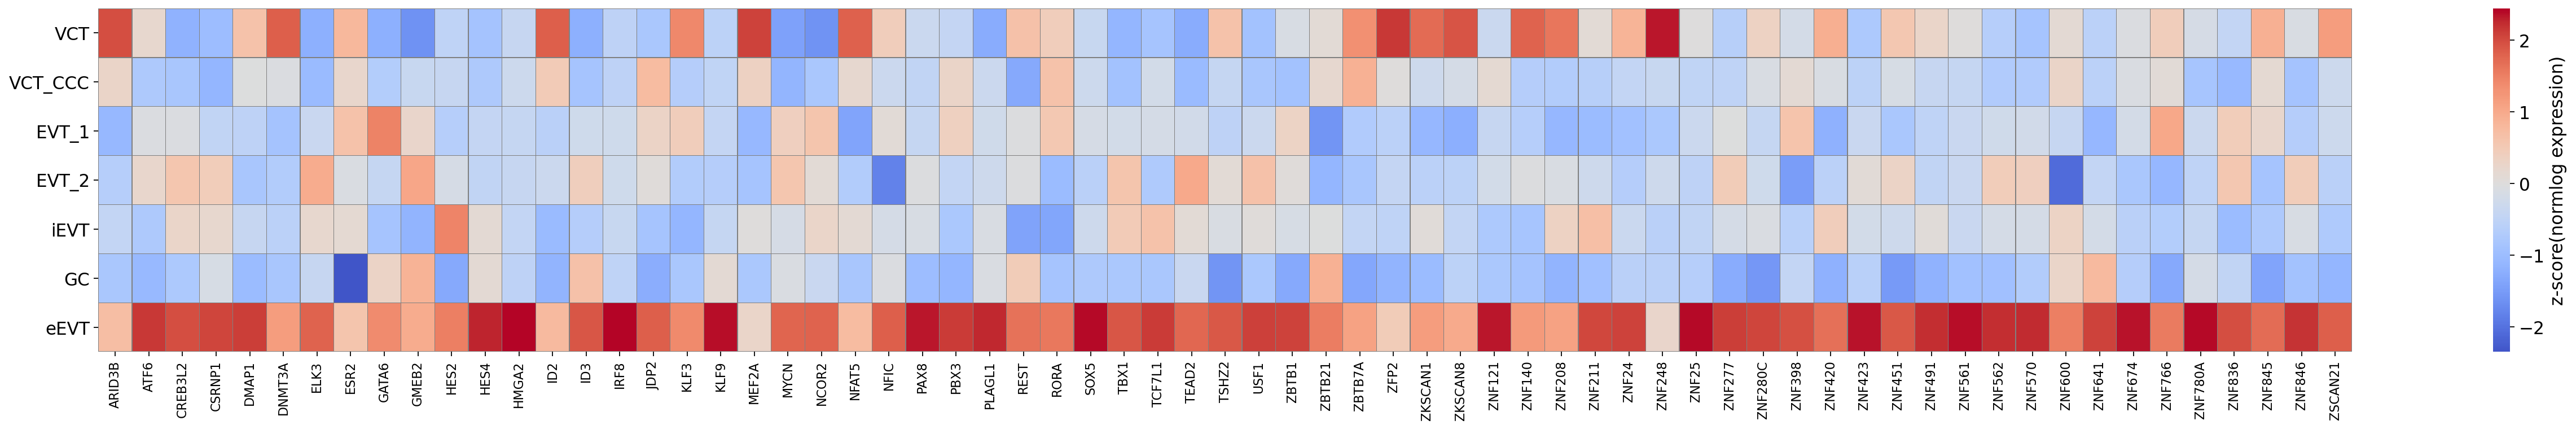

In [158]:
# per ME plots

curr_ME = 'ME_4_artery_remodelling'

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[sorted(MEs_TFs[curr_ME]),['VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(normlog expression)'}
             )
x = np.arange(0.5, len(sorted(MEs_TFs[curr_ME])) + 0.5, 1)
plt.xticks(x, fontsize=10, labels = sorted(MEs_TFs[curr_ME]))

# already saved
plt.savefig('./figures/20220222_TF_expression_heatmap_zscores_in_vivo_ME_' + curr_ME + '_donor_P13_only_DE_TFs_logFC_cutoff_top_10%_in_limma.pdf', bbox_inches='tight')

plt.show()

In [160]:
# also seeing overlap b/w these results and the ones for all donors)

all_TFs_final_df_all_donors = pd.read_csv('./20220216_final_TFs_df_plot_Fig2F_logFC_cutoff_top_10%_in_limma.csv', index_col=0)
all_TFs_final_df_all_donors

ME
ARID5B     ME_1_early_inv_column
ATF3       ME_1_early_inv_column
ATF4       ME_1_early_inv_column
BACH2      ME_1_early_inv_column
BATF3      ME_1_early_inv_column
...                          ...
ZNF793   ME_4_artery_remodelling
ZNF800   ME_4_artery_remodelling
ZNF814   ME_4_artery_remodelling
ZSCAN21  ME_4_artery_remodelling
ZXDC     ME_4_artery_remodelling

[251 rows x 1 columns]

In [161]:
MEs_TFs_all_donors = {}

for ME in MEs:
    MEs_TFs_all_donors[ME] = list(all_TFs_final_df_all_donors[all_TFs_final_df_all_donors['ME'] == ME].index)

In [164]:
for ME in MEs:
    print(ME)
    print('number of TFs in all donors analysis (DE + other evidence):', len(set(MEs_TFs_all_donors[ME])))
    print('number of TFs in donor P13 analysis (only DE):', len(set(MEs_TFs[ME])))

    print('overlap b/w TFs from all donors analysis and donro P13 only:', len(set(MEs_TFs_all_donors[ME]) & set(MEs_TFs[ME])) )
    print('overlapping TFs:', list(set(MEs_TFs_all_donors[ME]) & set(MEs_TFs[ME])))
    print('\n')

ME_1_early_inv_column
number of TFs in all donors analysis (DE + other evidence): 66
number of TFs in donor P13 analysis (only DE): 210
overlap b/w TFs from all donors analysis and donro P13 only: 34
overlapping TFs: ['ARID5B', 'TP63', 'IRX4', 'YBX3', 'E2F4', 'NFE2L3', 'JUN', 'E2F2', 'ZNF726', 'BACH2', 'TFDP1', 'GRHL3', 'ZNF146', 'ZBTB7C', 'CREM', 'FOSL1', 'NR2F2', 'FOXM1', 'NONO', 'SP6', 'E2F3', 'DNAJC2', 'ZNF175', 'SSRP1', 'ETV5', 'TONSL', 'TEAD4', 'BHLHE40', 'ESRRG', 'HMGA1', 'GTF3A', 'TFEB', 'IRF6', 'ELF3']


ME_2_inv_front
number of TFs in all donors analysis (DE + other evidence): 51
number of TFs in donor P13 analysis (only DE): 157
overlap b/w TFs from all donors analysis and donro P13 only: 6
overlapping TFs: ['KMT2A', 'ARNT', 'NFKB2', 'NFKBIZ', 'FOSL2', 'ZNF791']


ME_3_fusion
number of TFs in all donors analysis (DE + other evidence): 59
number of TFs in donor P13 analysis (only DE): 56
overlap b/w TFs from all donors analysis and donro P13 only: 9
overlapping TFs: ['ZNF444'

In [148]:
all_TFs_final_df = pd.DataFrame(index=all_TFs_final)
MEs_vec = [[ME for i in range(len(MEs_TFs[ME]))] for ME in MEs]
MEs_vec = [item for sublist in MEs_vec for item in sublist]
all_TFs_final_df['ME'] = MEs_vec
all_TFs_final_df

ME
ADNP       ME_1_early_inv_column
ADNP2      ME_1_early_inv_column
AEBP2      ME_1_early_inv_column
ARID1A     ME_1_early_inv_column
ARID2      ME_1_early_inv_column
...                          ...
ZNF780A  ME_4_artery_remodelling
ZNF836   ME_4_artery_remodelling
ZNF845   ME_4_artery_remodelling
ZNF846   ME_4_artery_remodelling
ZSCAN21  ME_4_artery_remodelling

[490 rows x 1 columns]

In [149]:
all_TFs_final_df.to_csv('./20220222_DE_TFs_in_donor_P13_logFC_cutoff_top_10%_in_limma.csv')

In [150]:
ct_in_order = ['VCT','VCT_CCC','EVT_1','EVT_2','iEVT','GC','eEVT']
df_avg_expr_zscores = df_avg_expr_zscores.loc[:,ct_in_order]

In [151]:
# simplifying this to mimic Luz&Valentina's code, will add MEFISTO-layer evidence later

df_TFs_evidence_per_ME = {}

# which comparisons was the TF prioritised through? and what was the sign (upreg or downreg)?
comparisons_per_TF = {}

# which comparisons was the TF prioritised through?
evidences_per_TF = {}

for ME in MEs:
    print(ME)
    df_TFs_evidence_per_ME[ME] = pd.DataFrame(index = MEs_TFs[ME],
                                         columns = list(df_avg_expr_zscores.columns))
    
    for TF in df_TFs_evidence_per_ME[ME].index:
        for comparison in comparisons:
            if TF in TFs_upregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_upreg'
                sign = '+'
                evidences_per_TF[TF] = list(TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'aM'
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'oM'
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*M'
                    
            
            elif TF in TFs_downregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_downreg'
                sign = '-'
                evidences_per_TF[TF] = list(TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'aM'
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'oM'
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*M'
                

ME_1_early_inv_column


NameError: name 'TFs_upregulated_per_comparison_both_DA_and_DE' is not defined

In [195]:
#df_TFs_evidence_per_ME['ME_1_early_inv_column']

In [196]:
# here for all MEs together
df_TFs_evidence_all = pd.concat(list(df_TFs_evidence_per_ME.values()))
df_TFs_evidence_all = df_TFs_evidence_all.loc[all_TFs_final]


In [197]:
df_TFs_evidence_all

VCT VCT_CCC EVT_1 EVT_2 iEVT   GC eEVT
ARID5B   NaN     NaN     a   NaN  NaN  NaN  NaN
ATF3     NaN     NaN     a   NaN  NaN  NaN  NaN
ATF4     NaN       a   NaN     a  NaN  NaN  NaN
BACH2    NaN     NaN    *M   NaN  NaN  NaN  NaN
BATF3    NaN       a   NaN   NaN  NaN  NaN  NaN
...      ...     ...   ...   ...  ...  ...  ...
ZNF793   NaN     NaN   NaN   NaN  NaN  NaN    a
ZNF800   NaN     NaN   NaN   NaN    a  NaN  NaN
ZNF814   NaN     NaN   NaN   NaN  NaN  NaN    a
ZSCAN21  NaN       a   NaN   NaN  NaN  NaN  NaN
ZXDC     NaN     NaN     a   NaN  NaN  NaN  NaN

[251 rows x 7 columns]

In [198]:
# here for all MEs together
coords_annotation_all = []

curr_df = df_TFs_evidence_all

for TF in curr_df.index:
    #print(TF)
    x_shift = 0.25 # should be consistent for all 4 heatmaps (per ME)
    curr_coord_x = x_shift + list(curr_df.index).index(TF) # x coordinate of TF
    #print(curr_coord_x)

    for ct in curr_df.columns:
        if str(curr_df.loc[TF,ct]) != 'nan':
            #print(TF, ct)
            y_shift = 0.7 # is different for different heatmaps (per ME)?
            curr_coord_y = y_shift + list(curr_df.columns).index(ct) # y coordinate of cell type
            coords_annotation_all.append([(curr_coord_x, curr_coord_y), curr_df.loc[TF,ct]])


In [199]:
# common color limits for all 4 heatmaps
common_max = np.max(df_avg_expr_zscores.values)
common_min = np.min(df_avg_expr_zscores.values)
common_min

-2.3049601173754564

In [200]:
df_avg_expr_zscores

VCT   VCT_CCC     EVT_1     EVT_2      iEVT        GC      eEVT
IRX3   -0.582820 -0.398678 -0.610493  0.023844  0.029588 -0.802925  2.341483
ZNF791  1.355151 -0.411871 -0.929961  0.519831  0.715511 -1.757323  0.508663
ZC3H6   1.650773 -0.712294 -1.369112 -0.967642  0.032560  0.575294  0.790421
ZNF90   1.210876  0.541080 -0.223276 -0.222635 -0.702761  1.192637 -1.795922
DNAJC2  0.447221  1.137774  1.217721  0.139665 -0.161744 -1.625884 -1.154752
...          ...       ...       ...       ...       ...       ...       ...
TCF4   -0.898085 -0.766662 -1.459169  0.184493  0.751957  0.601538  1.585929
GLIS2  -0.559901  2.030096 -0.741360 -0.304822  0.783744 -1.141976 -0.065781
RFX7    0.518999 -0.786381 -1.289496 -0.821624 -0.282371  1.608398  1.052475
E2F3    0.034544  2.193149 -0.740016 -0.459895 -1.189400  0.048854  0.112764
SOX7    0.292265  0.779547 -0.789986 -0.701079 -0.724766  1.988276 -0.844257

[339 rows x 7 columns]

In [201]:
# to enable adobe illustrator to recognise the text as editable text object
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


In [202]:
df_avg_expr_zscores

VCT   VCT_CCC     EVT_1     EVT_2      iEVT        GC      eEVT
IRX3   -0.582820 -0.398678 -0.610493  0.023844  0.029588 -0.802925  2.341483
ZNF791  1.355151 -0.411871 -0.929961  0.519831  0.715511 -1.757323  0.508663
ZC3H6   1.650773 -0.712294 -1.369112 -0.967642  0.032560  0.575294  0.790421
ZNF90   1.210876  0.541080 -0.223276 -0.222635 -0.702761  1.192637 -1.795922
DNAJC2  0.447221  1.137774  1.217721  0.139665 -0.161744 -1.625884 -1.154752
...          ...       ...       ...       ...       ...       ...       ...
TCF4   -0.898085 -0.766662 -1.459169  0.184493  0.751957  0.601538  1.585929
GLIS2  -0.559901  2.030096 -0.741360 -0.304822  0.783744 -1.141976 -0.065781
RFX7    0.518999 -0.786381 -1.289496 -0.821624 -0.282371  1.608398  1.052475
E2F3    0.034544  2.193149 -0.740016 -0.459895 -1.189400  0.048854  0.112764
SOX7    0.292265  0.779547 -0.789986 -0.701079 -0.724766  1.988276 -0.844257

[339 rows x 7 columns]

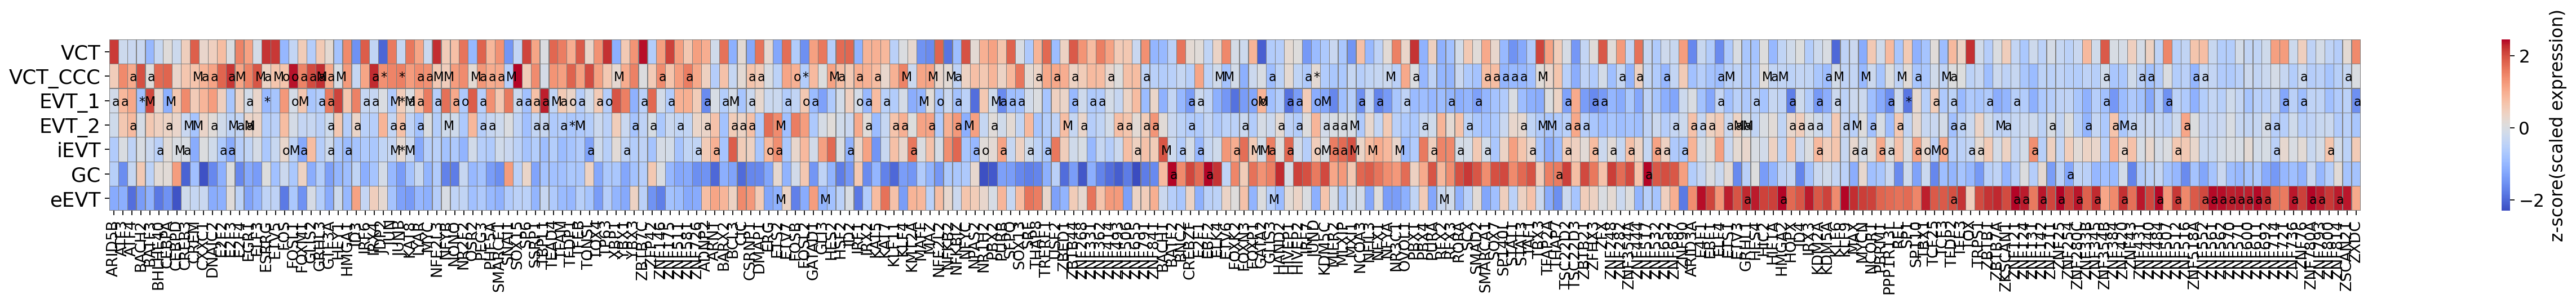

In [203]:
# playing a bit with the plotting here

# all MEs?

#curr_ME = 'ME_1_early_inv_column'

TFs2plot = all_TFs_final

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_all)):
    plt.annotate(coords_annotation_all[i][1], coords_annotation_all[i][0], fontsize=10)

#plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


In [204]:
np.unique(df_TFs_evidence_per_ME['ME_1_early_inv_column']['VCT'])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan], dtype=object)

In [205]:
df_TFs_evidence_per_ME['ME_1_early_inv_column'].loc[sorted(MEs_TFs['ME_1_early_inv_column'])]

VCT VCT_CCC EVT_1 EVT_2 iEVT   GC eEVT
ARID5B  NaN     NaN     a   NaN  NaN  NaN  NaN
ATF3    NaN     NaN     a   NaN  NaN  NaN  NaN
ATF4    NaN       a   NaN     a  NaN  NaN  NaN
BACH2   NaN     NaN    *M   NaN  NaN  NaN  NaN
BATF3   NaN       a   NaN   NaN  NaN  NaN  NaN
...     ...     ...   ...   ...  ...  ...  ...
ZNF146  NaN       a   NaN   NaN  NaN  NaN  NaN
ZNF175  NaN     NaN     a   NaN  NaN  NaN  NaN
ZNF511  NaN     NaN   NaN     a  NaN  NaN  NaN
ZNF581  NaN       a   NaN   NaN  NaN  NaN  NaN
ZNF726  NaN     NaN   NaN   NaN    a  NaN  NaN

[66 rows x 7 columns]

In [206]:
coords_annotation_per_ME = {}

for ME in MEs:
    print(ME)
    curr_df = df_TFs_evidence_per_ME[ME].loc[sorted(MEs_TFs[ME])]

    # coordinates where we want to add text annotation + annotation
    # [(float,float), str]
    coords_annotation_per_ME[ME] = []

    for TF in curr_df.index:
        #print(TF)
        x_shift = 0.25 # should be consistent for all 4 heatmaps (per ME)
        curr_coord_x = x_shift + list(curr_df.index).index(TF) # x coordinate of TF
        #print(curr_coord_x)

        for ct in curr_df.columns:
            if str(curr_df.loc[TF,ct]) != 'nan':
                #print(TF, ct)
                y_shift = 0.7 # is different for different heatmaps (per ME)?
                curr_coord_y = y_shift + list(curr_df.columns).index(ct) # y coordinate of cell type
                coords_annotation_per_ME[ME].append([(curr_coord_x, curr_coord_y), curr_df.loc[TF,ct]])


ME_1_early_inv_column
ME_2_inv_front
ME_3_fusion
ME_4_artery_remodelling


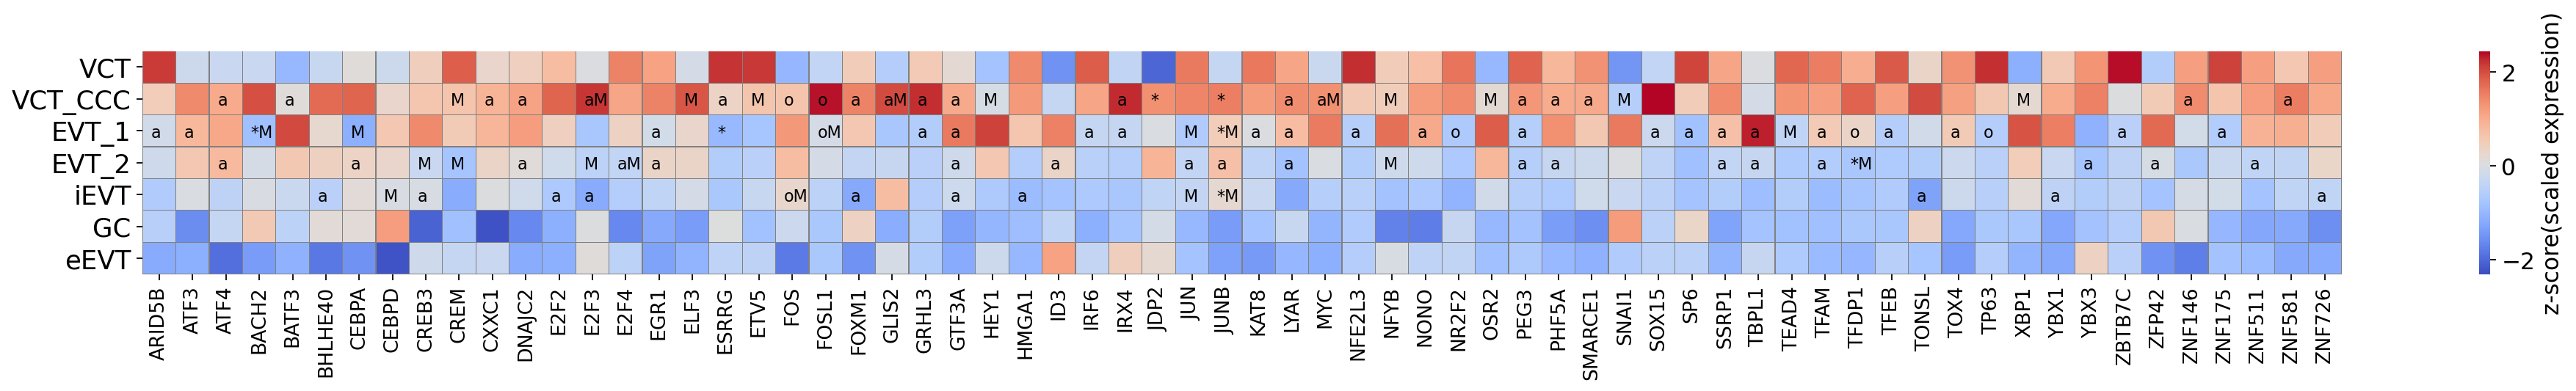

In [209]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_1_early_inv_column'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(30,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220216_TF_expression_heatmap_zscores_in_vivo_logFC_cutoff_top_10%_in_limma_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


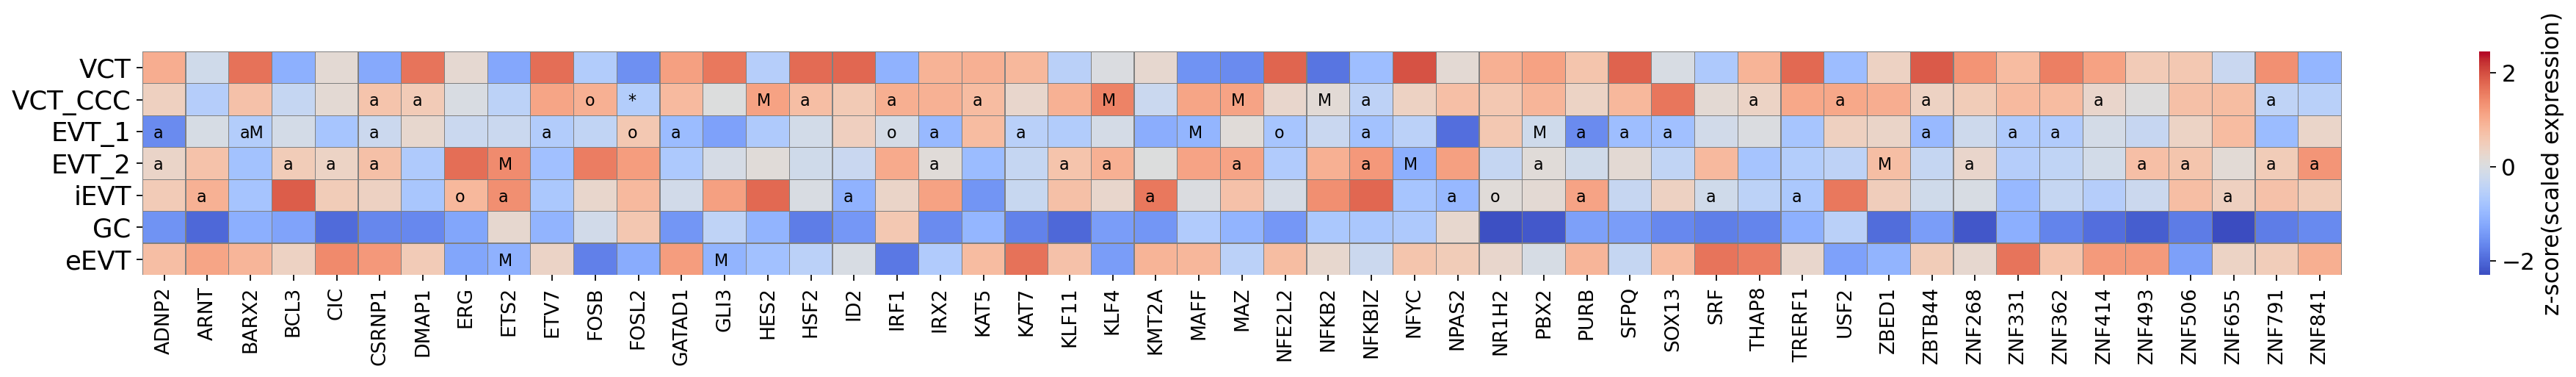

In [211]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_2_inv_front'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(30,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220216_TF_expression_heatmap_zscores_in_vivo_logFC_cutoff_top_10%_in_limma_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


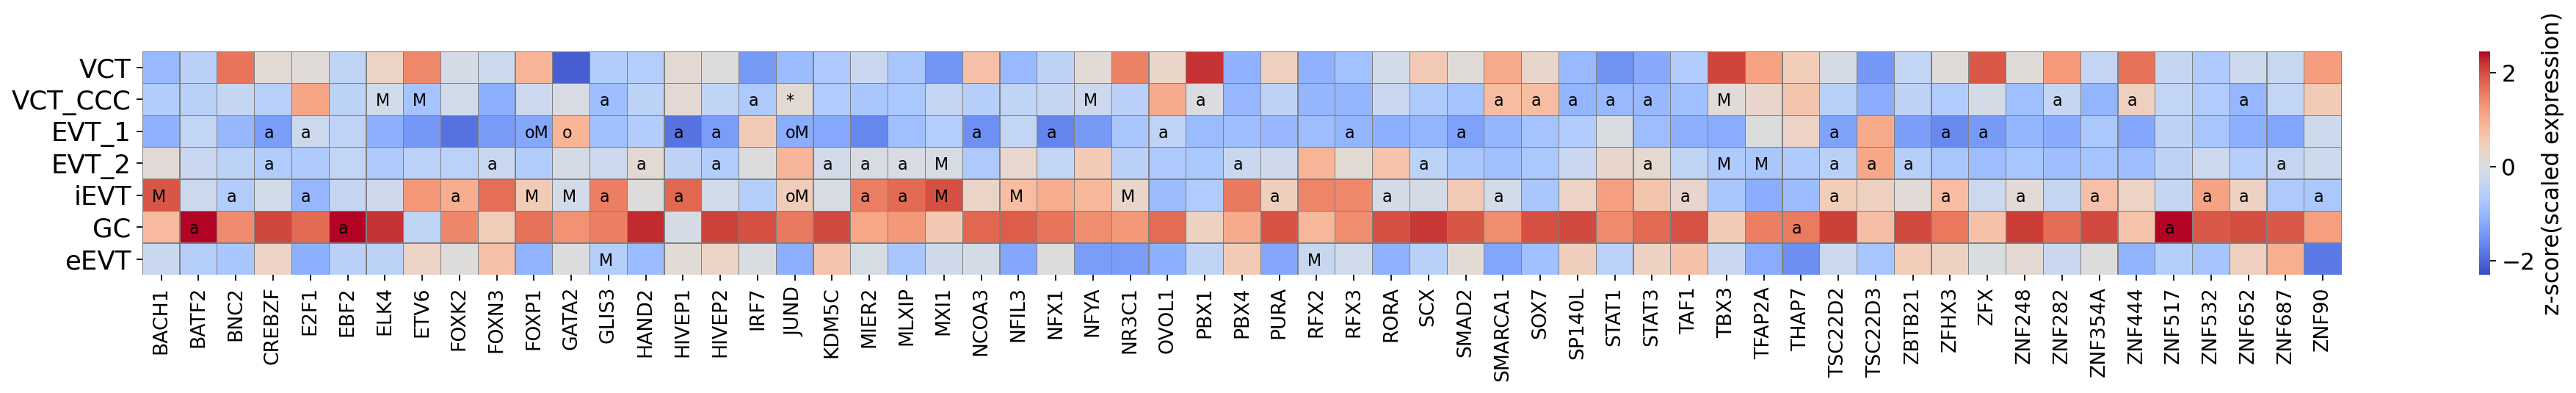

In [213]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_3_fusion'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(30,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220216_TF_expression_heatmap_zscores_in_vivo_logFC_cutoff_top_10%_in_limma_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


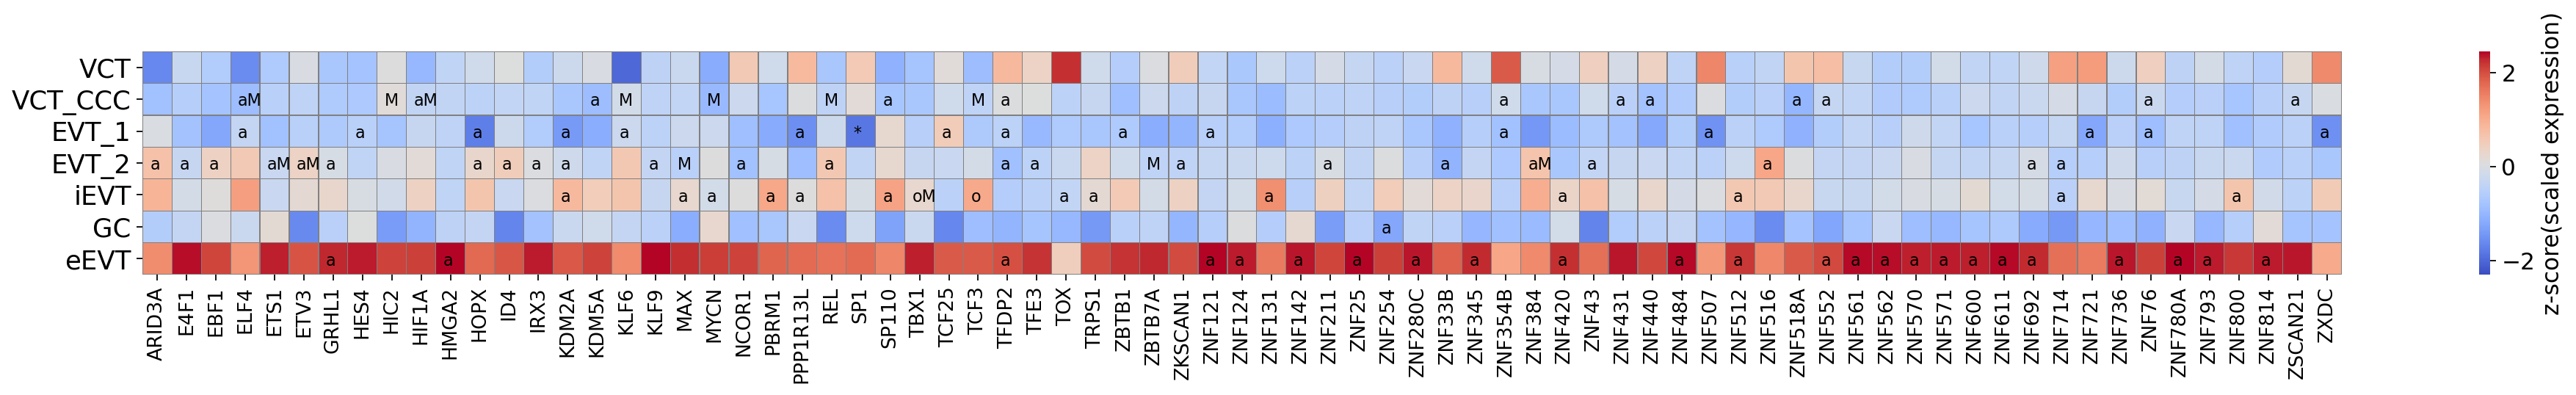

In [214]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_4_artery_remodelling'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(30,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220216_TF_expression_heatmap_zscores_in_vivo_logFC_cutoff_top_10%_in_limma_with_annotation_' + curr_ME + '.pdf', bbox_inches='tight')

plt.show()


In [185]:
coords_annotation_per_ME['ME_1_early_inv_column']

[[(0.25, 0.7), 'a'],
 [(1.25, 0.7), 'a'],
 [(2.25, 0.7), 'a'],
 [(2.25, 1.7), 'a'],
 [(2.25, 4.7), 'a'],
 [(3.25, 1.7), 'a'],
 [(4.25, 0.7), '*'],
 [(5.25, 4.7), 'a'],
 [(6.25, 6.7), 'a'],
 [(7.25, 0.7), 'a'],
 [(7.25, 1.7), 'a'],
 [(8.25, 1.7), 'a'],
 [(9.25, 6.7), 'a'],
 [(12.25, 4.7), 'a'],
 [(13.25, 0.7), 'a'],
 [(14.25, 1.7), 'a'],
 [(14.25, 4.7), 'a'],
 [(16.25, 1.7), 'a'],
 [(16.25, 4.7), 'a'],
 [(16.25, 6.7), 'a'],
 [(17.25, 4.7), 'a'],
 [(17.25, 6.7), 'a'],
 [(18.25, 1.7), 'a'],
 [(19.25, 0.7), 'a'],
 [(21.25, 0.7), 'a'],
 [(21.25, 1.7), 'a'],
 [(22.25, 0.7), 'a'],
 [(26.25, 0.7), '*'],
 [(26.25, 4.7), 'a'],
 [(28.25, 0.7), 'a'],
 [(28.25, 1.7), 'a'],
 [(29.25, 4.7), 'o'],
 [(29.25, 6.7), 'o'],
 [(30.25, 0.7), 'o'],
 [(30.25, 4.7), 'o'],
 [(31.25, 4.7), 'a'],
 [(31.25, 6.7), 'a'],
 [(32.25, 0.7), 'a'],
 [(33.25, 4.7), 'a'],
 [(33.25, 6.7), 'a'],
 [(34.25, 0.7), 'a'],
 [(34.25, 4.7), 'a'],
 [(35.25, 0.7), 'a'],
 [(35.25, 1.7), 'a'],
 [(35.25, 4.7), 'a'],
 [(35.25, 6.7), 'a'],
 

# TO DO: add MEFISTO here


try to produce the same heatmap with and without a logFC cutoff (a way to prioritise) per ME

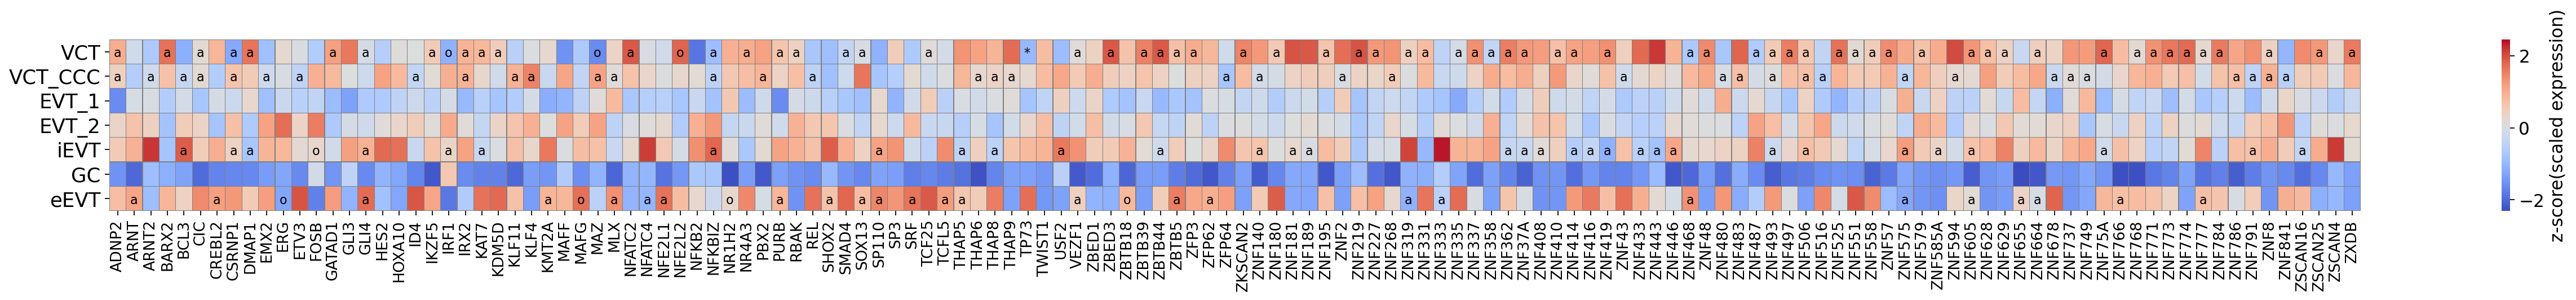

In [182]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_2_inv_front'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

#plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


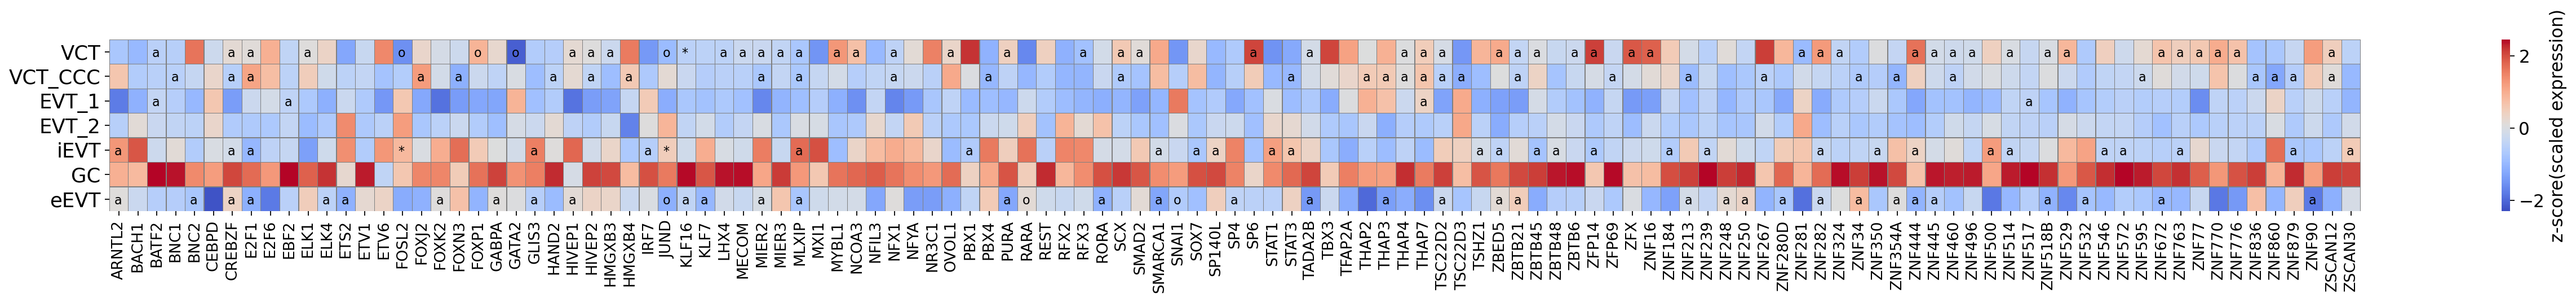

In [183]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_3_fusion'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

#plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


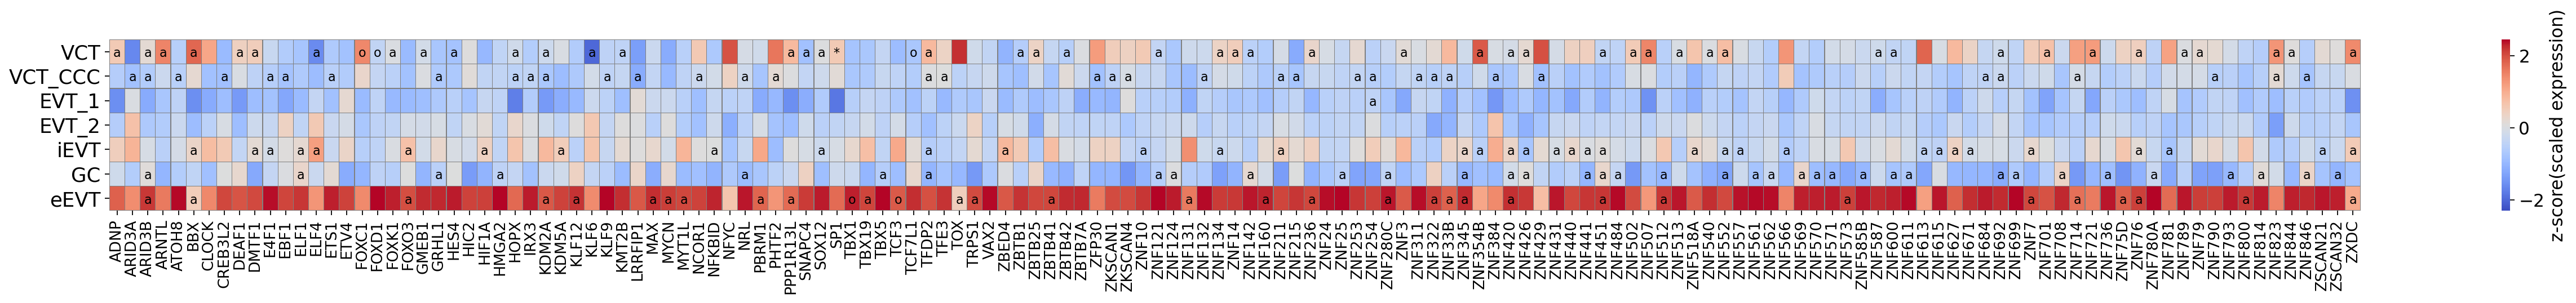

In [184]:
# playing a bit with the plotting here

# all MEs?

curr_ME = 'ME_4_artery_remodelling'

TFs2plot = MEs_TFs[curr_ME]

TFs2plot = sorted(TFs2plot)

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

#plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


# for the final figure heatmap from here we can somehow (how?) select only top TFs...

In [ ]:
# older results below

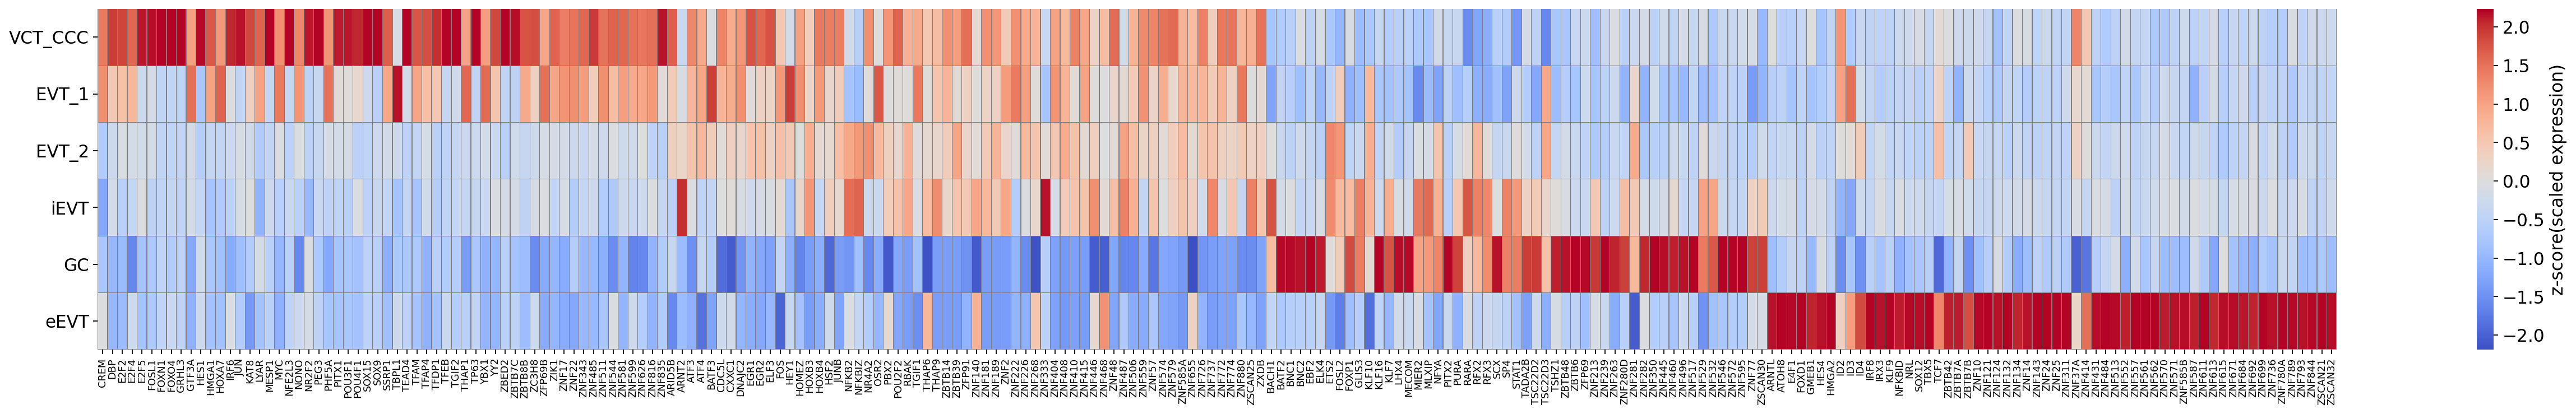

In [94]:
# all 4 MEs plotted together

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(all_TFs_final) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = all_TFs_final)

# already saved
#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

plt.show()

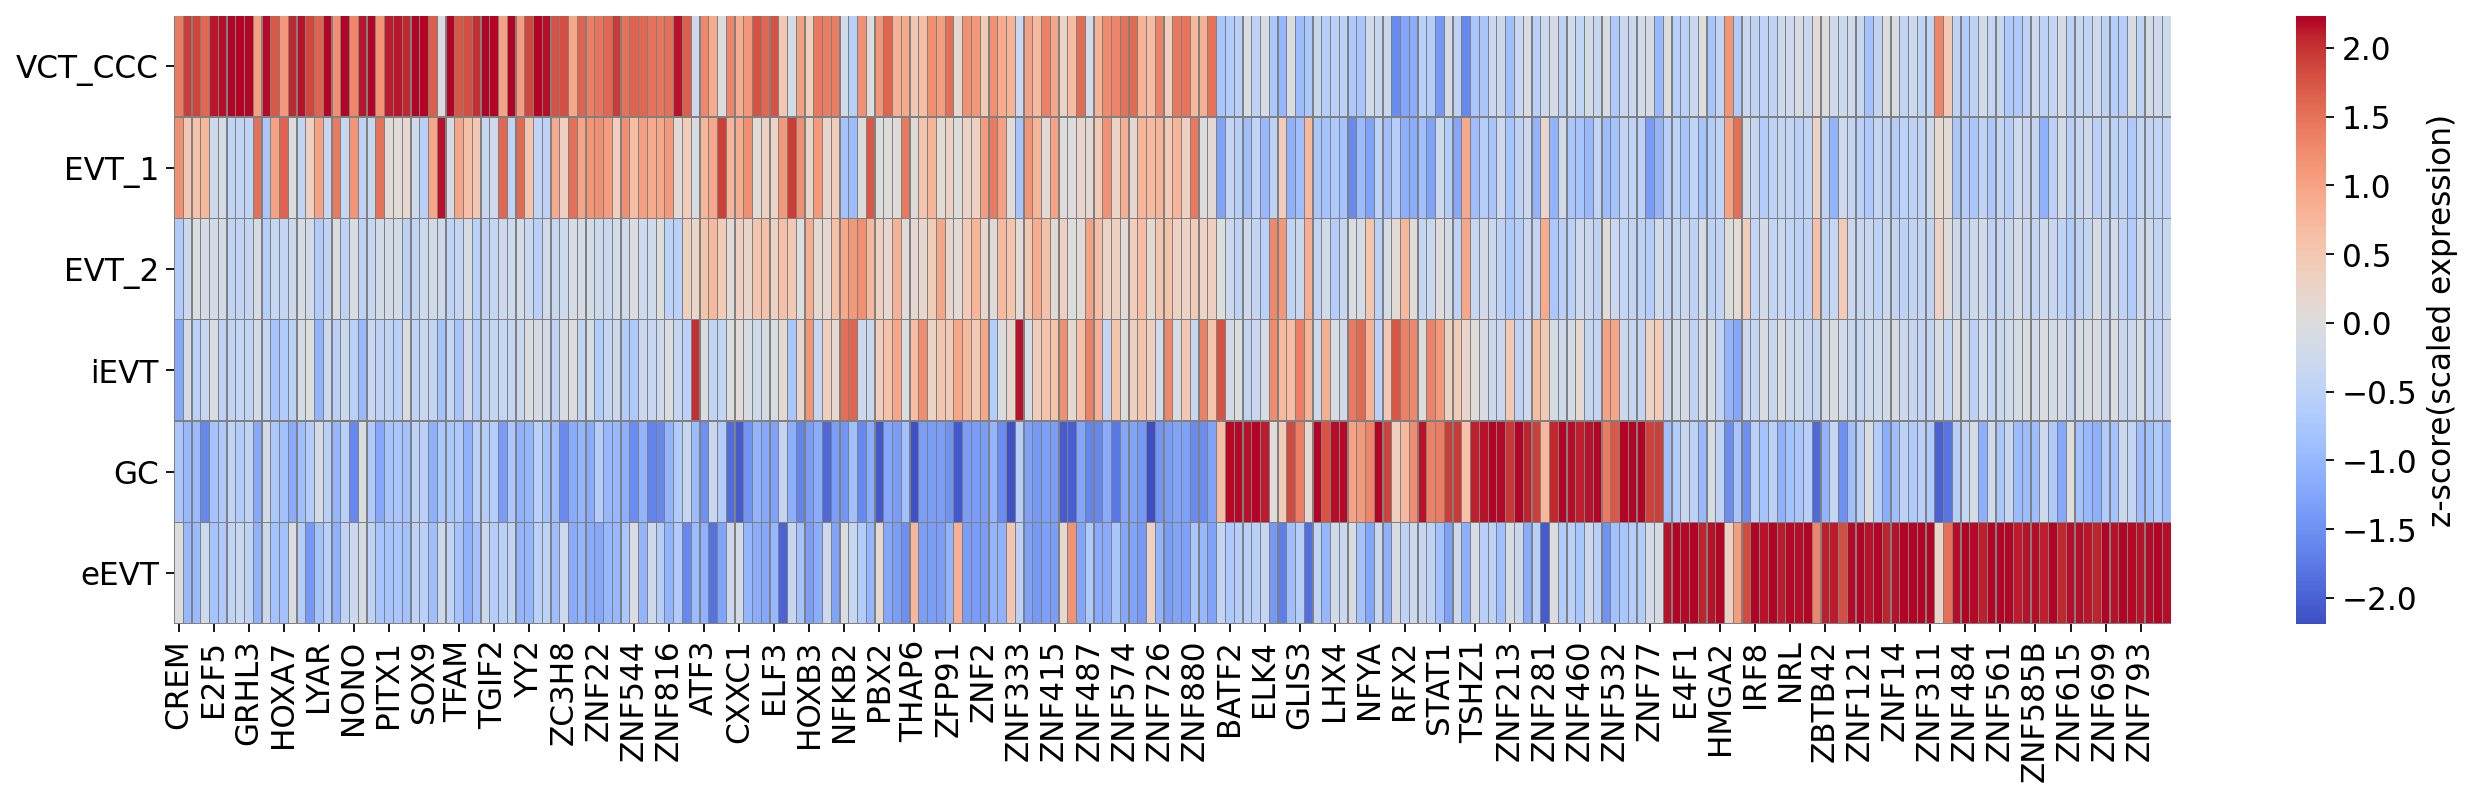

In [96]:
# all 4 MEs plotted together - prliminary for now, just to show the pattern

plt.figure(figsize=(20,5))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(all_TFs_final) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = all_TFs_final)

# already saved
plt.savefig('./figures/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

plt.show()

# make a list of correspondence of TFs to which factor they come up in in MEFISTO (will color code)

## and add annotations (*, a, o) onto either this plot or square

In [73]:
[TF for TF in all_TFs_final if 'GATA' in TF]

[]

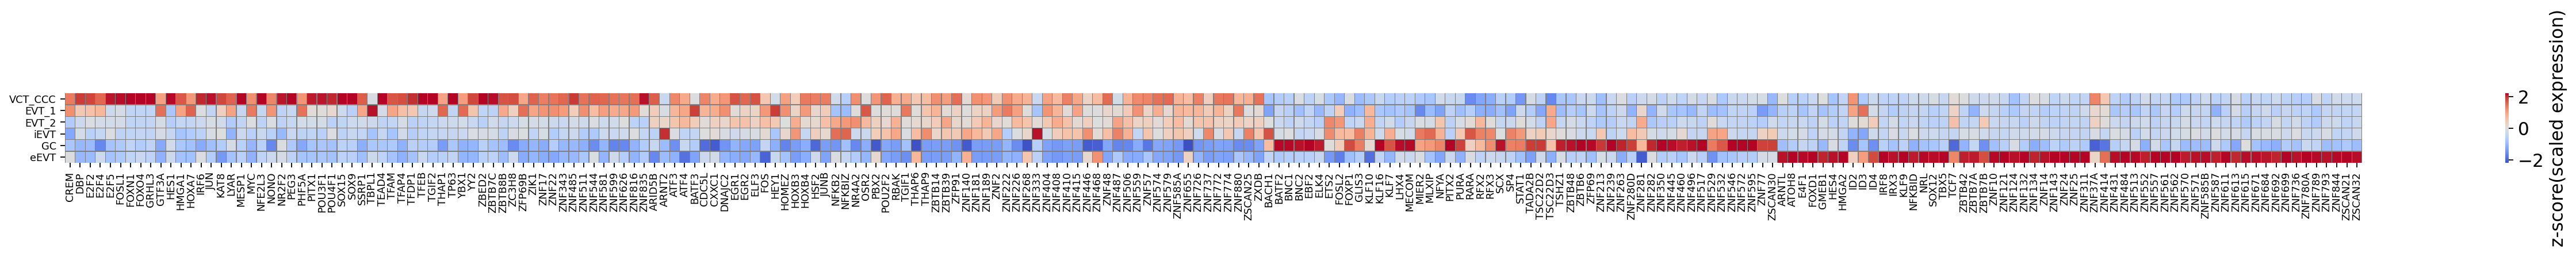

In [74]:
# playing a bit with the plotting here

# all 4 MEs plotted together

plt.figure(figsize=(40,1))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(all_TFs_final) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = all_TFs_final)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=8, labels = df_avg_expr_zscores.columns)


plt.show()

#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

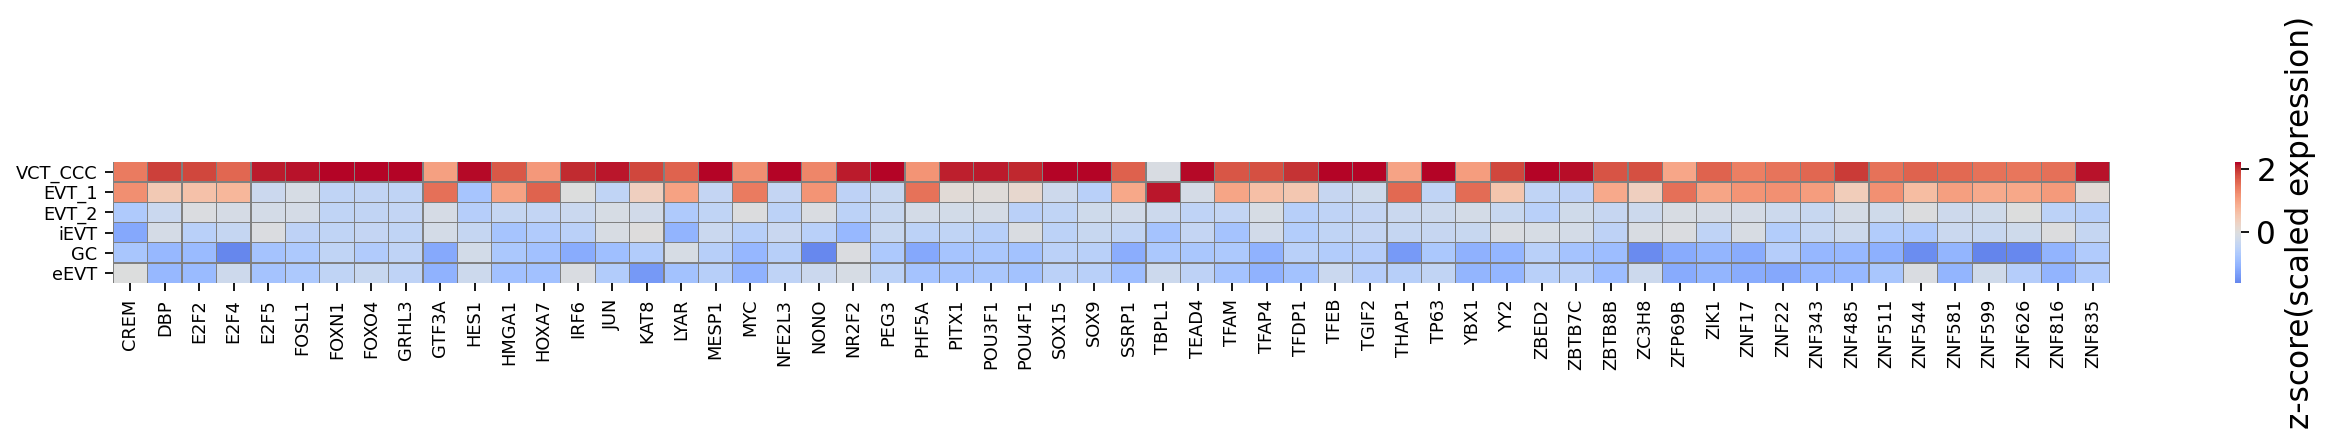

In [121]:
# playing a bit with the plotting here

# ME 1

TFs2plot = sorted(MEs_TFs['ME_1_early_inv_column'])

plt.figure(figsize=(20,1))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=8, labels = df_avg_expr_zscores.columns)


plt.show()

#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

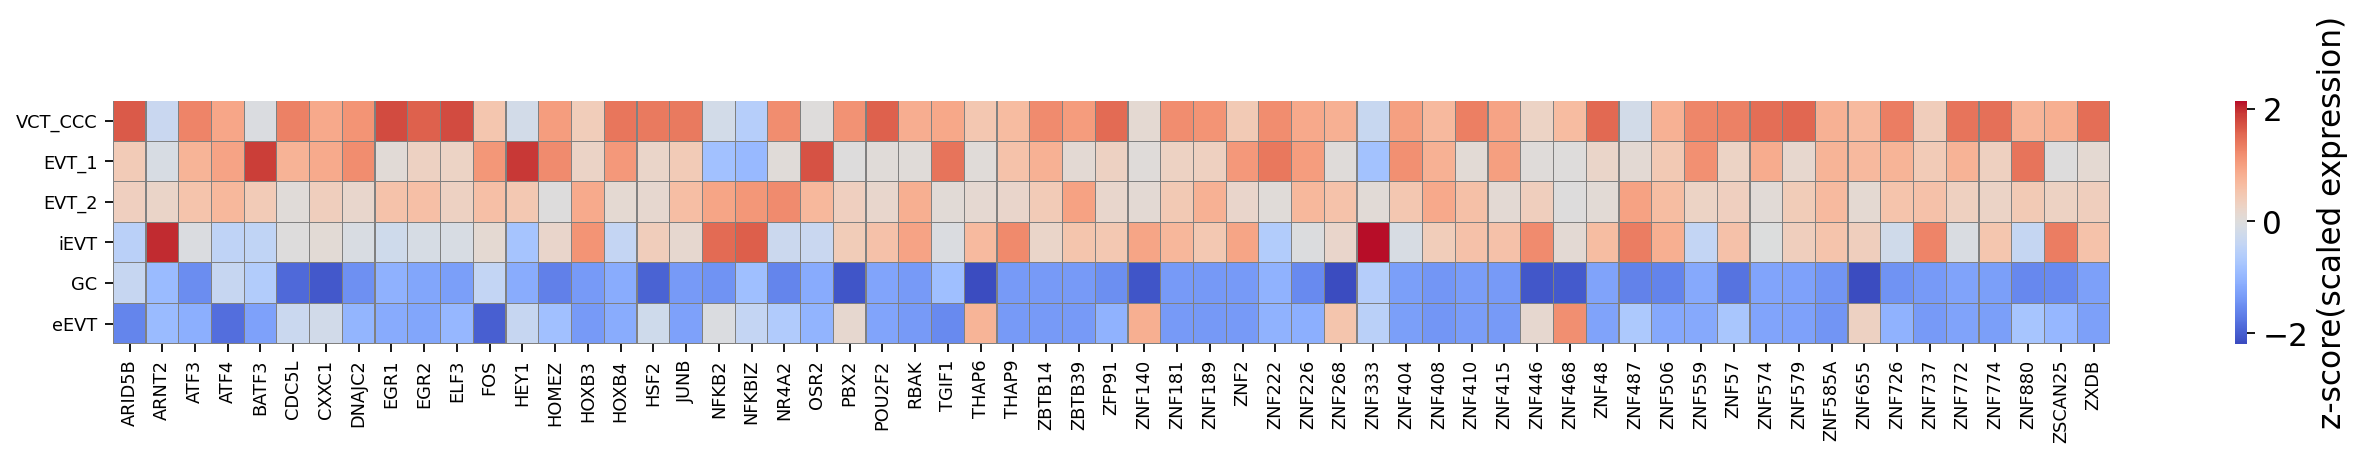

In [122]:
# playing a bit with the plotting here

# ME 2

TFs2plot = sorted(MEs_TFs['ME_2_inv_front'])

plt.figure(figsize=(20,2))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=8, labels = df_avg_expr_zscores.columns)


plt.show()

#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

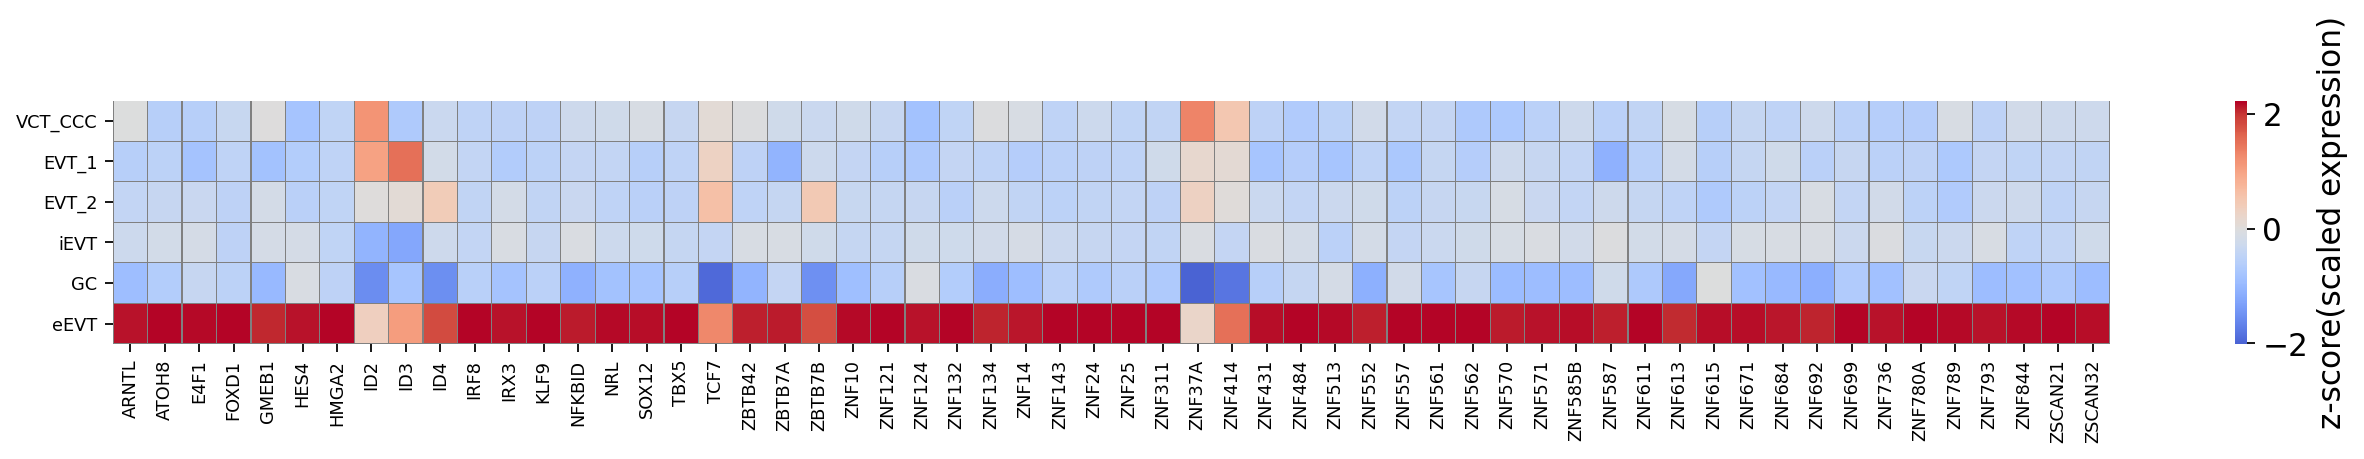

In [123]:
# playing a bit with the plotting here

# ME 3

TFs2plot = sorted(MEs_TFs['ME_3_artery_remodelling'])

plt.figure(figsize=(20,2))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=8, labels = df_avg_expr_zscores.columns)


plt.show()

#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

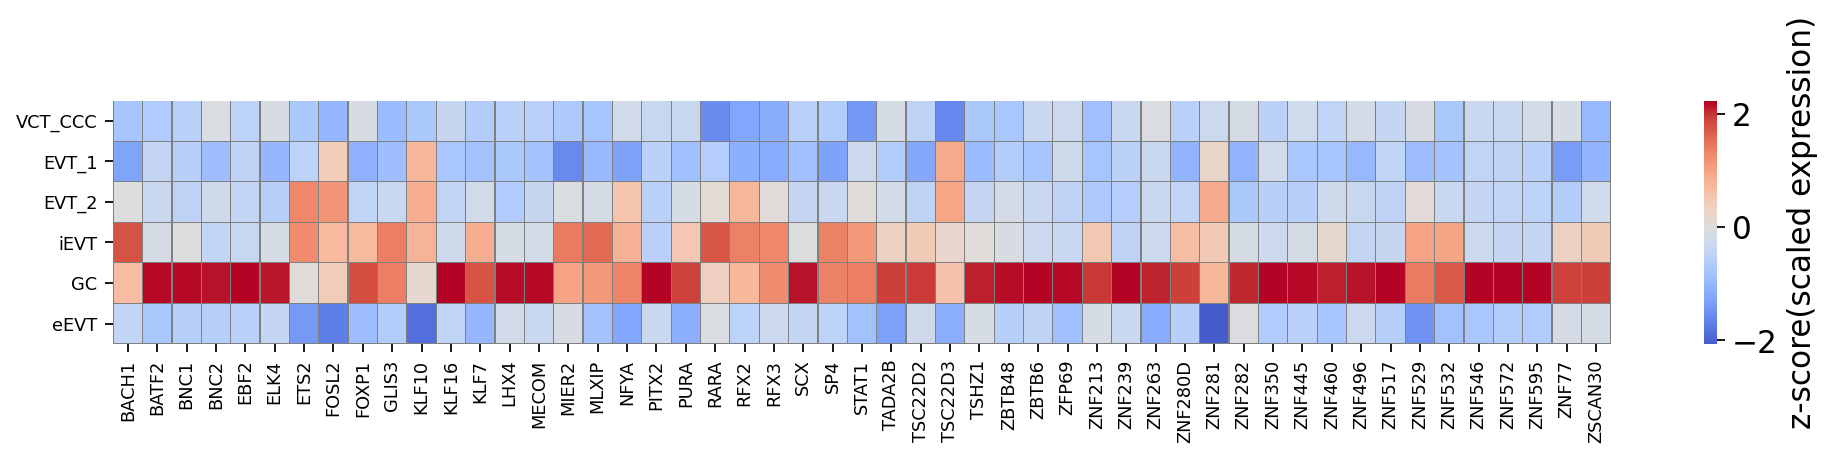

In [125]:
# playing a bit with the plotting here

# ME 4

TFs2plot = sorted(MEs_TFs['ME_4_fusion'])

plt.figure(figsize=(15,2))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=8, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=8, labels = df_avg_expr_zscores.columns)


plt.show()

#plt.savefig('./figures/20220203_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

In [75]:
# simplifying this to mimic Luz&Valentina's code, will add MEFISTO-layer evidence later

df_TFs_evidence_per_ME = {}

# which comparisons was the TF prioritised through? and what was the sign (upreg or downreg)?
comparisons_per_TF = {}

# which comparisons was the TF prioritised through?
evidences_per_TF = {}

for ME in MEs:
    print(ME)
    df_TFs_evidence_per_ME[ME] = pd.DataFrame(index = MEs_TFs[ME],
                                         columns = list(df_avg_expr_zscores.columns))
    
    for TF in df_TFs_evidence_per_ME[ME].index:
        for comparison in comparisons:
            if TF in TFs_upregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_upreg'
                sign = '+'
                evidences_per_TF[TF] = list(TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                #elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                    
            
            elif TF in TFs_downregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_downreg'
                sign = '-'
                evidences_per_TF[TF] = list(TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                #elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                #    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'a'
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'o'
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = '*'
                

ME_1_early_inv_column
ME_2_inv_front
ME_3_artery_remodelling
ME_4_fusion


In [81]:
df_TFs_evidence_per_ME['ME_1_early_inv_column']

VCT_CCC EVT_1 EVT_2 iEVT   GC eEVT
SOX15      NaN     a   NaN  NaN  NaN  NaN
ZNF343     NaN     a   NaN  NaN  NaN  NaN
E2F5       NaN     a   NaN  NaN  NaN  NaN
SSRP1      NaN     a     a  NaN  NaN  NaN
GTF3A        a     a     a    a  NaN  NaN
FOSL1        o     o   NaN  NaN  NaN  NaN
SOX9       NaN   NaN   NaN  NaN  NaN  NaN
FOXO4      NaN   NaN   NaN  NaN  NaN  NaN
ZNF544     NaN     a   NaN  NaN  NaN  NaN
HES1       NaN   NaN   NaN  NaN  NaN  NaN
CREM       NaN   NaN   NaN  NaN  NaN  NaN
ZNF511     NaN     a     a  NaN  NaN  NaN
TBPL1      NaN     a     a  NaN  NaN  NaN
E2F4       NaN   NaN     a  NaN  NaN  NaN
NR2F2      NaN     o   NaN  NaN  NaN  NaN
THAP1      NaN     o   NaN  NaN  NaN  NaN
ZNF485     NaN     a   NaN  NaN  NaN  NaN
ZNF581       a   NaN     a    a  NaN  NaN
NONO       NaN     a   NaN  NaN  NaN  NaN
PITX1      NaN   NaN   NaN  NaN  NaN  NaN
MESP1        a     a   NaN  NaN  NaN  NaN
PHF5A        a   NaN     a  NaN  NaN  NaN
TFEB       NaN     a   NaN  NaN  NaN  NaN
ZNF835     NaN     a   NaN  NaN  NaN  NaN
ZFP69B       a   NaN   NaN  NaN  NaN  NaN
ZNF17        a   NaN   NaN  NaN  NaN  NaN
KAT8       NaN     a   NaN  NaN  NaN  NaN
ZBED2        a     a   NaN  NaN  NaN  NaN
ZNF22      NaN   NaN     a  NaN  NaN  NaN
YBX1       NaN   NaN   NaN    a  NaN  NaN
POU4F1     NaN   NaN   NaN  NaN  NaN  NaN
TFDP1      NaN     o     *  NaN  NaN  NaN
ZC3H8      NaN   NaN     a  NaN  NaN  NaN
TEAD4      NaN   NaN   NaN  NaN  NaN  NaN
TFAP4        a     a   NaN  NaN  NaN  NaN
ZIK1         a   NaN   NaN  NaN  NaN  NaN
JUN        NaN   NaN     a  NaN  NaN  NaN
LYAR         a     a     a  NaN  NaN  NaN
ZNF626     NaN     a   NaN  NaN  NaN  NaN
MYC          a   NaN     a  NaN  NaN  NaN
TGIF2      NaN   NaN   NaN  NaN  NaN  NaN
ZBTB7C     NaN     a   NaN  NaN  NaN  NaN
POU3F1     NaN     a   NaN  NaN  NaN  NaN
TFAM       NaN     a     a  NaN  NaN  NaN
ZBTB8B     NaN     a   NaN  NaN  NaN  NaN
E2F2         a   NaN     a    a  NaN  NaN
PEG3         a     a     a  NaN  NaN  NaN
TP63       NaN     o   NaN  NaN  NaN  NaN
FOXN1      NaN     a   NaN  NaN  NaN  NaN
DBP        NaN     a   NaN  NaN  NaN  NaN
YY2        NaN   NaN   NaN  NaN  NaN  NaN
HOXA7      NaN   NaN     a  NaN  NaN  NaN
IRF6       NaN     a   NaN  NaN  NaN  NaN
ZNF599       a     a   NaN  NaN  NaN  NaN
ZNF816       a     a   NaN    a  NaN  NaN
NFE2L3     NaN     a   NaN  NaN  NaN  NaN
HMGA1      NaN   NaN   NaN    a  NaN  NaN
GRHL3        a     a   NaN  NaN  NaN  NaN

In [83]:
# here for all MEs together
df_TFs_evidence_all = pd.concat([df_TFs_evidence_per_ME['ME_1_early_inv_column'], df_TFs_evidence_per_ME['ME_2_inv_front'],
                                df_TFs_evidence_per_ME['ME_4_fusion'], df_TFs_evidence_per_ME['ME_3_artery_remodelling']])
df_TFs_evidence_all = df_TFs_evidence_all.loc[all_TFs_final]

In [84]:
df_TFs_evidence_all

VCT_CCC EVT_1 EVT_2 iEVT   GC eEVT
CREM        NaN   NaN   NaN  NaN  NaN  NaN
DBP         NaN     a   NaN  NaN  NaN  NaN
E2F2          a   NaN     a    a  NaN  NaN
E2F4        NaN   NaN     a  NaN  NaN  NaN
E2F5        NaN     a   NaN  NaN  NaN  NaN
...         ...   ...   ...  ...  ...  ...
ZNF789      NaN     a   NaN  NaN  NaN  NaN
ZNF793      NaN   NaN   NaN  NaN  NaN    a
ZNF844      NaN     a   NaN  NaN  NaN  NaN
ZSCAN21       a   NaN   NaN  NaN  NaN  NaN
ZSCAN32     NaN   NaN   NaN  NaN  NaN    a

[228 rows x 6 columns]

In [85]:
# here for all MEs together
coords_annotation_all = []

curr_df = df_TFs_evidence_all

for TF in curr_df.index:
    #print(TF)
    x_shift = 0.25 # should be consistent for all 4 heatmaps (per ME)
    curr_coord_x = x_shift + list(curr_df.index).index(TF) # x coordinate of TF
    #print(curr_coord_x)

    for ct in curr_df.columns:
        if str(curr_df.loc[TF,ct]) != 'nan':
            #print(TF, ct)
            y_shift = 0.7 # is different for different heatmaps (per ME)?
            curr_coord_y = y_shift + list(curr_df.columns).index(ct) # y coordinate of cell type
            coords_annotation_all.append([(curr_coord_x, curr_coord_y), curr_df.loc[TF,ct]])


In [86]:
# common color limits for all 4 heatmaps
common_max = np.max(df_avg_expr_zscores.values)
common_min = np.min(df_avg_expr_zscores.values)
common_min

-2.1875007321112037

In [87]:
df_avg_expr_zscores

VCT_CCC     EVT_1     EVT_2      iEVT        GC      eEVT
BNC1   -0.550439 -0.568399 -0.480327 -0.010893  2.191925 -0.581867
ATOH8  -0.565360 -0.496028 -0.353160 -0.179350 -0.618534  2.212431
ZNF175  1.864023 -0.450103  0.179333  0.428541 -1.188654 -0.833139
ZNF277 -1.100397 -0.716307 -0.669661  0.249708  0.323372  1.913286
ZNF2    0.440744  1.084728  0.216151  0.962466 -1.352044 -1.352044
...          ...       ...       ...       ...       ...       ...
SP3    -0.433834 -0.923697 -0.100528  1.331224 -1.195206  1.322040
ETV4   -0.734522  0.091441 -0.212403  0.196153 -1.275197  1.934528
GRHL3   2.235414 -0.455408 -0.400814 -0.436377 -0.471408 -0.471408
ZC3H6  -0.547830 -1.370915 -0.867816  0.385577  1.065700  1.335284
BATF2  -0.646698 -0.400616 -0.313624 -0.126177  2.192911 -0.705796

[668 rows x 6 columns]

In [88]:
# to enable adobe illustrator to recognise the text as editable text object
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


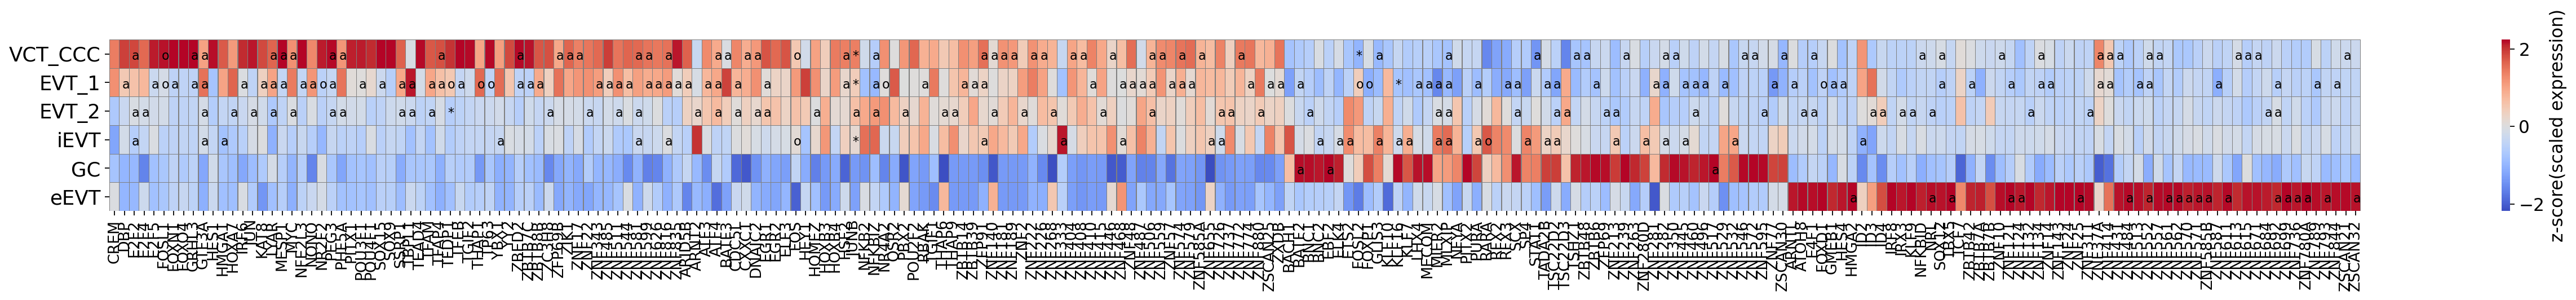

In [92]:
# playing a bit with the plotting here

# all MEs?

#curr_ME = 'ME_1_early_inv_column'

TFs2plot = all_TFs_final

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=12, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_all)):
    plt.annotate(coords_annotation_all[i][1], coords_annotation_all[i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220204_TF_expression_heatmap_zscores_in_vivo_all_MEs_with_annotation_ALL.pdf', bbox_inches='tight')

plt.show()


In [126]:
df_TFs_evidence_per_ME = {}

# which comparisons was the TF prioritised through? and what was the sign (upreg or downreg)?
comparisons_per_TF = {}

# which comparisons was the TF prioritised through?
evidences_per_TF = {}

for ME in MEs:
    print(ME)
    df_TFs_evidence_per_ME[ME] = pd.DataFrame(index = MEs_TFs[ME],
                                         columns = list(df_avg_expr_zscores.columns))
    
    for TF in df_TFs_evidence_per_ME[ME].index:
        for comparison in comparisons:
            if TF in TFs_upregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_upreg'
                sign = '+'
                evidences_per_TF[TF] = list(TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_upregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'D' + sign
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'C' + sign
                elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M' + sign
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DM' + sign
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'CM' + sign
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DC' + sign
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DCM' + sign
                    
            
            elif TF in TFs_downregulated_per_comparison_both_DA_and_DE[comparison].index:
                comparisons_per_TF[TF] = comparison + '_downreg'
                sign = '-'
                evidences_per_TF[TF] = list(TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']][TFs_downregulated_per_comparison_both_DA_and_DE[comparison].loc[TF,['is_DA_dorothea','is_DA_chromVar','is_DA_MEFISTO']] == 'yes'].index)
                
                # encode this information in the annotation table
                ct = comparison.split('_vs_')[0] # cell type position in heatmap
                
                if evidences_per_TF[TF] == ['is_DA_dorothea']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'D' + sign
                elif evidences_per_TF[TF] == ['is_DA_chromVar']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'C' + sign
                elif evidences_per_TF[TF] == ['is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'M' + sign
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DM' + sign
                elif evidences_per_TF[TF] == ['is_DA_chromVar', 'is_DA_MEFISTO']:
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'CM' + sign
                    
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DC' + sign
                elif evidences_per_TF[TF] == ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']: # this combo is not present in our results
                    df_TFs_evidence_per_ME[ME].loc[TF,ct] = 'DCM' + sign
                

ME_1_early_inv_column
ME_2_inv_front
ME_3_artery_remodelling
ME_4_fusion


In [127]:
comparisons_per_TF['THAP1']

'EVT_1_vs_VCT_CCC_upreg'

In [128]:
evidences_per_TF['THAP1']

['is_DA_chromVar', 'is_DA_MEFISTO']

In [129]:
evidences_per_TF_str = [str(elem) for elem in list(evidences_per_TF.values())]
np.unique(evidences_per_TF_str)
#evidences_per_TF_str

array(["['is_DA_MEFISTO']", "['is_DA_chromVar', 'is_DA_MEFISTO']",
       "['is_DA_chromVar']", "['is_DA_dorothea', 'is_DA_MEFISTO']",
       "['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO']",
       "['is_DA_dorothea', 'is_DA_chromVar']", "['is_DA_dorothea']"],
      dtype='<U53')

In [130]:
# encoding:
# ['is_DA_MEFISTO'] --> M - deg + factor-explaining --> 
# ['is_DA_chromVar'] --> C - deg + open
# ['is_DA_dorothea'] --> D - deg + active

# ['is_DA_chromVar', 'is_DA_MEFISTO'] --> CM
# ['is_DA_dorothea', 'is_DA_MEFISTO'] --> DM

# the following ones are not present in our results but just for general code workability let's add them
# ['is_DA_dorothea', 'is_DA_chromVar'] --> DC
# ['is_DA_dorothea', 'is_DA_chromVar', 'is_DA_MEFISTO'] --> DCM


In [131]:
TFs_upregulated_per_comparison_both_DA_and_DE['EVT_1_vs_VCT_CCC'].loc['THAP1']

Avg_expr             0.102416
is_DE_limma               yes
is_DA_dorothea             no
is_DA_chromVar            yes
is_DA_MEFISTO             yes
is_DE_and_DA              yes
cluster                 EVT_1
ID                EVT_1_THAP1
Name: THAP1, dtype: object

In [132]:
df_TFs_evidence_per_ME['ME_1_early_inv_column']

VCT_CCC EVT_1 EVT_2 iEVT   GC eEVT
SOX15      NaN    D-   NaN  NaN  NaN  NaN
ZNF343     NaN    D-   NaN  NaN  NaN  NaN
E2F5       NaN    D-   NaN  NaN  NaN  NaN
SSRP1      NaN    D-    D-  NaN  NaN  NaN
GTF3A       D+    D+    D-   D+  NaN  NaN
FOSL1       C+   CM-   NaN   M-  NaN  NaN
SOX9        M+   NaN   NaN  NaN  NaN  NaN
FOXO4       M-   NaN   NaN  NaN  NaN  NaN
ZNF544     NaN    D-   NaN  NaN  NaN  NaN
HES1       NaN    M-   NaN  NaN  NaN  NaN
CREM        M-   NaN    M-   M-  NaN  NaN
ZNF511     NaN    D-    D-  NaN  NaN  NaN
TBPL1      NaN    D+    D-  NaN  NaN  NaN
E2F4        M-    M-   DM-  NaN  NaN  NaN
NR2F2      NaN    C-   NaN  NaN  NaN  NaN
THAP1      NaN   CM+   NaN  NaN  NaN  NaN
ZNF485     NaN    D-   NaN  NaN  NaN  NaN
ZNF581      D+   NaN    D-   D+  NaN  NaN
NONO       NaN    D-   NaN  NaN  NaN  NaN
PITX1      NaN    M-   NaN  NaN  NaN  NaN
MESP1       D-    D-   NaN  NaN  NaN  NaN
PHF5A       D+   NaN    D-  NaN  NaN  NaN
TFEB       NaN    D-   NaN  NaN  NaN  NaN
ZNF835     NaN    D-   NaN  NaN  NaN  NaN
ZFP69B      D+   NaN   NaN  NaN  NaN  NaN
ZNF17       D-   NaN   NaN  NaN  NaN  NaN
KAT8       NaN    D-   NaN  NaN  NaN  NaN
ZBED2       D+    D-   NaN  NaN  NaN  NaN
ZNF22      NaN   NaN    D-  NaN  NaN  NaN
YBX1       NaN   NaN   NaN   D+  NaN  NaN
POU4F1     NaN    M-   NaN  NaN  NaN  NaN
TFDP1      NaN   CM-  DCM-  NaN  NaN  NaN
ZC3H8      NaN   NaN    D-  NaN  NaN  NaN
TEAD4      NaN    M-    M-  NaN  NaN  NaN
TFAP4       D+    D-   NaN  NaN  NaN  NaN
ZIK1        D-   NaN   NaN  NaN  NaN  NaN
JUN         M-    M-    D+  NaN  NaN  NaN
LYAR        D+    D-    D-  NaN  NaN  NaN
ZNF626     NaN    D-   NaN  NaN  NaN  NaN
MYC        DM+   NaN    D-  NaN  NaN  NaN
TGIF2      NaN    M-   NaN  NaN  NaN  NaN
ZBTB7C      M-   DM-   NaN  NaN  NaN  NaN
POU3F1     NaN   DM-   NaN  NaN  NaN  NaN
TFAM       NaN    D-    D-  NaN  NaN  NaN
ZBTB8B     NaN    D-   NaN  NaN  NaN  NaN
E2F2       DM+   NaN    D-   D-  NaN  NaN
PEG3        D-    D-    D+  NaN  NaN  NaN
TP63       NaN    C-   NaN  NaN  NaN  NaN
FOXN1      NaN    D-   NaN  NaN  NaN  NaN
DBP         M-   DM-   NaN  NaN  NaN  NaN
YY2        NaN    M-   NaN  NaN  NaN  NaN
HOXA7      NaN   NaN    D-  NaN  NaN  NaN
IRF6       NaN    D-   NaN  NaN  NaN  NaN
ZNF599      D-    D-   NaN  NaN  NaN  NaN
ZNF816      D-    D-   NaN   D+  NaN  NaN
NFE2L3     NaN    D-   NaN  NaN  NaN  NaN
HMGA1      NaN   NaN   NaN   D-  NaN  NaN
GRHL3       D+    D-   NaN  NaN  NaN  NaN

In [133]:
coords_annotation_per_ME = {}

for ME in MEs:
    print(ME)
    curr_df = df_TFs_evidence_per_ME[ME].loc[sorted(MEs_TFs[ME])]

    # coordinates where we want to add text annotation + annotation
    # [(float,float), str]
    coords_annotation_per_ME[ME] = []

    for TF in curr_df.index:
        #print(TF)
        x_shift = 0.25 # should be consistent for all 4 heatmaps (per ME)
        curr_coord_x = x_shift + list(curr_df.index).index(TF) # x coordinate of TF
        #print(curr_coord_x)

        for ct in curr_df.columns:
            if str(curr_df.loc[TF,ct]) != 'nan':
                #print(TF, ct)
                y_shift = 0.7 # is different for different heatmaps (per ME)?
                curr_coord_y = y_shift + list(curr_df.columns).index(ct) # y coordinate of cell type
                coords_annotation_per_ME[ME].append([(curr_coord_x, curr_coord_y), curr_df.loc[TF,ct]])


ME_1_early_inv_column
ME_2_inv_front
ME_3_artery_remodelling
ME_4_fusion


In [141]:
# common color limits for all 4 heatmaps
common_max = np.max(df_avg_expr_zscores.values)
common_min = np.min(df_avg_expr_zscores.values)
common_min

-2.1875007321112037

In [146]:
df_avg_expr_zscores

VCT_CCC     EVT_1     EVT_2      iEVT        GC      eEVT
BNC1   -0.550439 -0.568399 -0.480327 -0.010893  2.191925 -0.581867
ATOH8  -0.565360 -0.496028 -0.353160 -0.179350 -0.618534  2.212431
ZNF175  1.864023 -0.450103  0.179333  0.428541 -1.188654 -0.833139
ZNF277 -1.100397 -0.716307 -0.669661  0.249708  0.323372  1.913286
ZNF2    0.440744  1.084728  0.216151  0.962466 -1.352044 -1.352044
...          ...       ...       ...       ...       ...       ...
SP3    -0.433834 -0.923697 -0.100528  1.331224 -1.195206  1.322040
ETV4   -0.734522  0.091441 -0.212403  0.196153 -1.275197  1.934528
GRHL3   2.235414 -0.455408 -0.400814 -0.436377 -0.471408 -0.471408
ZC3H6  -0.547830 -1.370915 -0.867816  0.385577  1.065700  1.335284
BATF2  -0.646698 -0.400616 -0.313624 -0.126177  2.192911 -0.705796

[668 rows x 6 columns]

In [161]:
# to enable adobe illustrator to recognise the text as editable text object
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42


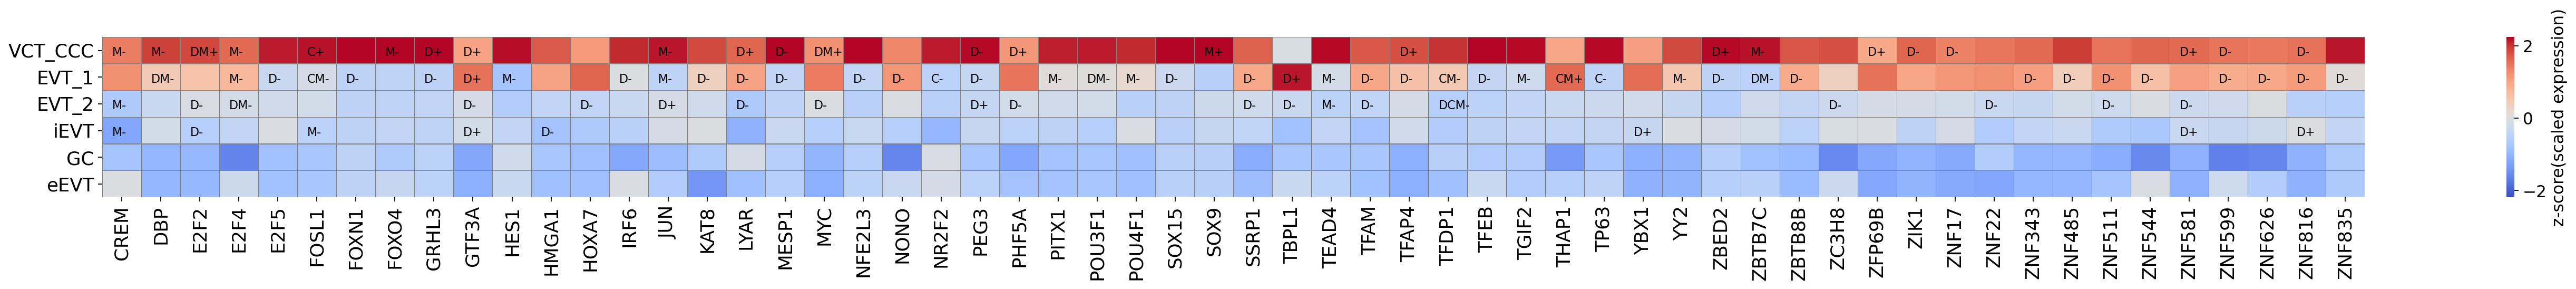

In [162]:
# playing a bit with the plotting here

# ME 1

curr_ME = 'ME_1_early_inv_column'

TFs2plot = sorted(MEs_TFs[curr_ME])

plt.figure(figsize=(43,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=16, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220203_TF_expression_heatmap_zscores_in_vivo_ME_1_early_inv_column_final_ALL.pdf', bbox_inches='tight')

plt.show()


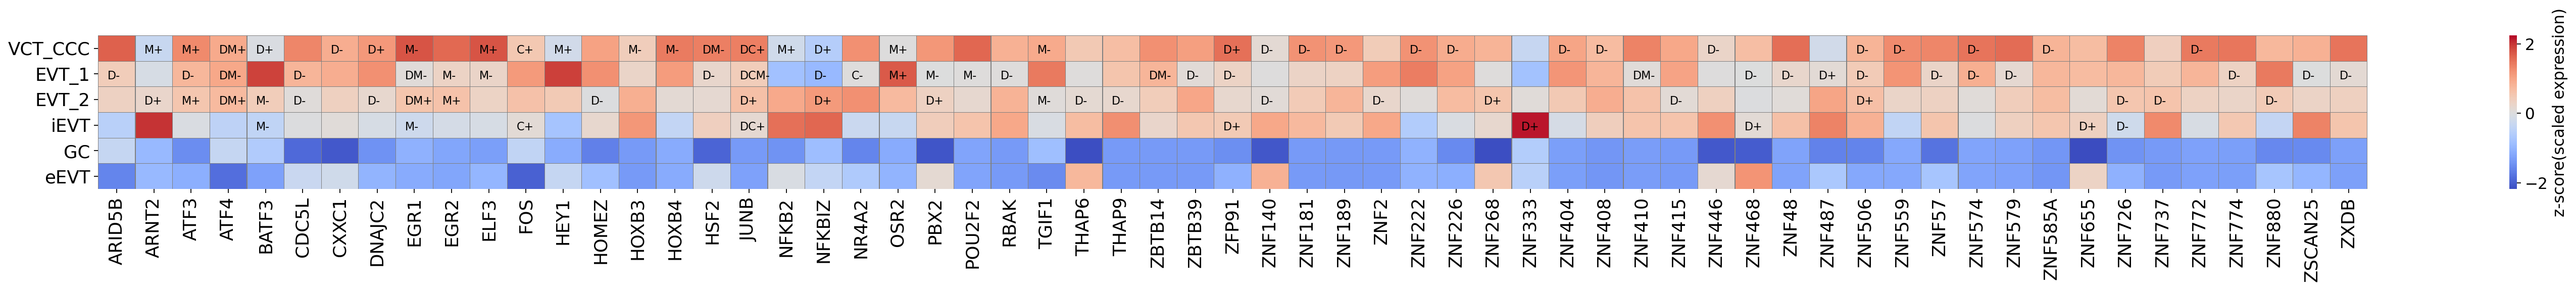

In [163]:
# playing a bit with the plotting here

# ME 2

curr_ME = 'ME_2_inv_front'

TFs2plot = sorted(MEs_TFs[curr_ME])

plt.figure(figsize=(45,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=16, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)
    
plt.savefig('./figures/Fig2G/20220203_TF_expression_heatmap_zscores_in_vivo_ME_2_inv_front_final_ALL.pdf', bbox_inches='tight')

plt.show()


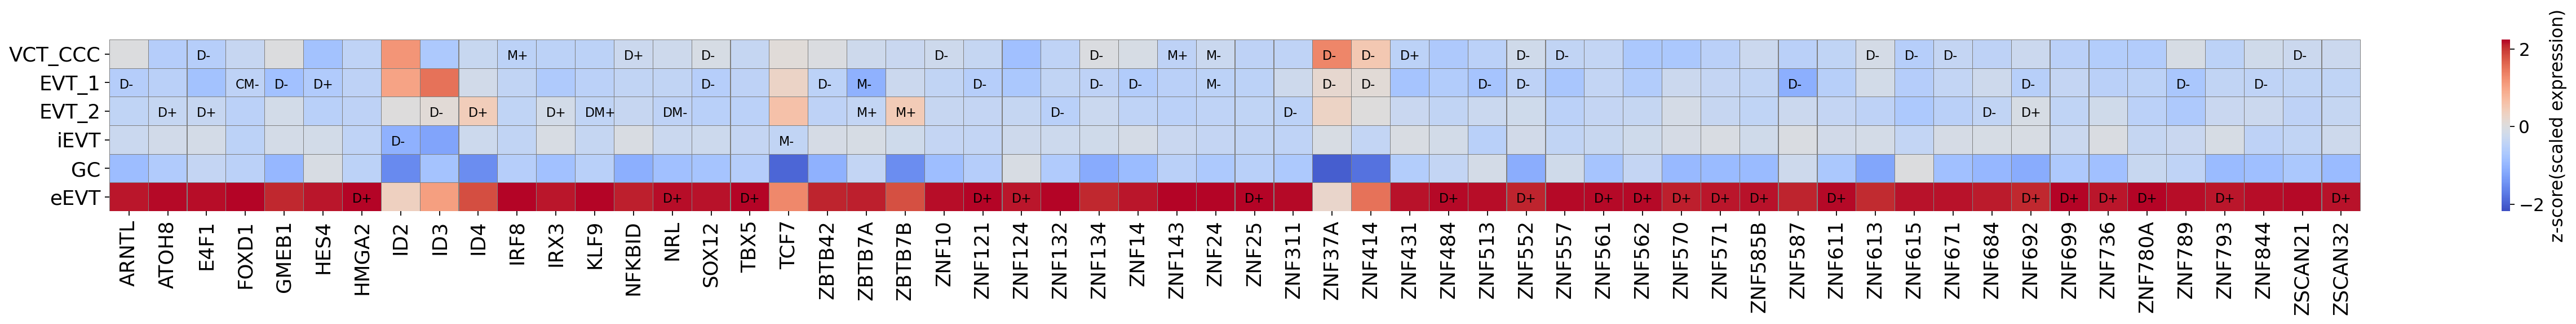

In [164]:
# playing a bit with the plotting here

# ME 3

curr_ME = 'ME_3_artery_remodelling'

TFs2plot = sorted(MEs_TFs[curr_ME])

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=16, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220203_TF_expression_heatmap_zscores_in_vivo_ME_3_artery_remodelling_final_ALL.pdf', bbox_inches='tight')

plt.show()


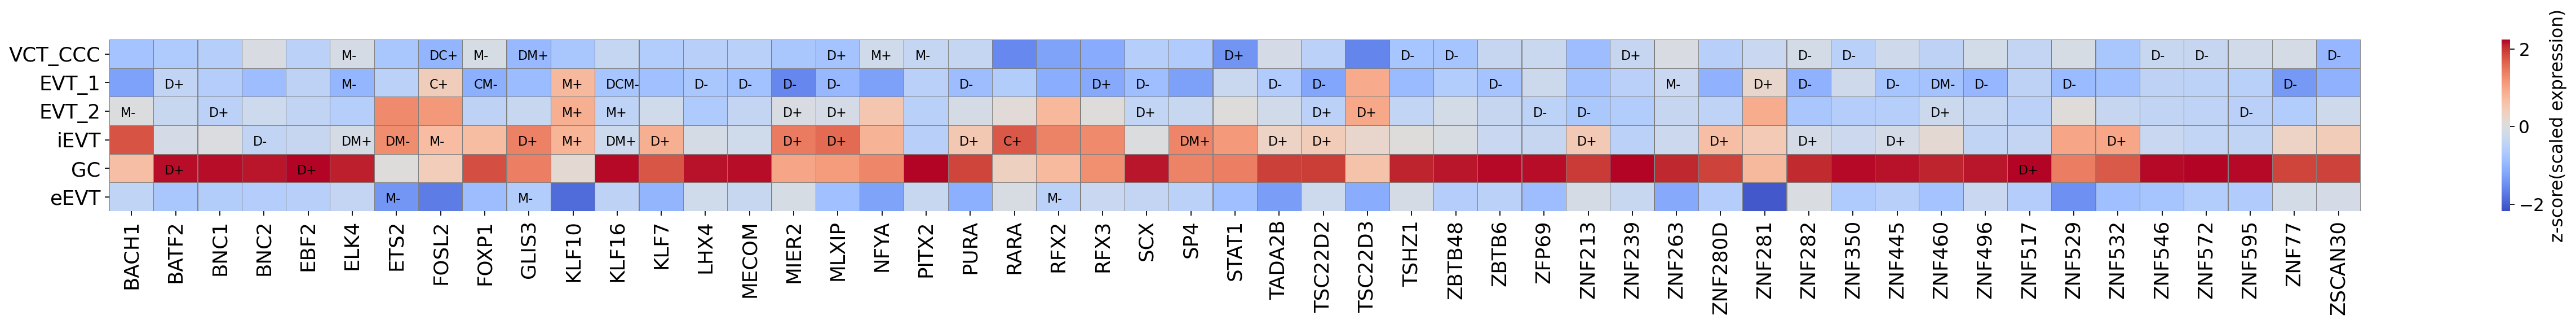

In [165]:
# playing a bit with the plotting here

# ME 4

curr_ME = 'ME_4_fusion'

TFs2plot = sorted(MEs_TFs[curr_ME])

plt.figure(figsize=(40,2.5))

sns.heatmap(df_avg_expr_zscores.loc[TFs2plot].T,
            #center=0, 
            cmap='coolwarm',
            vmin = common_min, vmax = common_max,
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )

x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
plt.xticks(x, fontsize=16, labels = TFs2plot)

y = np.arange(0.5, len(df_avg_expr_zscores.columns) + 0.5, 1)
plt.yticks(y, fontsize=16, labels = df_avg_expr_zscores.columns)


for i in range(len(coords_annotation_per_ME[curr_ME])):
    plt.annotate(coords_annotation_per_ME[curr_ME][i][1], coords_annotation_per_ME[curr_ME][i][0], fontsize=10)

plt.savefig('./figures/Fig2G/20220203_TF_expression_heatmap_zscores_in_vivo_ME_4_fusion_final_ALL.pdf', bbox_inches='tight')

plt.show()


In [132]:
len(TFs2plot) + 0.5

101.5

<Figure size 8000x400 with 0 Axes>

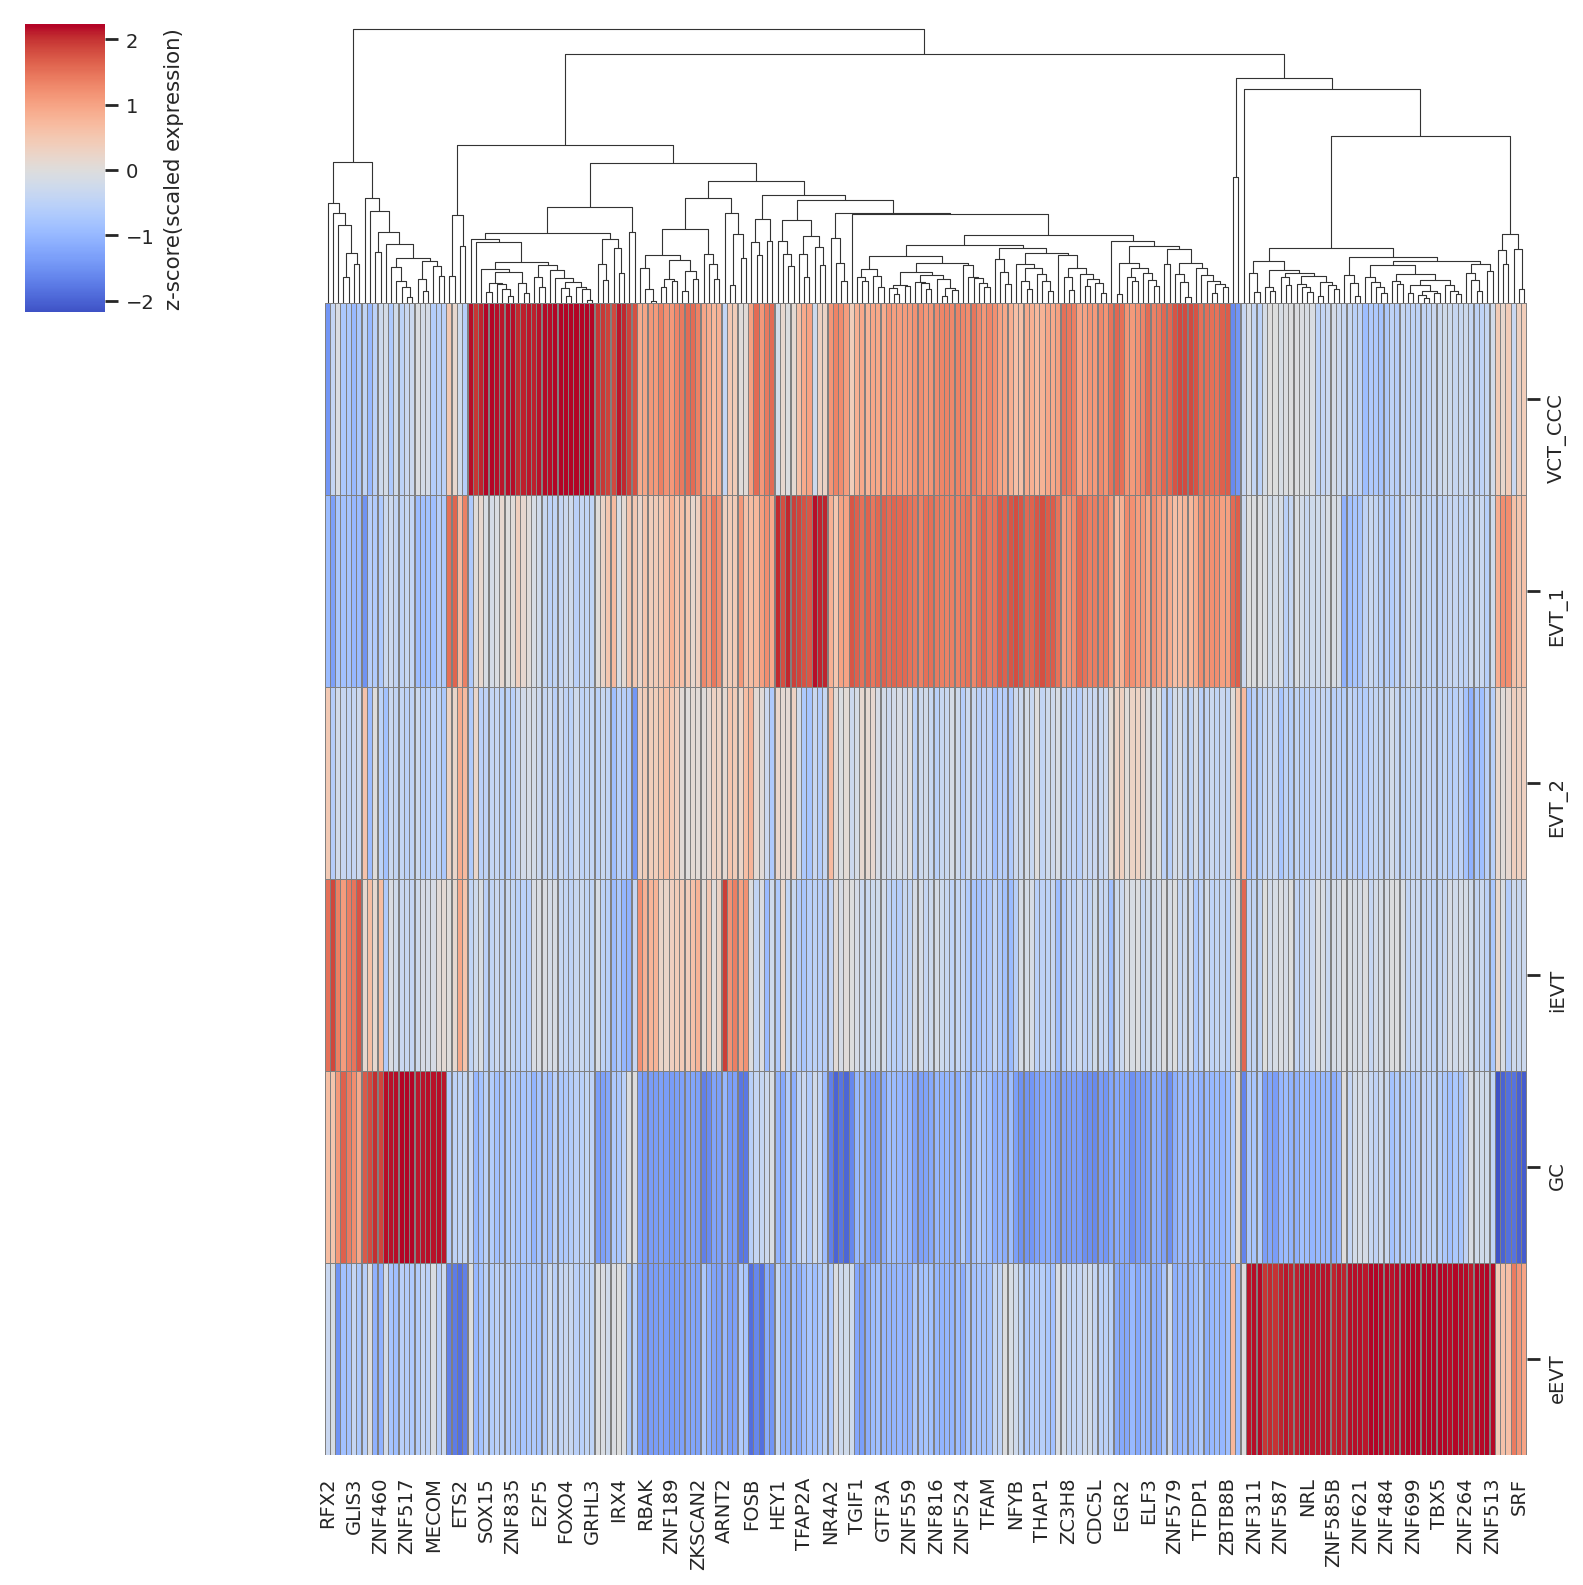

In [154]:
plt.figure(figsize=(100,5))

sns.set(font_scale=0.8)

# clusterplot for each ME

TFs2plot = sorted(all_TFs_final)

sns.clustermap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
               row_cluster=False,
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
#x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = TFs2plot)



<Figure size 8000x400 with 0 Axes>

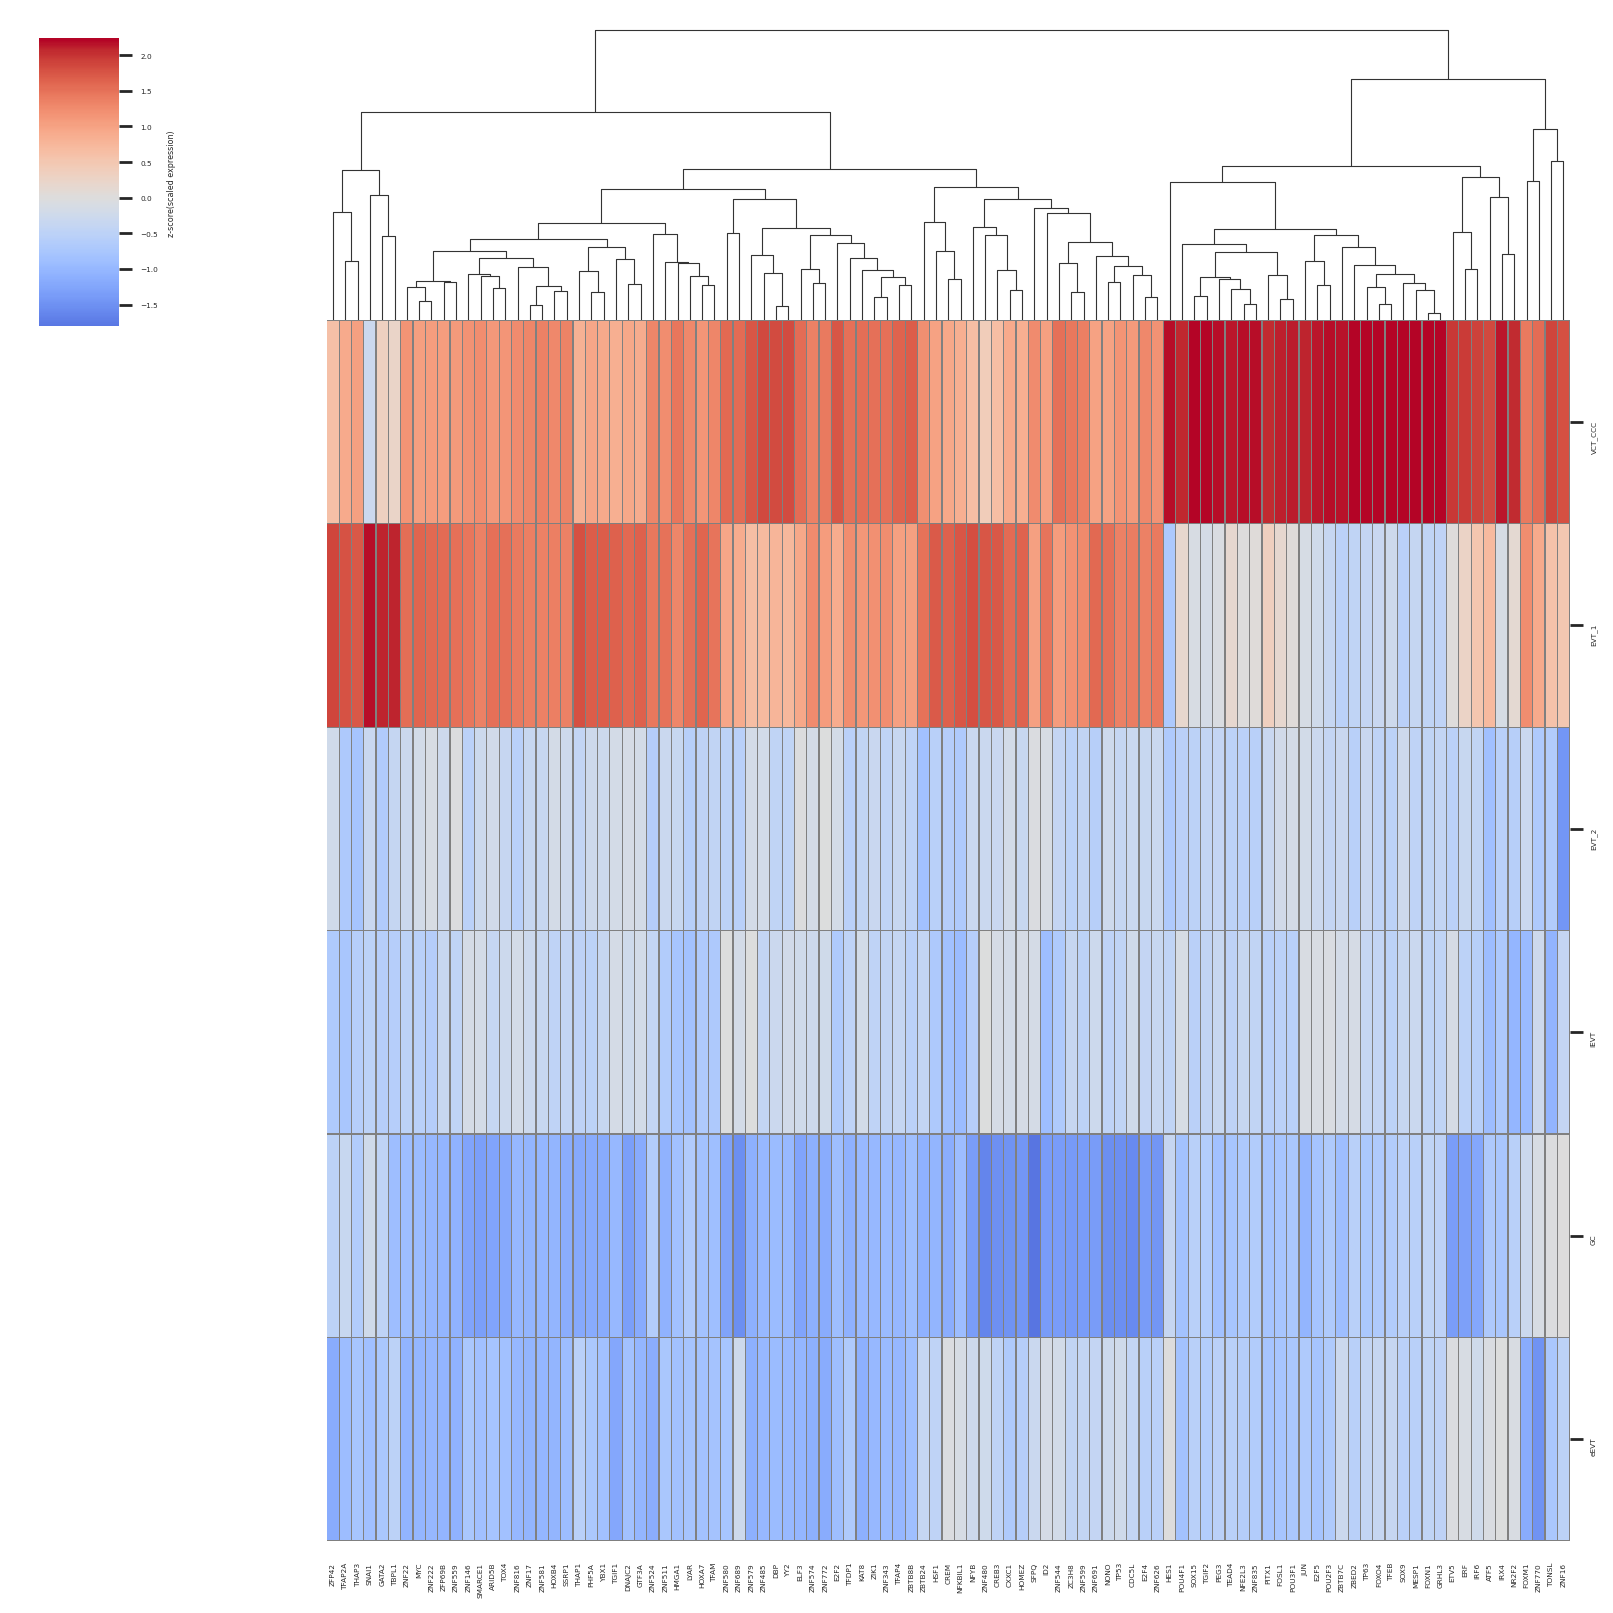

In [149]:
plt.figure(figsize=(100,5))

sns.set(font_scale=0.3)

# clusterplot for each ME

TFs2plot = sorted(MEs_TFs['ME_1_early_inv_column'])

sns.clustermap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
               row_cluster=False,
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
#x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = TFs2plot)



<Figure size 8000x400 with 0 Axes>

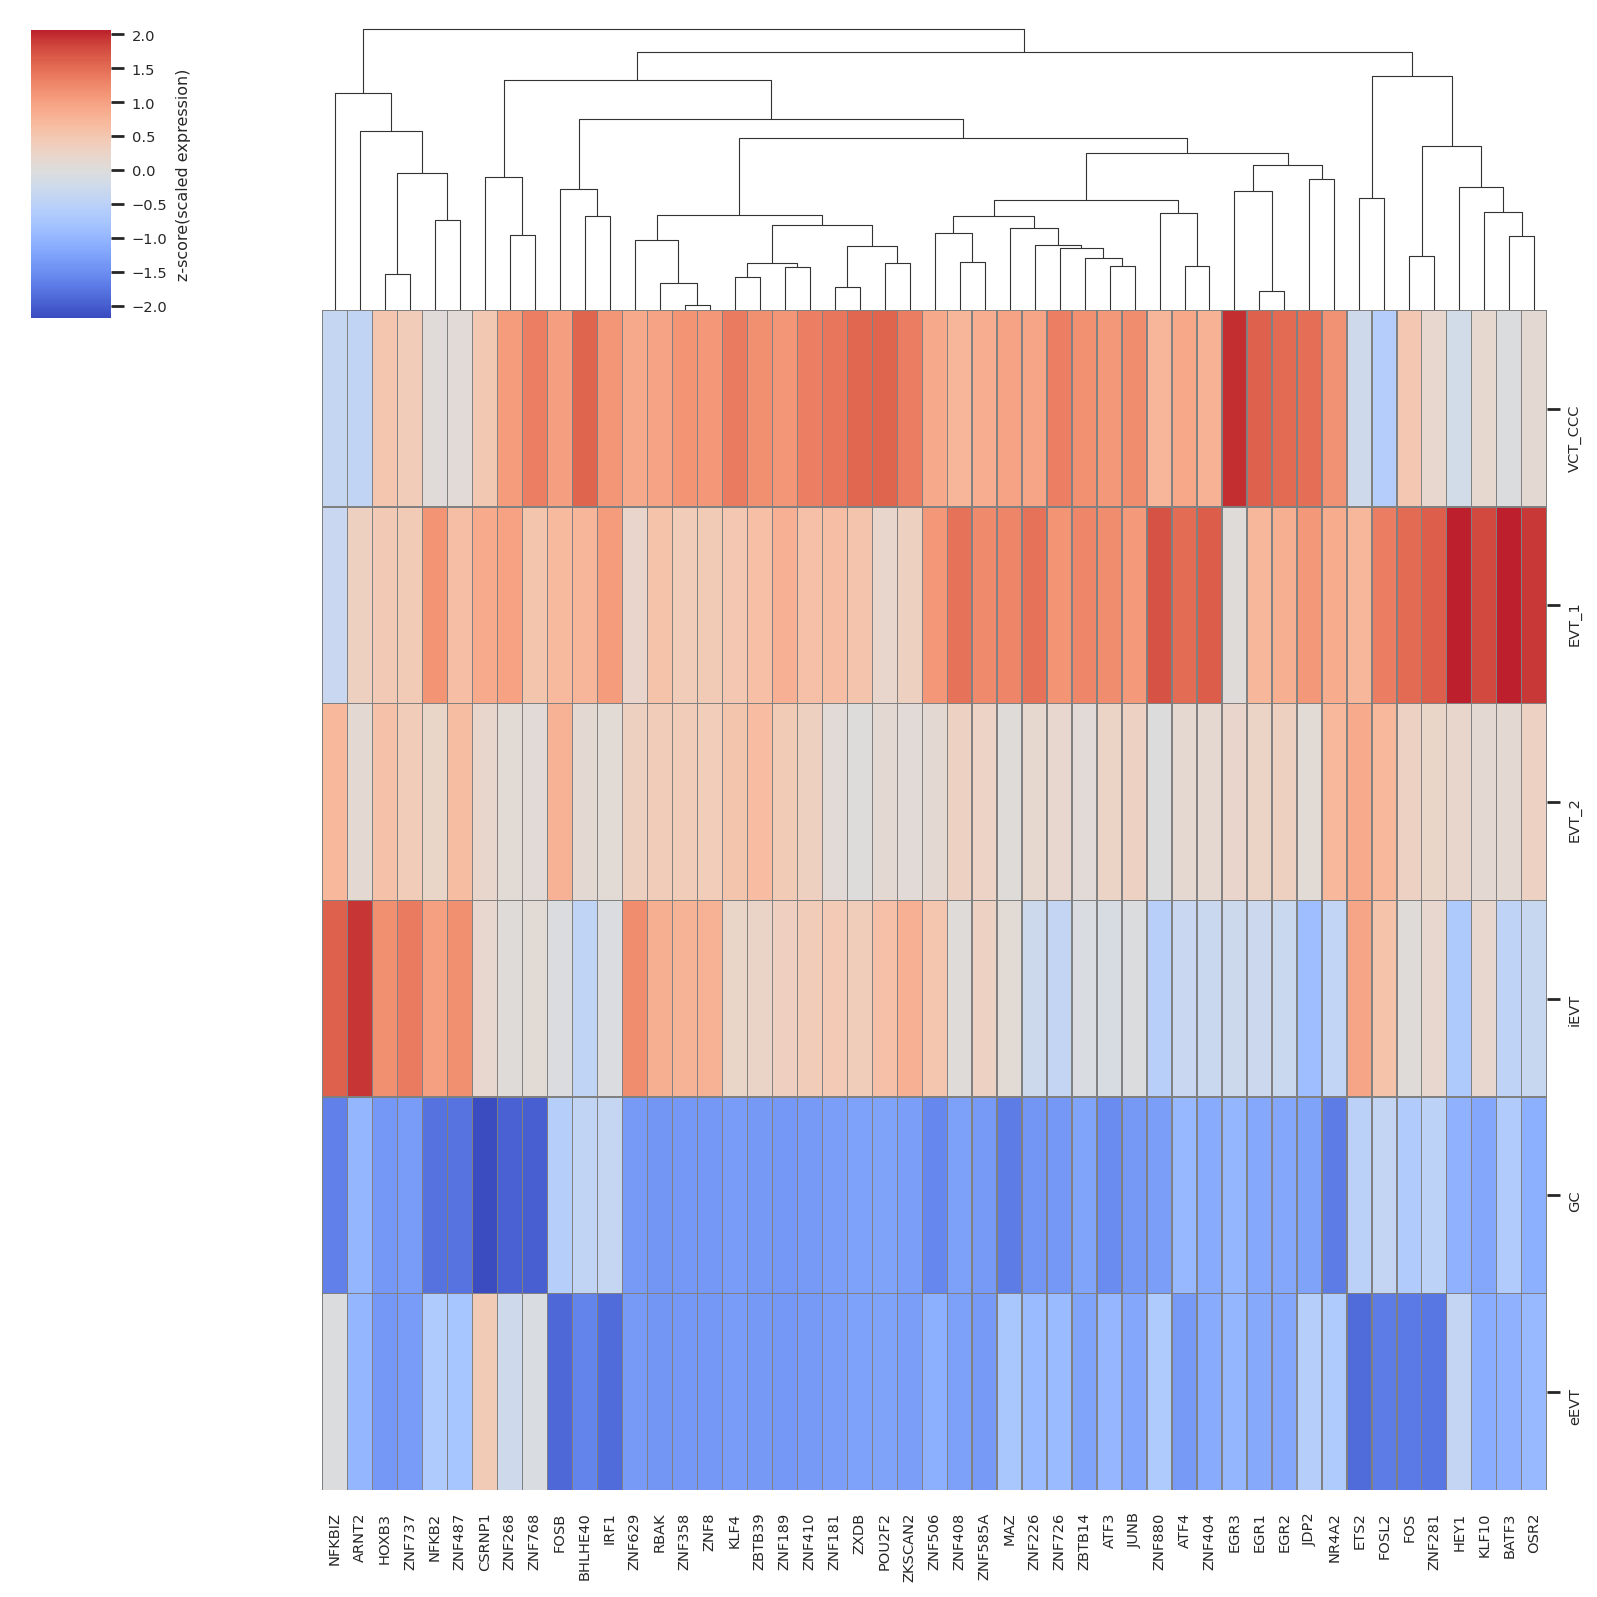

In [151]:
plt.figure(figsize=(100,5))

sns.set(font_scale=0.6)

# clusterplot for each ME

TFs2plot = sorted(MEs_TFs['ME_2_inv_front'])

sns.clustermap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
               row_cluster=False,
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
#x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = TFs2plot)



<Figure size 8000x400 with 0 Axes>

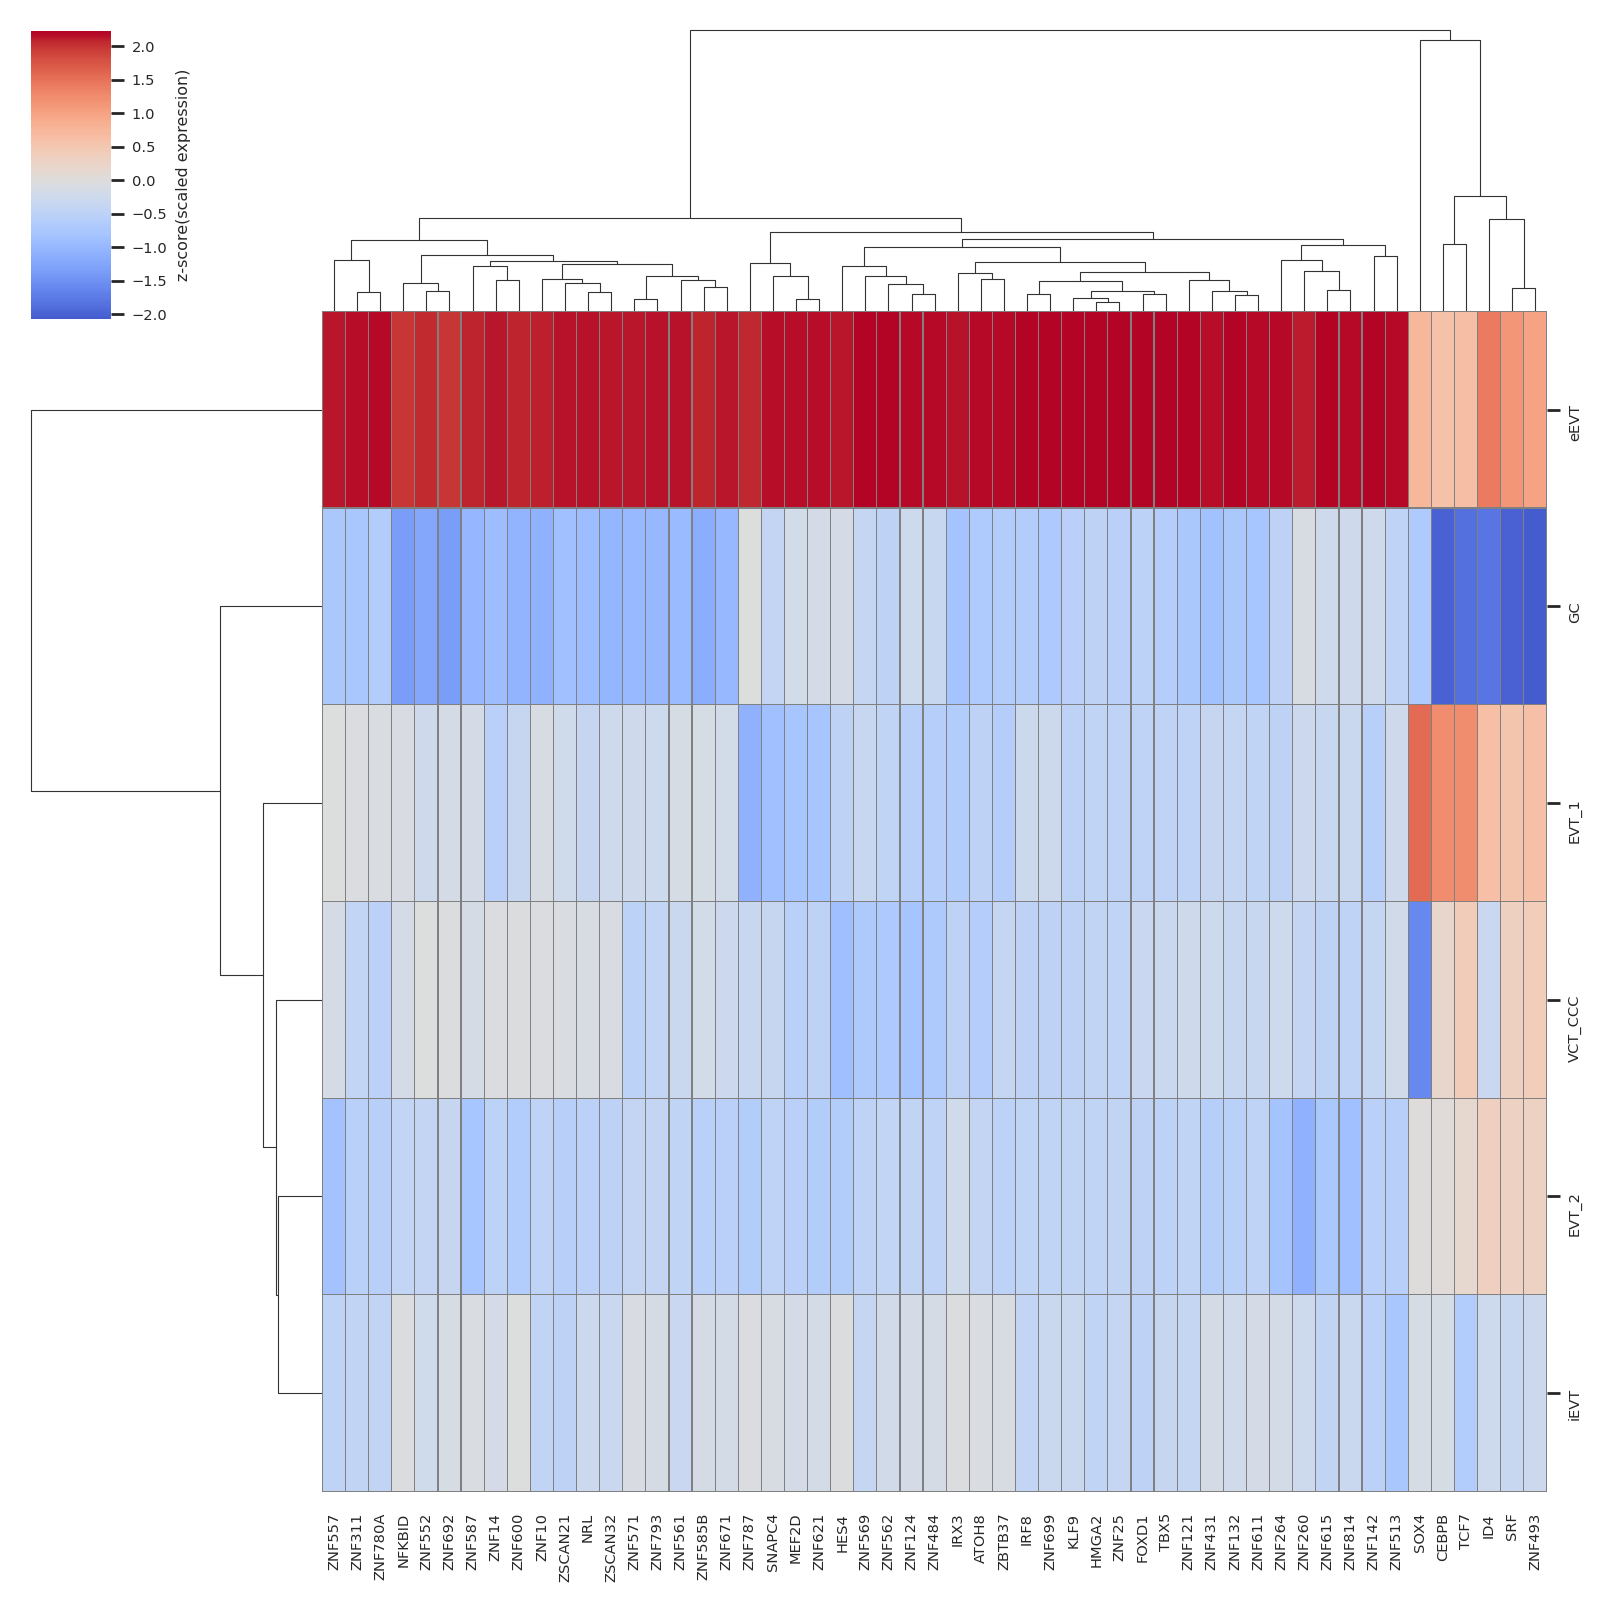

In [152]:
plt.figure(figsize=(100,5))

sns.set(font_scale=0.6)

# clusterplot for each ME

TFs2plot = sorted(MEs_TFs['ME_3_artery_remodelling'])

sns.clustermap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
               #row_cluster=False,
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
#x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = TFs2plot)



<Figure size 8000x400 with 0 Axes>

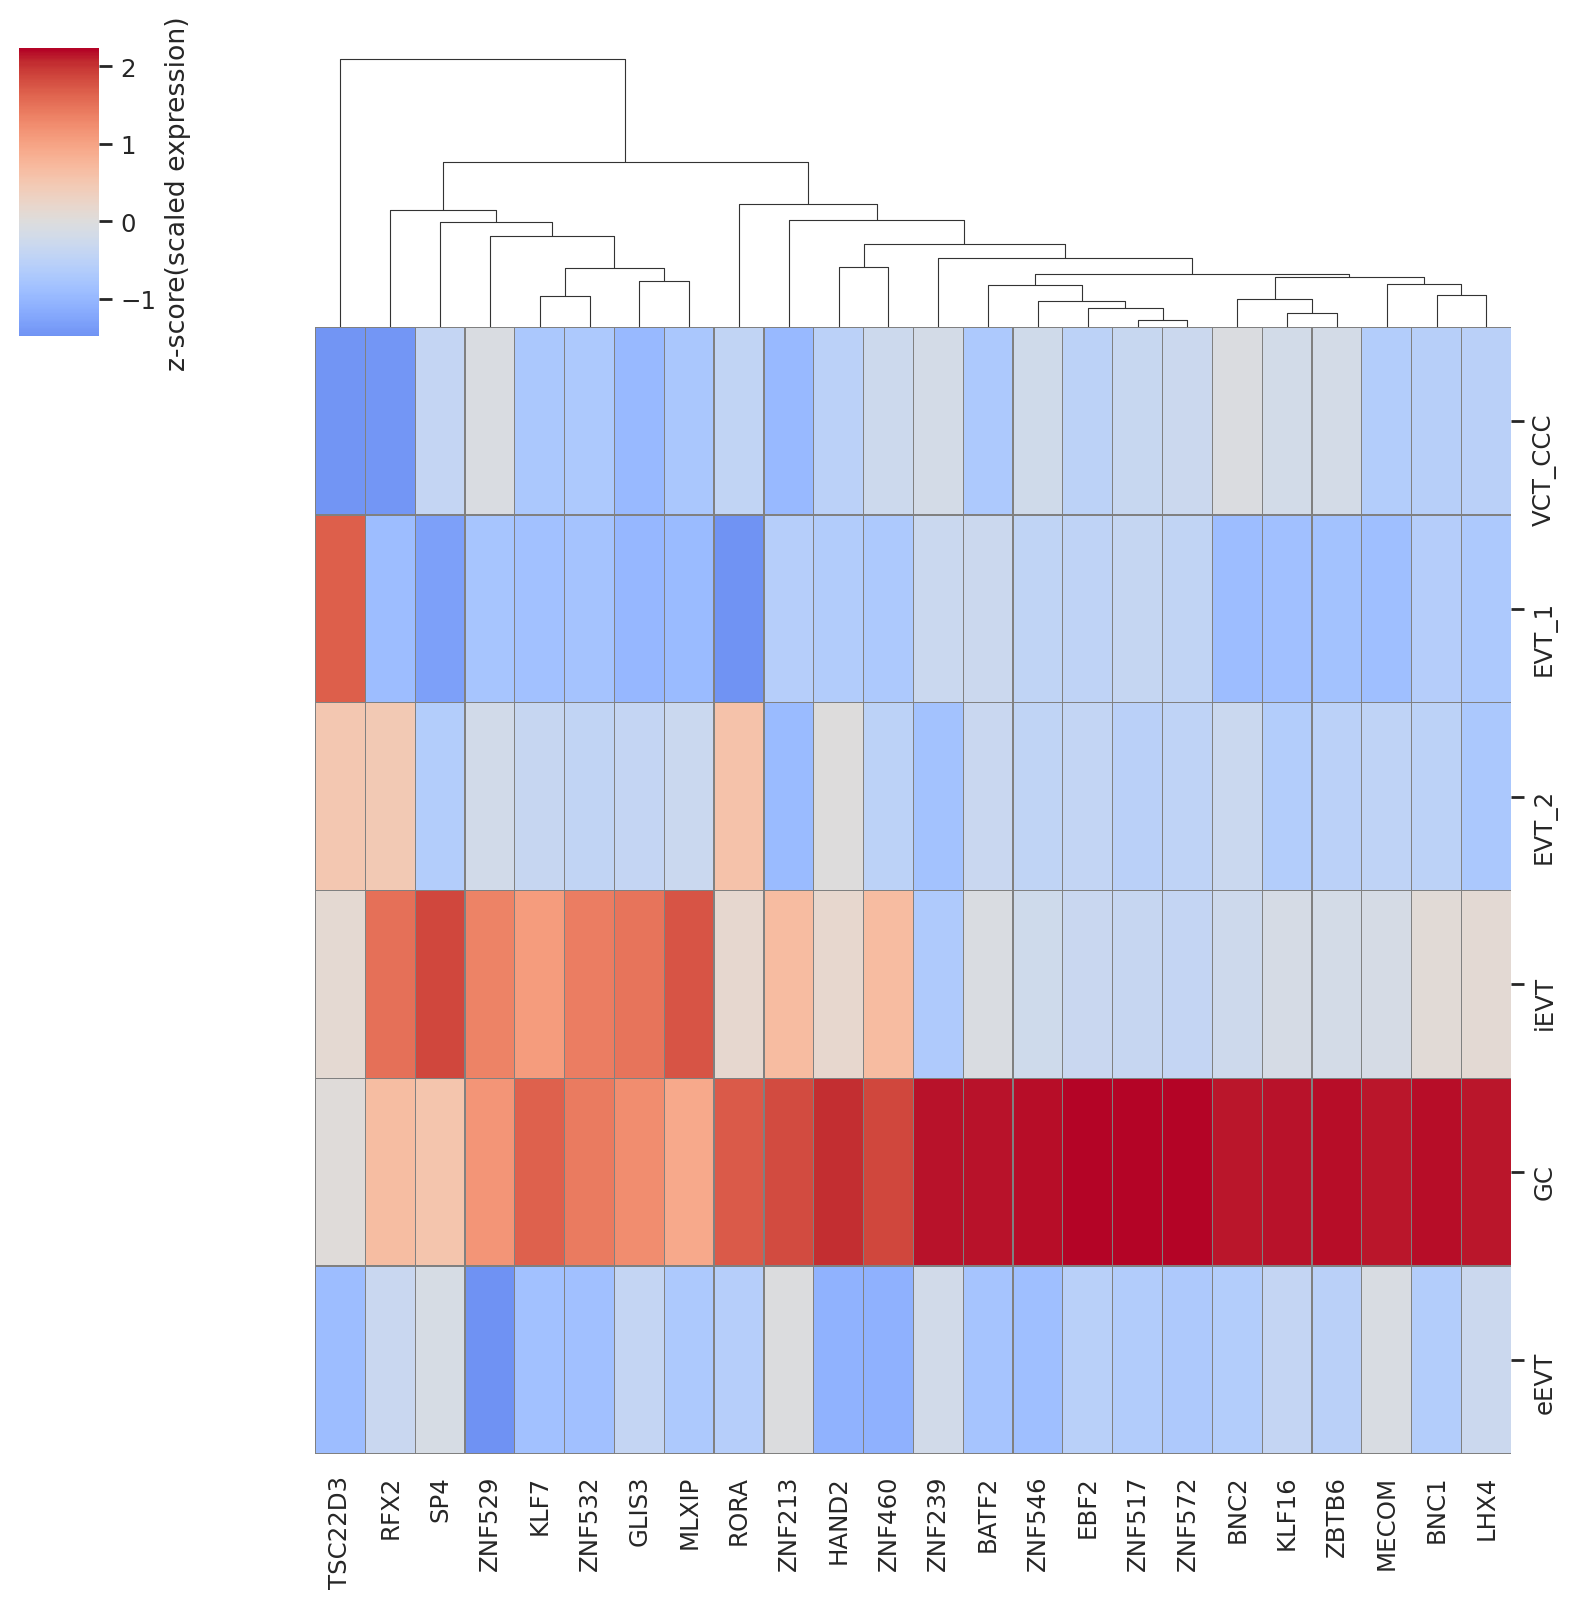

In [147]:
plt.figure(figsize=(100,5))

sns.set(font_scale=1.0)

# clusterplot for each ME

TFs2plot = sorted(MEs_TFs['ME_4_fusion'])

sns.clustermap(df_avg_expr_zscores.loc[TFs2plot].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
               row_cluster=False,
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
#x = np.arange(0.5, len(TFs2plot) + 0.5, 1)
#plt.xticks(x, fontsize=8, labels = TFs2plot)



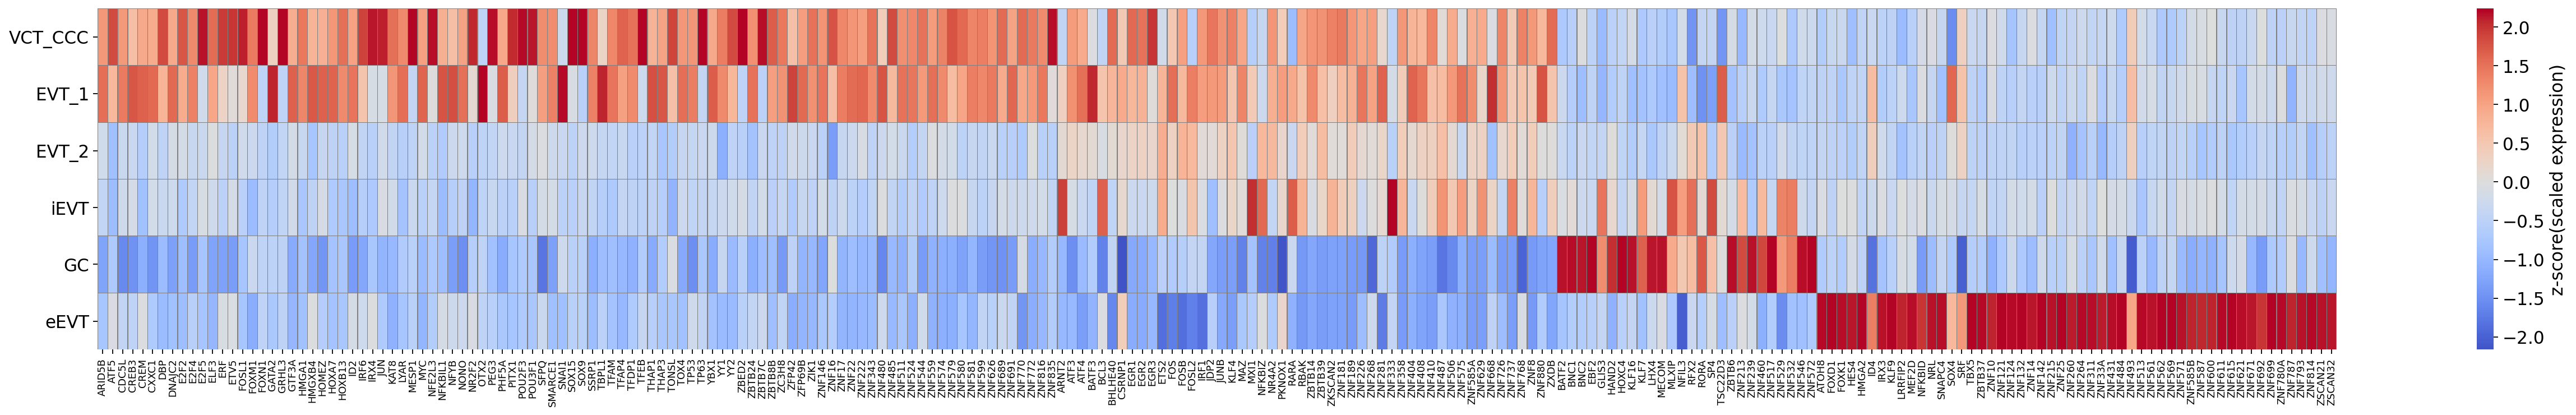

In [194]:
# all 4 MEs plotted together
# sorted by alphabet

plt.figure(figsize=(40,5))

sns.heatmap(df_avg_expr_zscores.loc[all_TFs_final].T,
            center=0, cmap='coolwarm',
            linewidths = 0.1, linecolor='grey',
            cbar_kws={'label': 'z-score(scaled expression)'}
             )
x = np.arange(0.5, 224.5, 1)
plt.xticks(x, fontsize=8, labels = all_TFs_final)

plt.savefig('./figures/20220202_TF_expression_heatmap_zscores_in_vivo_all_MEs_final_ALL.pdf', bbox_inches='tight')

In [168]:
all_TFs_final_df = pd.DataFrame(index=all_TFs_final)
MEs_vec = [[ME for i in range(len(MEs_TFs[ME]))] for ME in MEs]
MEs_vec = [item for sublist in MEs_vec for item in sublist]
all_TFs_final_df['ME'] = MEs_vec
all_TFs_final_df

ME
ARID5B   ME_1_early_inv_column
ATF5     ME_1_early_inv_column
CDC5L    ME_1_early_inv_column
CREB3    ME_1_early_inv_column
CREM     ME_1_early_inv_column
...                        ...
ZNF787             ME_4_fusion
ZNF793             ME_4_fusion
ZNF814             ME_4_fusion
ZSCAN21            ME_4_fusion
ZSCAN32            ME_4_fusion

[227 rows x 1 columns]

In [169]:
all_TFs_final_df.to_csv('./20220203_final_TFs_df_plot_Fig2G.csv')

In [170]:
'RELB' in list(df_avg_expr_zscores.index)

True

# to do: add somehow the types of evidence to each TF (in each celltype???)